# PyPSA Übung 06

### In einem Zukunftsszenario  gestalten Sie die Energieversorgung einer kleinen Kommune. Dafür haben die eine 4.5 MW Enercon Windturbine bauen lassen und sind zudem ans öffentliche Stromnetz angeschlossen und heizen mit einem großen Gaskessel. Sie haben bei der Ausschreibung für die Windturbine einen Zuschlagspreis von 6ct/kWh erhalten. Um die Energieversorgung nachhaltiger zu gestalten überlegen Sie eine Sektorenkopplung mittels Wasserstoff durchzuführen. Dafür möchten Sie einen Elektrolyseur, einen Wasserstoffspeicher, einen Wasserstoffkessel zum Heizen, sowie eine Brennstoffzelle zur Rückverstromung installieren. Die bei der Rückverstromung des Wasserstoffs durch die Brennstoffzelle entstehende Abwärme soll zudem auch genutzt werden. <br>

### Simulieren Sie das System um zu sehen ob die Wasserstoffintegration wirtschaftlich wäre und in welcher Größenordnung die Leistung der beteiligten Komponenten maximal benötigt werden würde.

<br>

### Führen Sie eine Sensitivitätsanalyse bezüglich der CO2 Emissionen des Systems durch. Diese sollen vom Emissionswert der Simulation ohne Beschränkung dabei Schrittweise um 10 Prozentpunkte auf schlussendlich 0 gesetzt werden.


Importieren Sie zunächst die notwendigen Bibliotheken

In [2]:
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Skizze des Netzwerks

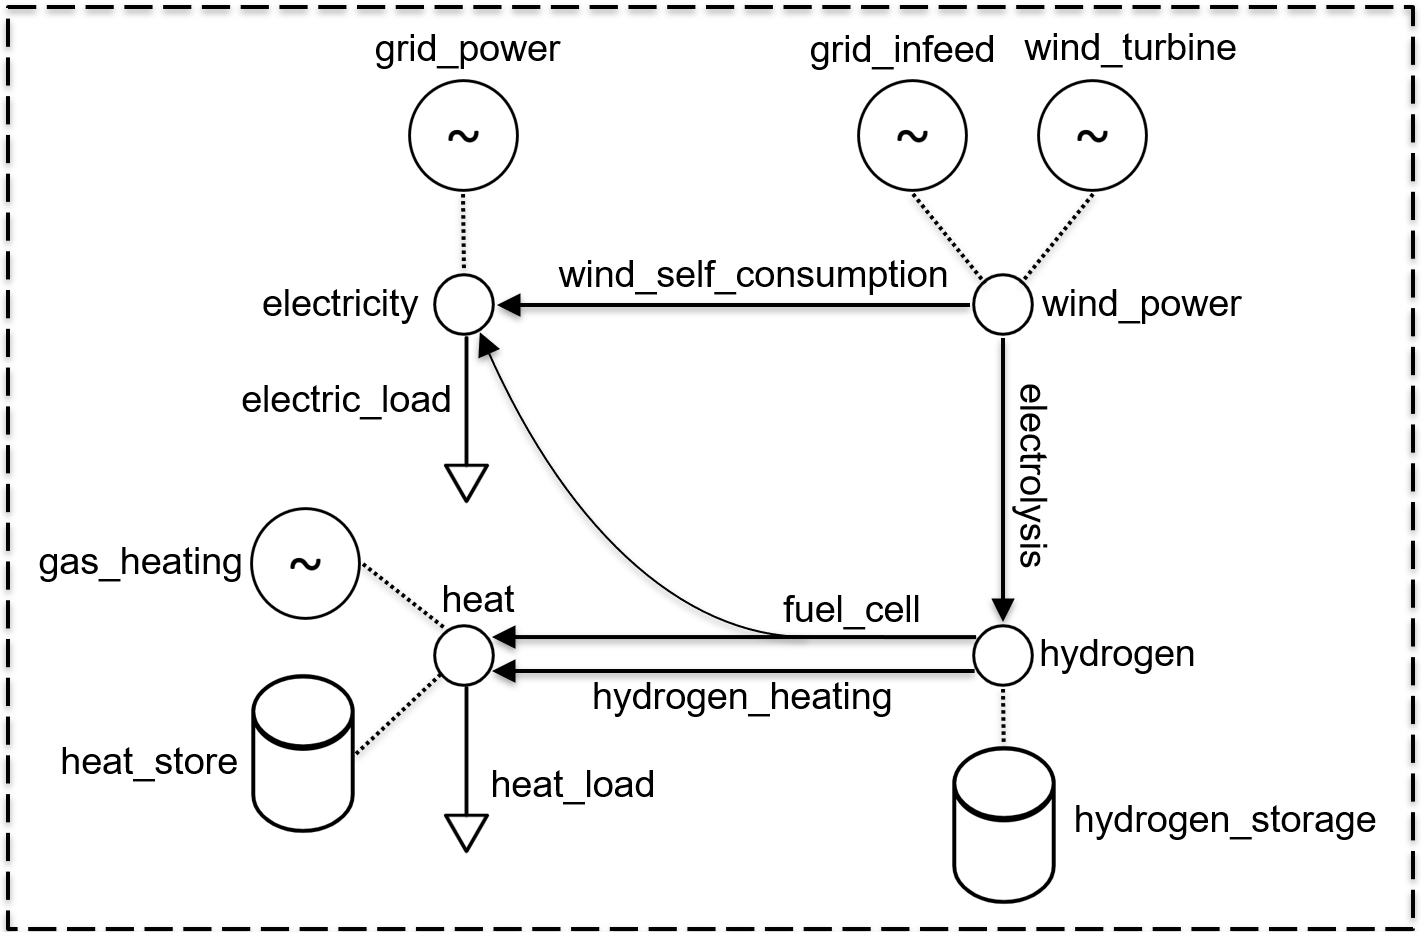

 Der Lastgang der Windturbine, die Heizlast, sowie die elektrische Last sind in der Datei "data_PyPSA_06.csv" gespeichert, lesen Sie diese mit pandas ein.

In [3]:
df_data = pd.read_csv('data_PyPSA_06.csv')


In [4]:
wind_data = df_data['wind_infeed']
electric_load = df_data['electric_load_kW']
heat_data = df_data['Heizlast_kW']
max_electrical_load = electric_load.max()

Folgende technische/finanzielle Angaben sind Ihnen bekannt: <br> 
Ergänzen Sie die nötigen Angaben im darunterstehenden Feld

In [5]:
#marginal costs
electricity_rate =   0.4 #€/kWh
gas_rate         =  0.14 #€/kWh


#efficiencies
efficiency_electrolysis     = 0.65  #decimal
efficiency_fuel_cell        = 0.7   #decimal
fuel_cell_heat              = 0.25  #decimal
efficiency_hydrogen_heating = 0.95  #decimal
efficiency_gas_heating      = 0.95  #decimal
storage_loss                = 0.005 #decimal



#co2 emissions
co2_emissions_germany_electricity  = 0.375 #kg/kWh
co2_emissions_natural_gas          = 0.274 #kg/kWh

#capital costs
capital_cost_electrolysis     = 200  #€/kW  as annuity
capital_cost_fuel_cell        = 1000 #€/kW  as annuity
capital_cost_hydrogen_storage = 50   #€/kWh as annuity
capital_cost_hydrogen_heating = 10   #€/kW  as annuity
capital_cost_gas_heating      = 7    #€/kW  as annuity
capital_cost_wind             = 150  #€/kW  as annuity
capital_cost_heat_store       = 10   #€/kWh as annuity

In [19]:
grid_infeed = -0.06 #€/kWh infeed of wind energy
wind_p_nom_min = 4500 #kW
wind_p_nom_max = 9000 #kW
wind_p_max_pu = wind_data/wind_p_nom_min # per unit

Implementieren Sie das System

In [29]:
# Netzwerk erstellen
network = pypsa.Network()
network.set_snapshots(range(8760))

#Buses
network.add('Bus', name = 'electricity')
network.add('Bus', name = 'wind_power')
network.add('Bus', name = 'hydrogen')
network.add('Bus', name = 'heat')

#Carriers
network.add('Carrier', name = 'german_electricity', 
            co2_emissions = co2_emissions_germany_electricity)
network.add('Carrier', name = 'natural_gas', 
            co2_emissions = co2_emissions_natural_gas)

#Generators
network.add('Generator', name = 'grid_power', bus = 'electricity',
           marginal_cost = electricity_rate, p_nom = max_electrical_load,
           carrier = 'german_electricity')
network.add('Generator', name = 'wind_tubine', bus = 'wind_power',
           p_nom_extendable = True, p_nom_min = wind_p_nom_min,
           p_max_pu = wind_p_max_pu, p_nom_max = wind_p_nom_max,
           capital_cost = capital_cost_wind, p_nom_mod = wind_p_nom_min)
network.add('Generator', name = 'grid_infeed', bus = 'wind_power',
           marginal_cost = grid_infeed, sign = -1, p_nom = wind_p_nom_max)
network.add('Generator', name = 'gas_heating', bus = 'heat',
            marginal_cost = gas_rate/efficiency_gas_heating, 
            capital_cost = capital_cost_gas_heating, p_nom_extendable = True,
           carrier = 'natural_gas', efficiency = efficiency_gas_heating)


#Links
network.add('Link', name = 'wind_self_consumption', bus0 = 'wind_power',
            bus1='electricity', p_nom = wind_p_nom_max)
network.add('Link', name = 'electrolysis', bus0 = 'wind_power',
           bus1 = 'hydrogen', p_nom_extendable = True, 
            capital_cost = capital_cost_electrolysis, 
            efficiency = efficiency_electrolysis)
network.add('Link', name = 'hydrogen_heating', 
            bus0 = 'hydrogen', bus1 ='heat',
            p_nom_extendable = True, 
            capital_cost = capital_cost_hydrogen_heating,
            efficiency = efficiency_hydrogen_heating)
network.add('Link', name = 'fuel_cell', bus0 = 'hydrogen',
           bus1= 'heat', bus2 = 'electricity',
           p_nom_extendable = True, 
            capital_cost = capital_cost_fuel_cell, 
            efficiency = fuel_cell_heat, 
            efficiency2 = efficiency_fuel_cell )

#Stores
network.add('Store', name = 'hydrogen_storage', bus = 'hydrogen',
           e_nom_extendable = True, 
            capital_cost = capital_cost_hydrogen_storage, e_cyclic = True)
network.add('Store', name = 'heat_store', bus = 'heat', 
           e_nom_extendable = True, capital_cost = capital_cost_heat_store,
           standing_loss = storage_loss, e_cyclic = True)

#Loads
network.add('Load', name = 'electrical_load', bus = 'electricity', 
            p_set = electric_load)
network.add('Load', name = 'thermal_load', bus = 'heat', 
            p_set = heat_data)

#Global Constraint
network.add('GlobalConstraint', name = 'co2-limit', 
           sense = '<=', carrier_attribute = 'co2_emissions',
           constant = np.inf)

Index(['co2-limit'], dtype='object')

Optimieren Sie das Netzwerk mit der Methode .optimize(solver_name = 'gurobi', threads = 1, method = 2)

In [30]:
network.optimize(solver_name = 'gurobi', threads = 1, method = 2)

Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - threads: 1
 - method: 2
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 654.44it/s]
INFO:linopy.io: Writing time: 1.68s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-yy98zoes.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-yy98zoes.lp


Reading time = 0.42 seconds


INFO:gurobipy:Reading time = 0.42 seconds


obj: 227769 rows, 105128 columns, 420490 nonzeros


INFO:gurobipy:obj: 227769 rows, 105128 columns, 420490 nonzeros


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227769 rows, 105128 columns and 420490 nonzeros


INFO:gurobipy:Optimize a model with 227769 rows, 105128 columns and 420490 nonzeros


Model fingerprint: 0x4fe61ca1


INFO:gurobipy:Model fingerprint: 0x4fe61ca1


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+03]


INFO:gurobipy:  RHS range        [1e-03, 9e+03]


Presolve removed 140169 rows and 43801 columns


INFO:gurobipy:Presolve removed 140169 rows and 43801 columns


Presolve time: 0.46s


INFO:gurobipy:Presolve time: 0.46s


Presolved: 87600 rows, 61327 columns, 236520 nonzeros


INFO:gurobipy:Presolved: 87600 rows, 61327 columns, 236520 nonzeros


Variable types: 61326 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 61326 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.270e+05


INFO:gurobipy: AA' NZ     : 2.270e+05


 Factor NZ  : 1.433e+06 (roughly 70 MB of memory)


INFO:gurobipy: Factor NZ  : 1.433e+06 (roughly 70 MB of memory)


 Factor Ops : 2.440e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.440e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0  -4.73609385e+07 -3.80137321e+08  5.46e+03 1.44e+00  2.50e+05     1s


INFO:gurobipy:   0  -4.73609385e+07 -3.80137321e+08  5.46e+03 1.44e+00  2.50e+05     1s


   1  -1.55196612e+07 -6.47815610e+08  3.03e+03 3.15e+01  8.94e+04     1s


INFO:gurobipy:   1  -1.55196612e+07 -6.47815610e+08  3.03e+03 3.15e+01  8.94e+04     1s


   2   7.68011613e+06 -6.11274342e+08  1.13e+03 2.76e+00  2.79e+04     1s


INFO:gurobipy:   2   7.68011613e+06 -6.11274342e+08  1.13e+03 2.76e+00  2.79e+04     1s


   3   9.91197246e+06 -4.31842374e+08  3.31e+02 7.69e-01  9.42e+03     1s


INFO:gurobipy:   3   9.91197246e+06 -4.31842374e+08  3.31e+02 7.69e-01  9.42e+03     1s


   4   8.87136724e+06 -2.51268609e+08  1.80e+01 3.37e-01  2.60e+03     2s


INFO:gurobipy:   4   8.87136724e+06 -2.51268609e+08  1.80e+01 3.37e-01  2.60e+03     2s


   5   5.74819677e+06 -1.98861267e+07  2.48e+00 1.16e-02  2.00e+02     2s


INFO:gurobipy:   5   5.74819677e+06 -1.98861267e+07  2.48e+00 1.16e-02  2.00e+02     2s


   6   3.81662562e+06 -4.51956521e+06  6.27e-01 3.15e-03  6.14e+01     2s


INFO:gurobipy:   6   3.81662562e+06 -4.51956521e+06  6.27e-01 3.15e-03  6.14e+01     2s


   7   3.00917815e+06 -4.56057772e+05  2.68e-01 1.05e-03  2.44e+01     2s


INFO:gurobipy:   7   3.00917815e+06 -4.56057772e+05  2.68e-01 1.05e-03  2.44e+01     2s


   8   2.51203673e+06 -3.46521915e+04  1.41e-01 8.22e-04  1.76e+01     2s


INFO:gurobipy:   8   2.51203673e+06 -3.46521915e+04  1.41e-01 8.22e-04  1.76e+01     2s


   9   2.17336325e+06  7.46176153e+05  7.12e-02 3.74e-04  9.64e+00     2s


INFO:gurobipy:   9   2.17336325e+06  7.46176153e+05  7.12e-02 3.74e-04  9.64e+00     2s


  10   2.02183616e+06  1.13801313e+06  4.50e-02 2.09e-04  5.88e+00     2s


INFO:gurobipy:  10   2.02183616e+06  1.13801313e+06  4.50e-02 2.09e-04  5.88e+00     2s


  11   1.89885321e+06  1.32438001e+06  2.80e-02 7.08e-06  3.78e+00     2s


INFO:gurobipy:  11   1.89885321e+06  1.32438001e+06  2.80e-02 7.08e-06  3.78e+00     2s


  12   1.83727553e+06  1.42918111e+06  2.05e-02 5.54e-11  2.67e+00     3s


INFO:gurobipy:  12   1.83727553e+06  1.42918111e+06  2.05e-02 5.54e-11  2.67e+00     3s


  13   1.76380429e+06  1.49465049e+06  1.21e-02 3.07e-11  1.75e+00     3s


INFO:gurobipy:  13   1.76380429e+06  1.49465049e+06  1.21e-02 3.07e-11  1.75e+00     3s


  14   1.73452844e+06  1.56854158e+06  8.95e-03 1.91e-11  1.08e+00     3s


INFO:gurobipy:  14   1.73452844e+06  1.56854158e+06  8.95e-03 1.91e-11  1.08e+00     3s


  15   1.71831449e+06  1.57651282e+06  7.36e-03 1.56e-11  9.18e-01     3s


INFO:gurobipy:  15   1.71831449e+06  1.57651282e+06  7.36e-03 1.56e-11  9.18e-01     3s


  16   1.69918985e+06  1.60112033e+06  5.47e-03 1.10e-11  6.33e-01     3s


INFO:gurobipy:  16   1.69918985e+06  1.60112033e+06  5.47e-03 1.10e-11  6.33e-01     3s


  17   1.69043152e+06  1.60722313e+06  4.65e-03 7.16e-12  5.37e-01     3s


INFO:gurobipy:  17   1.69043152e+06  1.60722313e+06  4.65e-03 7.16e-12  5.37e-01     3s


  18   1.67955829e+06  1.61627819e+06  3.55e-03 4.32e-12  4.08e-01     3s


INFO:gurobipy:  18   1.67955829e+06  1.61627819e+06  3.55e-03 4.32e-12  4.08e-01     3s


  19   1.67615535e+06  1.61828342e+06  3.24e-03 5.00e-12  3.73e-01     3s


INFO:gurobipy:  19   1.67615535e+06  1.61828342e+06  3.24e-03 5.00e-12  3.73e-01     3s


  20   1.66752123e+06  1.62729421e+06  2.47e-03 1.73e-11  2.59e-01     3s


INFO:gurobipy:  20   1.66752123e+06  1.62729421e+06  2.47e-03 1.73e-11  2.59e-01     3s


  21   1.66396812e+06  1.62836755e+06  2.15e-03 5.91e-12  2.29e-01     4s


INFO:gurobipy:  21   1.66396812e+06  1.62836755e+06  2.15e-03 5.91e-12  2.29e-01     4s


  22   1.66049774e+06  1.63368274e+06  1.85e-03 7.28e-12  1.72e-01     4s


INFO:gurobipy:  22   1.66049774e+06  1.63368274e+06  1.85e-03 7.28e-12  1.72e-01     4s


  23   1.65509358e+06  1.63478245e+06  1.37e-03 2.50e-12  1.30e-01     4s


INFO:gurobipy:  23   1.65509358e+06  1.63478245e+06  1.37e-03 2.50e-12  1.30e-01     4s


  24   1.65343295e+06  1.63530797e+06  1.23e-03 3.52e-12  1.16e-01     4s


INFO:gurobipy:  24   1.65343295e+06  1.63530797e+06  1.23e-03 3.52e-12  1.16e-01     4s


  25   1.65279036e+06  1.63640601e+06  1.18e-03 2.27e-11  1.05e-01     4s


INFO:gurobipy:  25   1.65279036e+06  1.63640601e+06  1.18e-03 2.27e-11  1.05e-01     4s


  26   1.64977312e+06  1.63745912e+06  9.02e-04 2.00e-11  7.89e-02     4s


INFO:gurobipy:  26   1.64977312e+06  1.63745912e+06  9.02e-04 2.00e-11  7.89e-02     4s


  27   1.64843762e+06  1.63761993e+06  7.77e-04 2.09e-11  6.93e-02     4s


INFO:gurobipy:  27   1.64843762e+06  1.63761993e+06  7.77e-04 2.09e-11  6.93e-02     4s


  28   1.64600245e+06  1.63797621e+06  5.66e-04 1.14e-12  5.15e-02     4s


INFO:gurobipy:  28   1.64600245e+06  1.63797621e+06  5.66e-04 1.14e-12  5.15e-02     4s


  29   1.64580951e+06  1.63815282e+06  5.43e-04 2.00e-11  4.91e-02     4s


INFO:gurobipy:  29   1.64580951e+06  1.63815282e+06  5.43e-04 2.00e-11  4.91e-02     4s


  30   1.64539873e+06  1.63854506e+06  5.06e-04 5.46e-12  4.39e-02     4s


INFO:gurobipy:  30   1.64539873e+06  1.63854506e+06  5.06e-04 5.46e-12  4.39e-02     4s


  31   1.64494162e+06  1.63876623e+06  4.65e-04 1.33e-15  3.96e-02     5s


INFO:gurobipy:  31   1.64494162e+06  1.63876623e+06  4.65e-04 1.33e-15  3.96e-02     5s


  32   1.64387194e+06  1.63892301e+06  3.72e-04 1.25e-12  3.17e-02     5s


INFO:gurobipy:  32   1.64387194e+06  1.63892301e+06  3.72e-04 1.25e-12  3.17e-02     5s


  33   1.64248954e+06  1.63933137e+06  2.44e-04 1.00e-11  2.02e-02     5s


INFO:gurobipy:  33   1.64248954e+06  1.63933137e+06  2.44e-04 1.00e-11  2.02e-02     5s


  34   1.64191841e+06  1.63936119e+06  1.95e-04 8.19e-12  1.64e-02     5s


INFO:gurobipy:  34   1.64191841e+06  1.63936119e+06  1.95e-04 8.19e-12  1.64e-02     5s


  35   1.64151676e+06  1.63945280e+06  1.61e-04 1.46e-11  1.32e-02     5s


INFO:gurobipy:  35   1.64151676e+06  1.63945280e+06  1.61e-04 1.46e-11  1.32e-02     5s


  36   1.64100991e+06  1.63951561e+06  1.14e-04 7.96e-13  9.56e-03     5s


INFO:gurobipy:  36   1.64100991e+06  1.63951561e+06  1.14e-04 7.96e-13  9.56e-03     5s


  37   1.64063218e+06  1.63956003e+06  8.01e-05 2.16e-12  6.86e-03     5s


INFO:gurobipy:  37   1.64063218e+06  1.63956003e+06  8.01e-05 2.16e-12  6.86e-03     5s


  38   1.64042267e+06  1.63962177e+06  6.10e-05 2.27e-13  5.12e-03     5s


INFO:gurobipy:  38   1.64042267e+06  1.63962177e+06  6.10e-05 2.27e-13  5.12e-03     5s


  39   1.64021874e+06  1.63964513e+06  4.34e-05 2.96e-12  3.67e-03     5s


INFO:gurobipy:  39   1.64021874e+06  1.63964513e+06  4.34e-05 2.96e-12  3.67e-03     5s


  40   1.64008357e+06  1.63966026e+06  3.18e-05 3.75e-12  2.71e-03     6s


INFO:gurobipy:  40   1.64008357e+06  1.63966026e+06  3.18e-05 3.75e-12  2.71e-03     6s


  41   1.63997750e+06  1.63967604e+06  2.30e-05 5.68e-13  1.93e-03     6s


INFO:gurobipy:  41   1.63997750e+06  1.63967604e+06  2.30e-05 5.68e-13  1.93e-03     6s


  42   1.63987517e+06  1.63967889e+06  1.45e-05 7.96e-13  1.25e-03     6s


INFO:gurobipy:  42   1.63987517e+06  1.63967889e+06  1.45e-05 7.96e-13  1.25e-03     6s


  43   1.63982969e+06  1.63968721e+06  1.07e-05 3.64e-12  9.10e-04     6s


INFO:gurobipy:  43   1.63982969e+06  1.63968721e+06  1.07e-05 3.64e-12  9.10e-04     6s


  44   1.63980374e+06  1.63968828e+06  8.64e-06 1.82e-12  7.38e-04     6s


INFO:gurobipy:  44   1.63980374e+06  1.63968828e+06  8.64e-06 1.82e-12  7.38e-04     6s


  45   1.63980033e+06  1.63968955e+06  8.36e-06 3.07e-12  7.08e-04     6s


INFO:gurobipy:  45   1.63980033e+06  1.63968955e+06  8.36e-06 3.07e-12  7.08e-04     6s


  46   1.63978548e+06  1.63969069e+06  7.17e-06 1.27e-11  6.06e-04     6s


INFO:gurobipy:  46   1.63978548e+06  1.63969069e+06  7.17e-06 1.27e-11  6.06e-04     6s


  47   1.63973860e+06  1.63969220e+06  3.43e-06 3.18e-11  2.96e-04     6s


INFO:gurobipy:  47   1.63973860e+06  1.63969220e+06  3.43e-06 3.18e-11  2.96e-04     6s


  48   1.63972366e+06  1.63969250e+06  2.29e-06 3.46e-11  1.99e-04     7s


INFO:gurobipy:  48   1.63972366e+06  1.63969250e+06  2.29e-06 3.46e-11  1.99e-04     7s


  49   1.63971470e+06  1.63969260e+06  1.59e-06 1.91e-11  1.41e-04     7s


INFO:gurobipy:  49   1.63971470e+06  1.63969260e+06  1.59e-06 1.91e-11  1.41e-04     7s


  50   1.63969953e+06  1.63969324e+06  4.26e-07 3.18e-11  4.02e-05     7s


INFO:gurobipy:  50   1.63969953e+06  1.63969324e+06  4.26e-07 3.18e-11  4.02e-05     7s


  51   1.63969625e+06  1.63969371e+06  2.11e-07 5.91e-11  1.62e-05     7s


INFO:gurobipy:  51   1.63969625e+06  1.63969371e+06  2.11e-07 5.91e-11  1.62e-05     7s


  52   1.63969503e+06  1.63969376e+06  1.57e-07 1.52e-11  8.06e-06     7s


INFO:gurobipy:  52   1.63969503e+06  1.63969376e+06  1.57e-07 1.52e-11  8.06e-06     7s


  53   1.63969472e+06  1.63969379e+06  1.22e-07 1.36e-12  5.94e-06     7s


INFO:gurobipy:  53   1.63969472e+06  1.63969379e+06  1.22e-07 1.36e-12  5.94e-06     7s


  54   1.63969446e+06  1.63969380e+06  1.37e-07 3.87e-12  4.25e-06     7s


INFO:gurobipy:  54   1.63969446e+06  1.63969380e+06  1.37e-07 3.87e-12  4.25e-06     7s


  55   1.63969435e+06  1.63969381e+06  1.44e-07 7.84e-12  3.48e-06     7s


INFO:gurobipy:  55   1.63969435e+06  1.63969381e+06  1.44e-07 7.84e-12  3.48e-06     7s


  56   1.63969418e+06  1.63969382e+06  2.22e-07 1.27e-11  2.27e-06     7s


INFO:gurobipy:  56   1.63969418e+06  1.63969382e+06  2.22e-07 1.27e-11  2.27e-06     7s


  57   1.63969409e+06  1.63969383e+06  1.72e-07 7.96e-13  1.66e-06     8s


INFO:gurobipy:  57   1.63969409e+06  1.63969383e+06  1.72e-07 7.96e-13  1.66e-06     8s


  58   1.63969404e+06  1.63969384e+06  1.39e-07 3.64e-12  1.28e-06     8s


INFO:gurobipy:  58   1.63969404e+06  1.63969384e+06  1.39e-07 3.64e-12  1.28e-06     8s


  59   1.63969395e+06  1.63969384e+06  1.09e-07 3.41e-12  7.13e-07     8s


INFO:gurobipy:  59   1.63969395e+06  1.63969384e+06  1.09e-07 3.41e-12  7.13e-07     8s


  60   1.63969391e+06  1.63969385e+06  1.75e-05 1.73e-11  3.98e-07     8s


INFO:gurobipy:  60   1.63969391e+06  1.63969385e+06  1.75e-05 1.73e-11  3.98e-07     8s


  61   1.63969389e+06  1.63969385e+06  1.07e-05 1.21e-11  2.59e-07     8s


INFO:gurobipy:  61   1.63969389e+06  1.63969385e+06  1.07e-05 1.21e-11  2.59e-07     8s


  62   1.63969386e+06  1.63969385e+06  2.82e-06 3.64e-11  7.53e-08     8s


INFO:gurobipy:  62   1.63969386e+06  1.63969385e+06  2.82e-06 3.64e-11  7.53e-08     8s


  63   1.63969385e+06  1.63969385e+06  3.41e-07 3.30e-12  9.01e-09     8s


INFO:gurobipy:  63   1.63969385e+06  1.63969385e+06  3.41e-07 3.30e-12  9.01e-09     8s


INFO:gurobipy:


Barrier solved model in 63 iterations and 8.32 seconds (3.53 work units)


INFO:gurobipy:Barrier solved model in 63 iterations and 8.32 seconds (3.53 work units)


Optimal objective 1.63969385e+06


INFO:gurobipy:Optimal objective 1.63969385e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   60072 DPushes remaining with DInf 0.0000000e+00                 8s


INFO:gurobipy:   60072 DPushes remaining with DInf 0.0000000e+00                 8s


       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                 9s


INFO:gurobipy:


   13204 PPushes remaining with PInf 1.1313384e-01                 9s


INFO:gurobipy:   13204 PPushes remaining with PInf 1.1313384e-01                 9s


       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                 9s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1167706e-11      9s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 2.1167706e-11      9s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   44237    1.6396938e+06   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   44237    1.6396938e+06   0.000000e+00   0.000000e+00      9s


   44237    1.6396938e+06   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:   44237    1.6396938e+06   0.000000e+00   0.000000e+00      9s


INFO:gurobipy:


Root relaxation: objective 1.639694e+06, 44237 iterations, 8.18 seconds (3.21 work units)


INFO:gurobipy:Root relaxation: objective 1.639694e+06, 44237 iterations, 8.18 seconds (3.21 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 1639693.85    0    1          - 1639693.85      -     -    8s


INFO:gurobipy:     0     0 1639693.85    0    1          - 1639693.85      -     -    8s


H    0     0                    1646943.6392 1639693.85  0.44%     -    9s


INFO:gurobipy:H    0     0                    1646943.6392 1639693.85  0.44%     -    9s


     0     0 1639693.85    0    1 1646943.64 1639693.85  0.44%     -    9s


INFO:gurobipy:     0     0 1639693.85    0    1 1646943.64 1639693.85  0.44%     -    9s


     0     2 1639710.14    0    1 1646943.64 1639710.14  0.44%     -   10s


INFO:gurobipy:     0     2 1639710.14    0    1 1646943.64 1639710.14  0.44%     -   10s


INFO:gurobipy:


Explored 3 nodes (45334 simplex iterations) in 11.11 seconds (5.07 work units)


INFO:gurobipy:Explored 3 nodes (45334 simplex iterations) in 11.11 seconds (5.07 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 1.64694e+06 


INFO:gurobipy:Solution count 1: 1.64694e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.646943639236e+06, best bound 1.646943639236e+06, gap 0.0000%


INFO:gurobipy:Best objective 1.646943639236e+06, best bound 1.646943639236e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.65e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.


('ok', 'optimal')

Schauen sie sich mit "network.generators_t.p.plot()" und network.links_t.p0.plot() an, wie die Last über das Jahr abgedeckt wird

<Axes: xlabel='snapshot'>

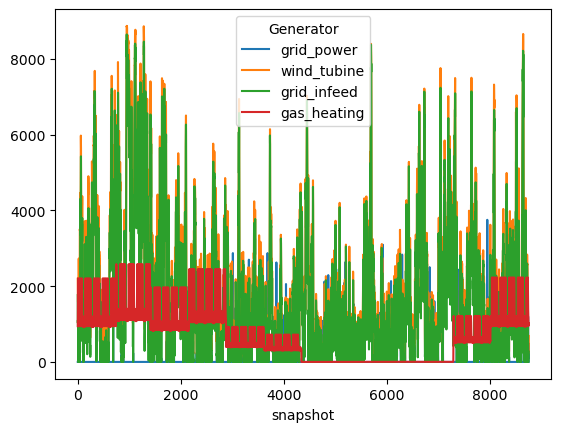

In [31]:
network.generators_t.p.plot()

<Axes: xlabel='snapshot'>

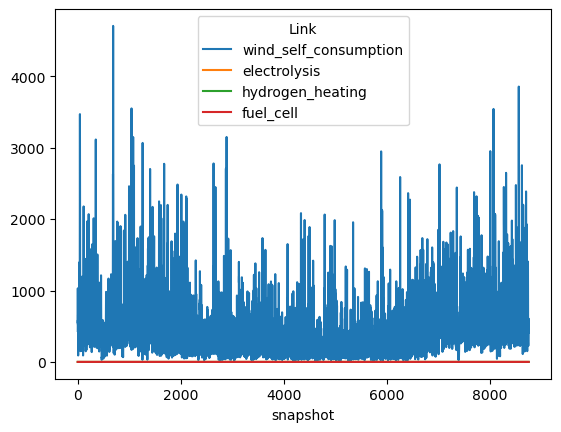

In [32]:
network.links_t.p0.plot()

Sehen Sie nach ob die Windenergieanlage Strom in das Netz eingespeist hat und geben Sie gegebenenfalls die Erlöse aus

In [33]:
print(round(network.generators_t.p['grid_infeed'].sum() * grid_infeed * -1,0), "€")

866391.0 €


Erstellen Sie ein DataFrame mit den Optimierungsergebnisse für die Leistung der Windkraftanlage, des Elektrolyseurs, der Brennstoffzelle und der Gasheizung sowie der Dimensionierung der Speicher. Fügen Sie zudem die Betriebs- und Investkosten (als Annuität) hinzu. 

In [27]:
index = (["capital cost","operational cost"] + list(network.generators.p_nom_opt.index) + 
         list(network.links.p_nom_opt.index) + list(network.stores.e_nom_opt.index))
results = ([network.statistics()["Capital Expenditure"].sum(), network.statistics()["Operational Expenditure"].sum()] +
list(network.generators.p_nom_opt) + list(network.links.p_nom_opt) + list(network.stores.e_nom_opt))
df_results = pd.DataFrame(data= results, index= index, columns=["100%"])

In [28]:
df_results

,100%
capital cost,1.368067e+06
operational cost,2.788769e+05
grid_power,6.165332e+03
wind_tubine,9.000000e+03
grid_infeed,9.000000e+03
gas_heating,2.580962e+03
wind_self_consumption,9.000000e+03
electrolysis,0.000000e+00
hydrogen_heating,0.000000e+00
fuel_cell,0.000000e+00


Berechnen Sie die emittierte Menge Kohlenstoffdioxid des Energysystems innerhalb eines Jahres

In [56]:
df_carrier = network.carriers
df_generators = network.generators.carrier

standard_co2_emissions = round((network.generators_t.p.sum()/network.generators.efficiency  * 
     pd.merge(df_carrier, df_generators, left_index = True, right_on='carrier')['co2_emissions'])).sum()

Führen Sie die Sensitivitätsanalyse für die CO2 Emissionen aus. 

In [62]:
for co2_limit in np.flip(np.arange(0, 1, 0.1)):
    print(co2_limit)
    network.global_constraints.loc['co2-limit', 'constant'] =  co2_limit * standard_co2_emissions
    network.optimize(solver_name='gurobi', method = 2, threads = 1)
    df_results[str(round(co2_limit * 100,0))+'%'] = [network.statistics()["Capital Expenditure"].sum(), network.statistics()["Operational Expenditure"].sum()] + list(network.generators.p_nom_opt) + list(network.links.p_nom_opt) + list(network.stores.e_nom_opt)


Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.9


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 551.08it/s]
INFO:linopy.io: Writing time: 1.84s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-hd5lfq0b.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-hd5lfq0b.lp


Reading time = 0.46 seconds


INFO:gurobipy:Reading time = 0.46 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x6109ad64


INFO:gurobipy:Model fingerprint: 0x6109ad64


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 2e+06]


INFO:gurobipy:  RHS range        [1e-03, 2e+06]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.54s


INFO:gurobipy:Presolve time: 0.54s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.04s


INFO:gurobipy:Ordering time: 0.04s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.36653894e+10 -3.97130566e+12  1.96e+10 6.30e-01  2.13e+08     1s


INFO:gurobipy:   0   4.36653894e+10 -3.97130566e+12  1.96e+10 6.30e-01  2.13e+08     1s


   1   3.31850362e+10 -7.34811364e+11  1.13e+10 1.42e+01  6.40e+07     1s


INFO:gurobipy:   1   3.31850362e+10 -7.34811364e+11  1.13e+10 1.42e+01  6.40e+07     1s


   2   2.95283991e+10 -2.03019363e+11  9.97e+09 1.61e+00  4.06e+07     1s


INFO:gurobipy:   2   2.95283991e+10 -2.03019363e+11  9.97e+09 1.61e+00  4.06e+07     1s


   3   9.95741909e+09 -6.79555644e+10  3.42e+09 3.45e-01  1.40e+07     2s


INFO:gurobipy:   3   9.95741909e+09 -6.79555644e+10  3.42e+09 3.45e-01  1.40e+07     2s


   4   4.11207960e+09 -4.56263065e+10  1.22e+09 2.26e-01  5.31e+06     2s


INFO:gurobipy:   4   4.11207960e+09 -4.56263065e+10  1.22e+09 2.26e-01  5.31e+06     2s


   5   1.97068410e+09 -2.58273904e+10  3.91e+08 1.22e-01  1.89e+06     2s


INFO:gurobipy:   5   1.97068410e+09 -2.58273904e+10  3.91e+08 1.22e-01  1.89e+06     2s


   6   6.98533991e+08 -8.62786621e+09  4.58e+07 3.58e-02  2.77e+05     2s


INFO:gurobipy:   6   6.98533991e+08 -8.62786621e+09  4.58e+07 3.58e-02  2.77e+05     2s


   7   4.35780238e+08 -1.19040748e+09  3.46e+06 7.59e-04  2.43e+04     2s


INFO:gurobipy:   7   4.35780238e+08 -1.19040748e+09  3.46e+06 7.59e-04  2.43e+04     2s


   8   2.29139038e+08 -7.31685825e+08  1.24e+06 1.22e-10  9.74e+03     2s


INFO:gurobipy:   8   2.29139038e+08 -7.31685825e+08  1.24e+06 1.22e-10  9.74e+03     2s


   9   2.07327944e+08 -6.75244993e+08  1.08e+06 8.74e-09  7.92e+03     2s


INFO:gurobipy:   9   2.07327944e+08 -6.75244993e+08  1.08e+06 8.74e-09  7.92e+03     2s


  10   9.75257242e+07 -3.56569383e+08  2.62e+05 1.54e-08  3.13e+03     2s


INFO:gurobipy:  10   9.75257242e+07 -3.56569383e+08  2.62e+05 1.54e-08  3.13e+03     2s


  11   6.65337497e+07 -1.36879497e+08  1.11e+05 4.93e-09  1.30e+03     3s


INFO:gurobipy:  11   6.65337497e+07 -1.36879497e+08  1.11e+05 4.93e-09  1.30e+03     3s


  12   3.41690185e+07 -7.79744446e+07  4.49e+04 2.67e-09  6.79e+02     3s


INFO:gurobipy:  12   3.41690185e+07 -7.79744446e+07  4.49e+04 2.67e-09  6.79e+02     3s


  13   2.35787189e+07 -6.29207603e+07  2.45e+04 2.20e-09  5.13e+02     3s


INFO:gurobipy:  13   2.35787189e+07 -6.29207603e+07  2.45e+04 2.20e-09  5.13e+02     3s


  14   2.25863850e+07 -4.78098310e+07  2.29e+04 1.58e-09  4.16e+02     3s


INFO:gurobipy:  14   2.25863850e+07 -4.78098310e+07  2.29e+04 1.58e-09  4.16e+02     3s


  15   1.18703060e+07 -1.94733768e+07  8.16e+03 7.05e-10  1.82e+02     3s


INFO:gurobipy:  15   1.18703060e+07 -1.94733768e+07  8.16e+03 7.05e-10  1.82e+02     3s


  16   6.30780415e+06 -5.17604454e+06  2.63e+03 2.22e-10  6.61e+01     3s


INFO:gurobipy:  16   6.30780415e+06 -5.17604454e+06  2.63e+03 2.22e-10  6.61e+01     3s


  17   4.14849913e+06 -2.00407390e+06  9.63e+02 1.16e-10  3.53e+01     3s


INFO:gurobipy:  17   4.14849913e+06 -2.00407390e+06  9.63e+02 1.16e-10  3.53e+01     3s


  18   3.31152666e+06 -1.35300780e+06  1.19e+02 1.25e-10  2.68e+01     4s


INFO:gurobipy:  18   3.31152666e+06 -1.35300780e+06  1.19e+02 1.25e-10  2.68e+01     4s


  19   2.71392076e+06 -2.18585119e+05  8.99e-02 5.64e-11  1.68e+01     4s


INFO:gurobipy:  19   2.71392076e+06 -2.18585119e+05  8.99e-02 5.64e-11  1.68e+01     4s


  20   2.37897064e+06  6.74243859e+05  5.84e-02 2.91e-11  9.78e+00     4s


INFO:gurobipy:  20   2.37897064e+06  6.74243859e+05  5.84e-02 2.91e-11  9.78e+00     4s


  21   2.00609521e+06  1.24972417e+06  2.62e-02 5.46e-11  4.34e+00     4s


INFO:gurobipy:  21   2.00609521e+06  1.24972417e+06  2.62e-02 5.46e-11  4.34e+00     4s


  22   1.83921958e+06  1.42448477e+06  1.34e-02 2.55e-11  2.38e+00     4s


INFO:gurobipy:  22   1.83921958e+06  1.42448477e+06  1.34e-02 2.55e-11  2.38e+00     4s


  23   1.76672859e+06  1.49870726e+06  8.14e-03 4.55e-13  1.54e+00     4s


INFO:gurobipy:  23   1.76672859e+06  1.49870726e+06  8.14e-03 4.55e-13  1.54e+00     4s


  24   1.72969193e+06  1.55255164e+06  5.28e-03 1.59e-12  1.02e+00     4s


INFO:gurobipy:  24   1.72969193e+06  1.55255164e+06  5.28e-03 1.59e-12  1.02e+00     4s


  25   1.69950781e+06  1.58500007e+06  3.01e-03 1.11e-15  6.56e-01     4s


INFO:gurobipy:  25   1.69950781e+06  1.58500007e+06  3.01e-03 1.11e-15  6.56e-01     4s


  26   1.68790781e+06  1.62103206e+06  2.14e-03 1.28e-15  3.83e-01     4s


INFO:gurobipy:  26   1.68790781e+06  1.62103206e+06  2.14e-03 1.28e-15  3.83e-01     4s


  27   1.67873775e+06  1.63026460e+06  1.46e-03 2.73e-12  2.78e-01     4s


INFO:gurobipy:  27   1.67873775e+06  1.63026460e+06  1.46e-03 2.73e-12  2.78e-01     4s


  28   1.67709014e+06  1.63862947e+06  1.34e-03 2.06e-13  2.20e-01     5s


INFO:gurobipy:  28   1.67709014e+06  1.63862947e+06  1.34e-03 2.06e-13  2.20e-01     5s


  29   1.67256483e+06  1.64382771e+06  9.94e-04 3.98e-12  1.65e-01     5s


INFO:gurobipy:  29   1.67256483e+06  1.64382771e+06  9.94e-04 3.98e-12  1.65e-01     5s


  30   1.66774562e+06  1.65045366e+06  6.47e-04 8.19e-12  9.91e-02     5s


INFO:gurobipy:  30   1.66774562e+06  1.65045366e+06  6.47e-04 8.19e-12  9.91e-02     5s


  31   1.66623780e+06  1.65174410e+06  5.32e-04 2.96e-12  8.31e-02     5s


INFO:gurobipy:  31   1.66623780e+06  1.65174410e+06  5.32e-04 2.96e-12  8.31e-02     5s


  32   1.66414521e+06  1.65398072e+06  3.84e-04 4.55e-12  5.83e-02     5s


INFO:gurobipy:  32   1.66414521e+06  1.65398072e+06  3.84e-04 4.55e-12  5.83e-02     5s


  33   1.66309154e+06  1.65436617e+06  3.14e-04 7.28e-12  5.00e-02     5s


INFO:gurobipy:  33   1.66309154e+06  1.65436617e+06  3.14e-04 7.28e-12  5.00e-02     5s


  34   1.66231264e+06  1.65606836e+06  2.63e-04 2.56e-13  3.58e-02     5s


INFO:gurobipy:  34   1.66231264e+06  1.65606836e+06  2.63e-04 2.56e-13  3.58e-02     5s


  35   1.66181100e+06  1.65670343e+06  2.27e-04 2.73e-12  2.93e-02     5s


INFO:gurobipy:  35   1.66181100e+06  1.65670343e+06  2.27e-04 2.73e-12  2.93e-02     5s


  36   1.66105836e+06  1.65733756e+06  1.72e-04 9.09e-13  2.13e-02     5s


INFO:gurobipy:  36   1.66105836e+06  1.65733756e+06  1.72e-04 9.09e-13  2.13e-02     5s


  37   1.66071980e+06  1.65753819e+06  1.48e-04 2.96e-12  1.82e-02     6s


INFO:gurobipy:  37   1.66071980e+06  1.65753819e+06  1.48e-04 2.96e-12  1.82e-02     6s


  38   1.66049580e+06  1.65759914e+06  1.33e-04 3.55e-14  1.66e-02     6s


INFO:gurobipy:  38   1.66049580e+06  1.65759914e+06  1.33e-04 3.55e-14  1.66e-02     6s


  39   1.66031800e+06  1.65768762e+06  1.21e-04 2.50e-12  1.51e-02     6s


INFO:gurobipy:  39   1.66031800e+06  1.65768762e+06  1.21e-04 2.50e-12  1.51e-02     6s


  40   1.65981095e+06  1.65777003e+06  8.63e-05 1.21e-13  1.17e-02     6s


INFO:gurobipy:  40   1.65981095e+06  1.65777003e+06  8.63e-05 1.21e-13  1.17e-02     6s


  41   1.65952165e+06  1.65825674e+06  6.63e-05 4.55e-12  7.25e-03     6s


INFO:gurobipy:  41   1.65952165e+06  1.65825674e+06  6.63e-05 4.55e-12  7.25e-03     6s


  42   1.65937203e+06  1.65838403e+06  5.68e-05 4.55e-12  5.66e-03     6s


INFO:gurobipy:  42   1.65937203e+06  1.65838403e+06  5.68e-05 4.55e-12  5.66e-03     6s


  43   1.65929201e+06  1.65842810e+06  5.09e-05 5.00e-12  4.95e-03     6s


INFO:gurobipy:  43   1.65929201e+06  1.65842810e+06  5.09e-05 5.00e-12  4.95e-03     6s


  44   1.65923704e+06  1.65843916e+06  4.69e-05 2.05e-12  4.57e-03     7s


INFO:gurobipy:  44   1.65923704e+06  1.65843916e+06  4.69e-05 2.05e-12  4.57e-03     7s


  45   1.65900009e+06  1.65850834e+06  2.97e-05 1.46e-11  2.82e-03     7s


INFO:gurobipy:  45   1.65900009e+06  1.65850834e+06  2.97e-05 1.46e-11  2.82e-03     7s


  46   1.65896184e+06  1.65852997e+06  2.71e-05 4.27e-11  2.48e-03     7s


INFO:gurobipy:  46   1.65896184e+06  1.65852997e+06  2.71e-05 4.27e-11  2.48e-03     7s


  47   1.65882563e+06  1.65853219e+06  1.84e-05 3.18e-11  1.68e-03     7s


INFO:gurobipy:  47   1.65882563e+06  1.65853219e+06  1.84e-05 3.18e-11  1.68e-03     7s


  48   1.65876754e+06  1.65855620e+06  1.44e-05 5.18e-11  1.21e-03     7s


INFO:gurobipy:  48   1.65876754e+06  1.65855620e+06  1.44e-05 5.18e-11  1.21e-03     7s


  49   1.65874326e+06  1.65856550e+06  1.26e-05 4.73e-11  1.02e-03     7s


INFO:gurobipy:  49   1.65874326e+06  1.65856550e+06  1.26e-05 4.73e-11  1.02e-03     7s


  50   1.65872605e+06  1.65857026e+06  1.12e-05 5.46e-12  8.93e-04     7s


INFO:gurobipy:  50   1.65872605e+06  1.65857026e+06  1.12e-05 5.46e-12  8.93e-04     7s


  51   1.65868935e+06  1.65857056e+06  8.40e-06 1.27e-11  6.81e-04     7s


INFO:gurobipy:  51   1.65868935e+06  1.65857056e+06  8.40e-06 1.27e-11  6.81e-04     7s


  52   1.65868726e+06  1.65857149e+06  8.23e-06 8.19e-12  6.64e-04     8s


INFO:gurobipy:  52   1.65868726e+06  1.65857149e+06  8.23e-06 8.19e-12  6.64e-04     8s


  53   1.65868219e+06  1.65857205e+06  7.84e-06 3.64e-12  6.31e-04     8s


INFO:gurobipy:  53   1.65868219e+06  1.65857205e+06  7.84e-06 3.64e-12  6.31e-04     8s


  54   1.65867612e+06  1.65857356e+06  7.38e-06 1.09e-11  5.88e-04     8s


INFO:gurobipy:  54   1.65867612e+06  1.65857356e+06  7.38e-06 1.09e-11  5.88e-04     8s


  55   1.65866925e+06  1.65857520e+06  6.77e-06 1.41e-12  5.39e-04     8s


INFO:gurobipy:  55   1.65866925e+06  1.65857520e+06  6.77e-06 1.41e-12  5.39e-04     8s


  56   1.65866051e+06  1.65857593e+06  6.06e-06 3.52e-12  4.85e-04     8s


INFO:gurobipy:  56   1.65866051e+06  1.65857593e+06  6.06e-06 3.52e-12  4.85e-04     8s


  57   1.65865336e+06  1.65857799e+06  5.53e-06 1.39e-12  4.32e-04     8s


INFO:gurobipy:  57   1.65865336e+06  1.65857799e+06  5.53e-06 1.39e-12  4.32e-04     8s


  58   1.65864509e+06  1.65857944e+06  4.90e-06 1.04e-12  3.76e-04     8s


INFO:gurobipy:  58   1.65864509e+06  1.65857944e+06  4.90e-06 1.04e-12  3.76e-04     8s


  59   1.65864074e+06  1.65857974e+06  4.54e-06 2.27e-12  3.50e-04     8s


INFO:gurobipy:  59   1.65864074e+06  1.65857974e+06  4.54e-06 2.27e-12  3.50e-04     8s


  60   1.65863373e+06  1.65858078e+06  4.01e-06 3.41e-12  3.04e-04     9s


INFO:gurobipy:  60   1.65863373e+06  1.65858078e+06  4.01e-06 3.41e-12  3.04e-04     9s


  61   1.65863197e+06  1.65858119e+06  3.80e-06 9.59e-13  2.91e-04     9s


INFO:gurobipy:  61   1.65863197e+06  1.65858119e+06  3.80e-06 9.59e-13  2.91e-04     9s


  62   1.65862925e+06  1.65858162e+06  3.56e-06 1.02e-12  2.73e-04     9s


INFO:gurobipy:  62   1.65862925e+06  1.65858162e+06  3.56e-06 1.02e-12  2.73e-04     9s


  63   1.65862311e+06  1.65858219e+06  3.07e-06 1.25e-12  2.35e-04     9s


INFO:gurobipy:  63   1.65862311e+06  1.65858219e+06  3.07e-06 1.25e-12  2.35e-04     9s


  64   1.65862100e+06  1.65858255e+06  2.89e-06 2.96e-12  2.20e-04     9s


INFO:gurobipy:  64   1.65862100e+06  1.65858255e+06  2.89e-06 2.96e-12  2.20e-04     9s


  65   1.65861878e+06  1.65858274e+06  2.71e-06 3.64e-12  2.07e-04     9s


INFO:gurobipy:  65   1.65861878e+06  1.65858274e+06  2.71e-06 3.64e-12  2.07e-04     9s


  66   1.65861292e+06  1.65858265e+06  2.30e-06 1.36e-12  1.74e-04     9s


INFO:gurobipy:  66   1.65861292e+06  1.65858265e+06  2.30e-06 1.36e-12  1.74e-04     9s


  67   1.65861222e+06  1.65858338e+06  2.24e-06 3.64e-12  1.65e-04     9s


INFO:gurobipy:  67   1.65861222e+06  1.65858338e+06  2.24e-06 3.64e-12  1.65e-04     9s


  68   1.65861092e+06  1.65858354e+06  2.13e-06 3.18e-12  1.57e-04    10s


INFO:gurobipy:  68   1.65861092e+06  1.65858354e+06  2.13e-06 3.18e-12  1.57e-04    10s


  69   1.65860536e+06  1.65858366e+06  1.65e-06 3.64e-12  1.24e-04    10s


INFO:gurobipy:  69   1.65860536e+06  1.65858366e+06  1.65e-06 3.64e-12  1.24e-04    10s


  70   1.65859474e+06  1.65858447e+06  8.46e-07 5.57e-12  5.89e-05    10s


INFO:gurobipy:  70   1.65859474e+06  1.65858447e+06  8.46e-07 5.57e-12  5.89e-05    10s


  71   1.65858797e+06  1.65858506e+06  2.21e-07 7.28e-12  1.67e-05    10s


INFO:gurobipy:  71   1.65858797e+06  1.65858506e+06  2.21e-07 7.28e-12  1.67e-05    10s


  72   1.65858611e+06  1.65858520e+06  1.67e-07 2.34e-13  5.19e-06    10s


INFO:gurobipy:  72   1.65858611e+06  1.65858520e+06  1.67e-07 2.34e-13  5.19e-06    10s


  73   1.65858588e+06  1.65858524e+06  9.49e-08 6.80e-13  3.68e-06    10s


INFO:gurobipy:  73   1.65858588e+06  1.65858524e+06  9.49e-08 6.80e-13  3.68e-06    10s


  74   1.65858571e+06  1.65858528e+06  6.95e-08 1.09e-11  2.51e-06    11s


INFO:gurobipy:  74   1.65858571e+06  1.65858528e+06  6.95e-08 1.09e-11  2.51e-06    11s


  75   1.65858564e+06  1.65858530e+06  6.31e-08 1.91e-11  1.94e-06    11s


INFO:gurobipy:  75   1.65858564e+06  1.65858530e+06  6.31e-08 1.91e-11  1.94e-06    11s


  76   1.65858563e+06  1.65858530e+06  6.12e-08 2.36e-11  1.87e-06    11s


INFO:gurobipy:  76   1.65858563e+06  1.65858530e+06  6.12e-08 2.36e-11  1.87e-06    11s


  77   1.65858561e+06  1.65858530e+06  5.68e-08 4.09e-11  1.74e-06    11s


INFO:gurobipy:  77   1.65858561e+06  1.65858530e+06  5.68e-08 4.09e-11  1.74e-06    11s


  78   1.65858558e+06  1.65858531e+06  1.71e-07 2.46e-11  1.52e-06    11s


INFO:gurobipy:  78   1.65858558e+06  1.65858531e+06  1.71e-07 2.46e-11  1.52e-06    11s


  79   1.65858555e+06  1.65858531e+06  3.43e-07 1.27e-11  1.35e-06    11s


INFO:gurobipy:  79   1.65858555e+06  1.65858531e+06  3.43e-07 1.27e-11  1.35e-06    11s


  80   1.65858552e+06  1.65858532e+06  4.67e-07 4.55e-12  1.13e-06    11s


INFO:gurobipy:  80   1.65858552e+06  1.65858532e+06  4.67e-07 4.55e-12  1.13e-06    11s


  81   1.65858550e+06  1.65858532e+06  3.15e-07 4.26e-12  1.01e-06    11s


INFO:gurobipy:  81   1.65858550e+06  1.65858532e+06  3.15e-07 4.26e-12  1.01e-06    11s


  82   1.65858548e+06  1.65858532e+06  2.47e-07 4.34e-12  9.06e-07    11s


INFO:gurobipy:  82   1.65858548e+06  1.65858532e+06  2.47e-07 4.34e-12  9.06e-07    11s


  83   1.65858547e+06  1.65858533e+06  2.19e-07 4.77e-12  7.99e-07    11s


INFO:gurobipy:  83   1.65858547e+06  1.65858533e+06  2.19e-07 4.77e-12  7.99e-07    11s


  84   1.65858545e+06  1.65858533e+06  2.47e-07 4.31e-12  7.23e-07    12s


INFO:gurobipy:  84   1.65858545e+06  1.65858533e+06  2.47e-07 4.31e-12  7.23e-07    12s


  85   1.65858543e+06  1.65858533e+06  3.18e-07 3.95e-12  5.97e-07    12s


INFO:gurobipy:  85   1.65858543e+06  1.65858533e+06  3.18e-07 3.95e-12  5.97e-07    12s


  86   1.65858543e+06  1.65858533e+06  3.12e-07 3.89e-12  5.82e-07    12s


INFO:gurobipy:  86   1.65858543e+06  1.65858533e+06  3.12e-07 3.89e-12  5.82e-07    12s


  87   1.65858543e+06  1.65858533e+06  3.04e-07 8.64e-12  5.55e-07    12s


INFO:gurobipy:  87   1.65858543e+06  1.65858533e+06  3.04e-07 8.64e-12  5.55e-07    12s


  88   1.65858541e+06  1.65858533e+06  1.34e-07 3.42e-12  4.63e-07    12s


INFO:gurobipy:  88   1.65858541e+06  1.65858533e+06  1.34e-07 3.42e-12  4.63e-07    12s


  89   1.65858541e+06  1.65858533e+06  1.12e-07 5.00e-12  4.21e-07    12s


INFO:gurobipy:  89   1.65858541e+06  1.65858533e+06  1.12e-07 5.00e-12  4.21e-07    12s


  90   1.65858541e+06  1.65858534e+06  1.09e-07 4.09e-12  4.05e-07    12s


INFO:gurobipy:  90   1.65858541e+06  1.65858534e+06  1.09e-07 4.09e-12  4.05e-07    12s


  91   1.65858540e+06  1.65858534e+06  1.02e-07 2.87e-12  3.80e-07    12s


INFO:gurobipy:  91   1.65858540e+06  1.65858534e+06  1.02e-07 2.87e-12  3.80e-07    12s


INFO:gurobipy:


Barrier solved model in 91 iterations and 12.41 seconds (4.92 work units)


INFO:gurobipy:Barrier solved model in 91 iterations and 12.41 seconds (4.92 work units)


Optimal objective 1.65858540e+06


INFO:gurobipy:Optimal objective 1.65858540e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   34730 DPushes remaining with DInf 2.2881489e-06                12s


INFO:gurobipy:   34730 DPushes remaining with DInf 2.2881489e-06                12s


    3740 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:    3740 DPushes remaining with DInf 0.0000000e+00                16s


       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                18s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   32013 PPushes remaining with PInf 7.7223554e-01                18s


INFO:gurobipy:   32013 PPushes remaining with PInf 7.7223554e-01                18s


    8872 PPushes remaining with PInf 6.3858683e-01                27s


INFO:gurobipy:    8872 PPushes remaining with PInf 6.3858683e-01                27s


       0 PPushes remaining with PInf 2.8098203e-03                28s


INFO:gurobipy:       0 PPushes remaining with PInf 2.8098203e-03                28s


INFO:gurobipy:


  Push phase complete: Pinf 2.8098203e-03, Dinf 1.1097533e+03     28s


INFO:gurobipy:  Push phase complete: Pinf 2.8098203e-03, Dinf 1.1097533e+03     28s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   55446    1.6585987e+06   0.000000e+00   1.109753e+03     28s


INFO:gurobipy:   55446    1.6585987e+06   0.000000e+00   1.109753e+03     28s


   56309    1.6585853e+06   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:   56309    1.6585853e+06   0.000000e+00   0.000000e+00     29s


   56309    1.6585853e+06   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:   56309    1.6585853e+06   0.000000e+00   0.000000e+00     29s


INFO:gurobipy:


Root relaxation: objective 1.658585e+06, 56309 iterations, 28.19 seconds (19.43 work units)


INFO:gurobipy:Root relaxation: objective 1.658585e+06, 56309 iterations, 28.19 seconds (19.43 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 1658585.35    0    1          - 1658585.35      -     -   29s


INFO:gurobipy:     0     0 1658585.35    0    1          - 1658585.35      -     -   29s


H    0     0                    1660839.9550 1658585.35  0.14%     -   31s


INFO:gurobipy:H    0     0                    1660839.9550 1658585.35  0.14%     -   31s


     0     0 1658585.35    0    1 1660839.95 1658585.35  0.14%     -   32s


INFO:gurobipy:     0     0 1658585.35    0    1 1660839.95 1658585.35  0.14%     -   32s


     0     2 1658586.64    0    1 1660839.95 1658586.64  0.14%     -   32s


INFO:gurobipy:     0     2 1658586.64    0    1 1660839.95 1658586.64  0.14%     -   32s


     2     0     cutoff    1      1660839.95 1660839.95  0.00%  3605   46s


INFO:gurobipy:     2     0     cutoff    1      1660839.95 1660839.95  0.00%  3605   46s


INFO:gurobipy:


Explored 3 nodes (63519 simplex iterations) in 46.10 seconds (46.72 work units)


INFO:gurobipy:Explored 3 nodes (63519 simplex iterations) in 46.10 seconds (46.72 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 1.66084e+06 


INFO:gurobipy:Solution count 1: 1.66084e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.660839954991e+06, best bound 1.660839954991e+06, gap 0.0000%


INFO:gurobipy:Best objective 1.660839954991e+06, best bound 1.660839954991e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.66e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.8


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 596.21it/s]
INFO:linopy.io: Writing time: 1.8s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-t1yydmz6.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-t1yydmz6.lp


Reading time = 0.46 seconds


INFO:gurobipy:Reading time = 0.46 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x0ce4503d


INFO:gurobipy:Model fingerprint: 0x0ce4503d


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 2e+06]


INFO:gurobipy:  RHS range        [1e-03, 2e+06]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.56s


INFO:gurobipy:Presolve time: 0.56s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   3.88131924e+10 -3.53008697e+12  1.74e+10 6.30e-01  1.89e+08     1s


INFO:gurobipy:   0   3.88131924e+10 -3.53008697e+12  1.74e+10 6.30e-01  1.89e+08     1s


   1   2.94974604e+10 -6.53233601e+11  1.00e+10 1.42e+01  5.69e+07     1s


INFO:gurobipy:   1   2.94974604e+10 -6.53233601e+11  1.00e+10 1.42e+01  5.69e+07     1s


   2   2.62472600e+10 -1.80526292e+11  8.86e+09 1.61e+00  3.61e+07     1s


INFO:gurobipy:   2   2.62472600e+10 -1.80526292e+11  8.86e+09 1.61e+00  3.61e+07     1s


   3   8.85172097e+09 -6.04779579e+10  3.04e+09 3.45e-01  1.25e+07     2s


INFO:gurobipy:   3   8.85172097e+09 -6.04779579e+10  3.04e+09 3.45e-01  1.25e+07     2s


   4   3.65625013e+09 -4.06179680e+10  1.08e+09 2.26e-01  4.72e+06     2s


INFO:gurobipy:   4   3.65625013e+09 -4.06179680e+10  1.08e+09 2.26e-01  4.72e+06     2s


   5   1.75193370e+09 -2.30172103e+10  3.47e+08 1.22e-01  1.68e+06     2s


INFO:gurobipy:   5   1.75193370e+09 -2.30172103e+10  3.47e+08 1.22e-01  1.68e+06     2s


   6   6.22166173e+08 -7.72854081e+09  4.06e+07 3.58e-02  2.46e+05     2s


INFO:gurobipy:   6   6.22166173e+08 -7.72854081e+09  4.06e+07 3.58e-02  2.46e+05     2s


   7   3.90382437e+08 -1.10594795e+09  3.27e+06 7.41e-04  2.27e+04     2s


INFO:gurobipy:   7   3.90382437e+08 -1.10594795e+09  3.27e+06 7.41e-04  2.27e+04     2s


   8   2.12733424e+08 -6.80732048e+08  1.25e+06 1.05e-10  9.33e+03     2s


INFO:gurobipy:   8   2.12733424e+08 -6.80732048e+08  1.25e+06 1.05e-10  9.33e+03     2s


   9   1.94400903e+08 -6.54869634e+08  1.11e+06 2.45e-08  7.75e+03     2s


INFO:gurobipy:   9   1.94400903e+08 -6.54869634e+08  1.11e+06 2.45e-08  7.75e+03     2s


  10   9.28558821e+07 -3.67147229e+08  2.81e+05 1.74e-08  3.21e+03     2s


INFO:gurobipy:  10   9.28558821e+07 -3.67147229e+08  2.81e+05 1.74e-08  3.21e+03     2s


  11   6.61109130e+07 -1.59685538e+08  1.33e+05 4.30e-09  1.46e+03     3s


INFO:gurobipy:  11   6.61109130e+07 -1.59685538e+08  1.33e+05 4.30e-09  1.46e+03     3s


  12   3.03872991e+07 -6.63614286e+07  4.90e+04 1.76e-09  5.88e+02     3s


INFO:gurobipy:  12   3.03872991e+07 -6.63614286e+07  4.90e+04 1.76e-09  5.88e+02     3s


  13   1.74931318e+07 -5.58378258e+07  1.90e+04 1.54e-09  4.32e+02     3s


INFO:gurobipy:  13   1.74931318e+07 -5.58378258e+07  1.90e+04 1.54e-09  4.32e+02     3s


  14   1.42729155e+07 -3.33840799e+07  1.33e+04 9.97e-10  2.78e+02     3s


INFO:gurobipy:  14   1.42729155e+07 -3.33840799e+07  1.33e+04 9.97e-10  2.78e+02     3s


  15   9.87764110e+06 -2.23184521e+07  7.31e+03 6.71e-10  1.87e+02     3s


INFO:gurobipy:  15   9.87764110e+06 -2.23184521e+07  7.31e+03 6.71e-10  1.87e+02     3s


  16   6.96371381e+06 -1.16169811e+07  3.86e+03 4.21e-10  1.07e+02     3s


INFO:gurobipy:  16   6.96371381e+06 -1.16169811e+07  3.86e+03 4.21e-10  1.07e+02     3s


  17   4.91413377e+06 -6.16528231e+06  1.92e+03 2.32e-10  6.37e+01     3s


INFO:gurobipy:  17   4.91413377e+06 -6.16528231e+06  1.92e+03 2.32e-10  6.37e+01     3s


  18   3.70612982e+06 -3.70109074e+06  9.61e+02 1.68e-10  4.25e+01     4s


INFO:gurobipy:  18   3.70612982e+06 -3.70109074e+06  9.61e+02 1.68e-10  4.25e+01     4s


  19   2.81971993e+06 -2.21778027e+06  3.52e+02 1.53e-10  2.89e+01     4s


INFO:gurobipy:  19   2.81971993e+06 -2.21778027e+06  3.52e+02 1.53e-10  2.89e+01     4s


  20   2.32704371e+06 -8.94051464e+05  9.20e+01 8.37e-11  1.85e+01     4s


INFO:gurobipy:  20   2.32704371e+06 -8.94051464e+05  9.20e+01 8.37e-11  1.85e+01     4s


  21   2.06139849e+06  1.11245203e+06  2.67e+01 7.55e-15  5.44e+00     4s


INFO:gurobipy:  21   2.06139849e+06  1.11245203e+06  2.67e+01 7.55e-15  5.44e+00     4s


  22   1.95045396e+06  1.30235649e+06  1.90e+01 4.44e-15  3.72e+00     4s


INFO:gurobipy:  22   1.95045396e+06  1.30235649e+06  1.90e+01 4.44e-15  3.72e+00     4s


  23   1.85728191e+06  1.39762646e+06  1.20e+01 3.33e-15  2.64e+00     4s


INFO:gurobipy:  23   1.85728191e+06  1.39762646e+06  1.20e+01 3.33e-15  2.64e+00     4s


  24   1.77834687e+06  1.51554176e+06  6.22e+00 1.78e-15  1.51e+00     4s


INFO:gurobipy:  24   1.77834687e+06  1.51554176e+06  6.22e+00 1.78e-15  1.51e+00     4s


  25   1.74844579e+06  1.58712351e+06  4.51e+00 1.73e-11  9.25e-01     4s


INFO:gurobipy:  25   1.74844579e+06  1.58712351e+06  4.51e+00 1.73e-11  9.25e-01     4s


  26   1.73085043e+06  1.61856145e+06  3.31e+00 1.42e-13  6.44e-01     4s


INFO:gurobipy:  26   1.73085043e+06  1.61856145e+06  3.31e+00 1.42e-13  6.44e-01     4s


  27   1.71985362e+06  1.63243075e+06  2.57e+00 7.82e-14  5.01e-01     5s


INFO:gurobipy:  27   1.71985362e+06  1.63243075e+06  2.57e+00 7.82e-14  5.01e-01     5s


  28   1.71335968e+06  1.64280555e+06  2.12e+00 1.71e-12  4.04e-01     5s


INFO:gurobipy:  28   1.71335968e+06  1.64280555e+06  2.12e+00 1.71e-12  4.04e-01     5s


  29   1.70443002e+06  1.65503819e+06  1.72e+00 2.96e-12  2.83e-01     5s


INFO:gurobipy:  29   1.70443002e+06  1.65503819e+06  1.72e+00 2.96e-12  2.83e-01     5s


  30   1.69805938e+06  1.66675645e+06  1.20e+00 1.16e-12  1.79e-01     5s


INFO:gurobipy:  30   1.69805938e+06  1.66675645e+06  1.20e+00 1.16e-12  1.79e-01     5s


  31   1.69439290e+06  1.67134822e+06  1.01e+00 1.36e-11  1.32e-01     5s


INFO:gurobipy:  31   1.69439290e+06  1.67134822e+06  1.01e+00 1.36e-11  1.32e-01     5s


  32   1.69313905e+06  1.67238941e+06  9.58e-01 8.19e-12  1.19e-01     5s


INFO:gurobipy:  32   1.69313905e+06  1.67238941e+06  9.58e-01 8.19e-12  1.19e-01     5s


  33   1.69235514e+06  1.67331434e+06  8.98e-01 6.54e-13  1.09e-01     5s


INFO:gurobipy:  33   1.69235514e+06  1.67331434e+06  8.98e-01 6.54e-13  1.09e-01     5s


  34   1.68863139e+06  1.67599737e+06  6.43e-01 3.69e-13  7.24e-02     5s


INFO:gurobipy:  34   1.68863139e+06  1.67599737e+06  6.43e-01 3.69e-13  7.24e-02     5s


  35   1.68737943e+06  1.67713044e+06  5.40e-01 4.09e-12  5.88e-02     5s


INFO:gurobipy:  35   1.68737943e+06  1.67713044e+06  5.40e-01 4.09e-12  5.88e-02     5s


  36   1.68518001e+06  1.67798593e+06  3.95e-01 3.13e-13  4.12e-02     5s


INFO:gurobipy:  36   1.68518001e+06  1.67798593e+06  3.95e-01 3.13e-13  4.12e-02     5s


  37   1.68485454e+06  1.67851746e+06  3.88e-01 2.27e-13  3.63e-02     6s


INFO:gurobipy:  37   1.68485454e+06  1.67851746e+06  3.88e-01 2.27e-13  3.63e-02     6s


  38   1.68341986e+06  1.67901212e+06  2.56e-01 1.64e-11  2.53e-02     6s


INFO:gurobipy:  38   1.68341986e+06  1.67901212e+06  2.56e-01 1.64e-11  2.53e-02     6s


  39   1.68301967e+06  1.67942717e+06  2.43e-01 5.46e-12  2.06e-02     6s


INFO:gurobipy:  39   1.68301967e+06  1.67942717e+06  2.43e-01 5.46e-12  2.06e-02     6s


  40   1.68290895e+06  1.67952045e+06  2.38e-01 9.24e-14  1.94e-02     6s


INFO:gurobipy:  40   1.68290895e+06  1.67952045e+06  2.38e-01 9.24e-14  1.94e-02     6s


  41   1.68262625e+06  1.67973915e+06  2.09e-01 2.27e-12  1.66e-02     6s


INFO:gurobipy:  41   1.68262625e+06  1.67973915e+06  2.09e-01 2.27e-12  1.66e-02     6s


  42   1.68233968e+06  1.67978601e+06  1.90e-01 6.37e-12  1.46e-02     6s


INFO:gurobipy:  42   1.68233968e+06  1.67978601e+06  1.90e-01 6.37e-12  1.46e-02     6s


  43   1.68210814e+06  1.67987344e+06  1.66e-01 2.09e-11  1.28e-02     7s


INFO:gurobipy:  43   1.68210814e+06  1.67987344e+06  1.66e-01 2.09e-11  1.28e-02     7s


  44   1.68192482e+06  1.67988234e+06  1.53e-01 9.09e-12  1.17e-02     7s


INFO:gurobipy:  44   1.68192482e+06  1.67988234e+06  1.53e-01 9.09e-12  1.17e-02     7s


  45   1.68160895e+06  1.67995588e+06  1.29e-01 1.18e-11  9.48e-03     7s


INFO:gurobipy:  45   1.68160895e+06  1.67995588e+06  1.29e-01 1.18e-11  9.48e-03     7s


  46   1.68133935e+06  1.68002347e+06  9.73e-02 3.41e-12  7.54e-03     7s


INFO:gurobipy:  46   1.68133935e+06  1.68002347e+06  9.73e-02 3.41e-12  7.54e-03     7s


  47   1.68119922e+06  1.68012940e+06  8.55e-02 2.63e-13  6.13e-03     7s


INFO:gurobipy:  47   1.68119922e+06  1.68012940e+06  8.55e-02 2.63e-13  6.13e-03     7s


  48   1.68116125e+06  1.68015633e+06  8.24e-02 3.64e-12  5.76e-03     7s


INFO:gurobipy:  48   1.68116125e+06  1.68015633e+06  8.24e-02 3.64e-12  5.76e-03     7s


  49   1.68111231e+06  1.68018325e+06  7.81e-02 2.73e-12  5.33e-03     7s


INFO:gurobipy:  49   1.68111231e+06  1.68018325e+06  7.81e-02 2.73e-12  5.33e-03     7s


  50   1.68108302e+06  1.68021912e+06  7.54e-02 2.61e-12  4.95e-03     7s


INFO:gurobipy:  50   1.68108302e+06  1.68021912e+06  7.54e-02 2.61e-12  4.95e-03     7s


  51   1.68097792e+06  1.68028130e+06  6.30e-02 2.05e-12  3.99e-03     7s


INFO:gurobipy:  51   1.68097792e+06  1.68028130e+06  6.30e-02 2.05e-12  3.99e-03     7s


  52   1.68093044e+06  1.68031514e+06  5.80e-02 3.18e-12  3.53e-03     8s


INFO:gurobipy:  52   1.68093044e+06  1.68031514e+06  5.80e-02 3.18e-12  3.53e-03     8s


  53   1.68086444e+06  1.68034501e+06  5.07e-02 5.46e-12  2.98e-03     8s


INFO:gurobipy:  53   1.68086444e+06  1.68034501e+06  5.07e-02 5.46e-12  2.98e-03     8s


  54   1.68085038e+06  1.68035195e+06  4.80e-02 3.64e-12  2.86e-03     8s


INFO:gurobipy:  54   1.68085038e+06  1.68035195e+06  4.80e-02 3.64e-12  2.86e-03     8s


  55   1.68081874e+06  1.68037369e+06  4.39e-02 1.56e-12  2.55e-03     8s


INFO:gurobipy:  55   1.68081874e+06  1.68037369e+06  4.39e-02 1.56e-12  2.55e-03     8s


  56   1.68077662e+06  1.68039868e+06  3.88e-02 2.76e-12  2.17e-03     8s


INFO:gurobipy:  56   1.68077662e+06  1.68039868e+06  3.88e-02 2.76e-12  2.17e-03     8s


  57   1.68076404e+06  1.68039945e+06  3.70e-02 4.55e-12  2.09e-03     8s


INFO:gurobipy:  57   1.68076404e+06  1.68039945e+06  3.70e-02 4.55e-12  2.09e-03     8s


  58   1.68074266e+06  1.68040691e+06  3.43e-02 2.99e-12  1.92e-03     8s


INFO:gurobipy:  58   1.68074266e+06  1.68040691e+06  3.43e-02 2.99e-12  1.92e-03     8s


  59   1.68072333e+06  1.68042418e+06  3.21e-02 3.42e-12  1.71e-03     8s


INFO:gurobipy:  59   1.68072333e+06  1.68042418e+06  3.21e-02 3.42e-12  1.71e-03     8s


  60   1.68070038e+06  1.68042814e+06  2.86e-02 3.87e-12  1.56e-03     8s


INFO:gurobipy:  60   1.68070038e+06  1.68042814e+06  2.86e-02 3.87e-12  1.56e-03     8s


  61   1.68069038e+06  1.68043487e+06  2.73e-02 3.19e-12  1.46e-03     9s


INFO:gurobipy:  61   1.68069038e+06  1.68043487e+06  2.73e-02 3.19e-12  1.46e-03     9s


  62   1.68068728e+06  1.68045306e+06  2.69e-02 2.73e-12  1.34e-03     9s


INFO:gurobipy:  62   1.68068728e+06  1.68045306e+06  2.69e-02 2.73e-12  1.34e-03     9s


  63   1.68064731e+06  1.68046622e+06  1.97e-02 2.30e-12  1.04e-03     9s


INFO:gurobipy:  63   1.68064731e+06  1.68046622e+06  1.97e-02 2.30e-12  1.04e-03     9s


  64   1.68061593e+06  1.68047102e+06  1.50e-02 4.77e-12  8.31e-04     9s


INFO:gurobipy:  64   1.68061593e+06  1.68047102e+06  1.50e-02 4.77e-12  8.31e-04     9s


  65   1.68061080e+06  1.68047767e+06  1.43e-02 2.73e-12  7.63e-04     9s


INFO:gurobipy:  65   1.68061080e+06  1.68047767e+06  1.43e-02 2.73e-12  7.63e-04     9s


  66   1.68059508e+06  1.68048043e+06  1.19e-02 8.64e-12  6.57e-04     9s


INFO:gurobipy:  66   1.68059508e+06  1.68048043e+06  1.19e-02 8.64e-12  6.57e-04     9s


  67   1.68058797e+06  1.68048906e+06  1.10e-02 4.09e-12  5.67e-04     9s


INFO:gurobipy:  67   1.68058797e+06  1.68048906e+06  1.10e-02 4.09e-12  5.67e-04     9s


  68   1.68058625e+06  1.68049113e+06  1.07e-02 1.92e-12  5.45e-04     9s


INFO:gurobipy:  68   1.68058625e+06  1.68049113e+06  1.07e-02 1.92e-12  5.45e-04     9s


  69   1.68057577e+06  1.68049341e+06  8.92e-03 2.03e-12  4.72e-04     9s


INFO:gurobipy:  69   1.68057577e+06  1.68049341e+06  8.92e-03 2.03e-12  4.72e-04     9s


  70   1.68056324e+06  1.68049679e+06  7.00e-03 3.18e-12  3.81e-04    10s


INFO:gurobipy:  70   1.68056324e+06  1.68049679e+06  7.00e-03 3.18e-12  3.81e-04    10s


  71   1.68055872e+06  1.68049724e+06  6.27e-03 2.51e-12  3.52e-04    10s


INFO:gurobipy:  71   1.68055872e+06  1.68049724e+06  6.27e-03 2.51e-12  3.52e-04    10s


  72   1.68055345e+06  1.68049845e+06  5.45e-03 2.61e-12  3.15e-04    10s


INFO:gurobipy:  72   1.68055345e+06  1.68049845e+06  5.45e-03 2.61e-12  3.15e-04    10s


  73   1.68055296e+06  1.68050141e+06  5.37e-03 2.43e-12  2.95e-04    10s


INFO:gurobipy:  73   1.68055296e+06  1.68050141e+06  5.37e-03 2.43e-12  2.95e-04    10s


  74   1.68055043e+06  1.68050295e+06  5.00e-03 2.10e-12  2.72e-04    10s


INFO:gurobipy:  74   1.68055043e+06  1.68050295e+06  5.00e-03 2.10e-12  2.72e-04    10s


  75   1.68054760e+06  1.68050530e+06  4.57e-03 5.46e-12  2.43e-04    11s


INFO:gurobipy:  75   1.68054760e+06  1.68050530e+06  4.57e-03 5.46e-12  2.43e-04    11s


  76   1.68054276e+06  1.68050735e+06  3.82e-03 7.73e-12  2.03e-04    11s


INFO:gurobipy:  76   1.68054276e+06  1.68050735e+06  3.82e-03 7.73e-12  2.03e-04    11s


  77   1.68054117e+06  1.68050890e+06  3.58e-03 2.44e-12  1.85e-04    11s


INFO:gurobipy:  77   1.68054117e+06  1.68050890e+06  3.58e-03 2.44e-12  1.85e-04    11s


  78   1.68053272e+06  1.68050995e+06  2.14e-03 2.00e-11  1.31e-04    11s


INFO:gurobipy:  78   1.68053272e+06  1.68050995e+06  2.14e-03 2.00e-11  1.31e-04    11s


  79   1.68053193e+06  1.68051065e+06  2.01e-03 9.09e-12  1.22e-04    11s


INFO:gurobipy:  79   1.68053193e+06  1.68051065e+06  2.01e-03 9.09e-12  1.22e-04    11s


  80   1.68052863e+06  1.68051134e+06  1.38e-03 1.46e-11  9.91e-05    11s


INFO:gurobipy:  80   1.68052863e+06  1.68051134e+06  1.38e-03 1.46e-11  9.91e-05    11s


  81   1.68052790e+06  1.68051150e+06  1.27e-03 3.66e-12  9.40e-05    11s


INFO:gurobipy:  81   1.68052790e+06  1.68051150e+06  1.27e-03 3.66e-12  9.40e-05    11s


  82   1.68052718e+06  1.68051258e+06  1.13e-03 5.46e-12  8.37e-05    11s


INFO:gurobipy:  82   1.68052718e+06  1.68051258e+06  1.13e-03 5.46e-12  8.37e-05    11s


  83   1.68052606e+06  1.68051289e+06  9.28e-04 1.27e-11  7.55e-05    11s


INFO:gurobipy:  83   1.68052606e+06  1.68051289e+06  9.28e-04 1.27e-11  7.55e-05    11s


  84   1.68052566e+06  1.68051339e+06  8.71e-04 1.64e-11  7.03e-05    12s


INFO:gurobipy:  84   1.68052566e+06  1.68051339e+06  8.71e-04 1.64e-11  7.03e-05    12s


  85   1.68052525e+06  1.68051450e+06  7.83e-04 3.11e-12  6.16e-05    12s


INFO:gurobipy:  85   1.68052525e+06  1.68051450e+06  7.83e-04 3.11e-12  6.16e-05    12s


  86   1.68052380e+06  1.68051458e+06  5.52e-04 2.95e-12  5.28e-05    12s


INFO:gurobipy:  86   1.68052380e+06  1.68051458e+06  5.52e-04 2.95e-12  5.28e-05    12s


  87   1.68052324e+06  1.68051616e+06  4.68e-04 2.27e-11  4.05e-05    12s


INFO:gurobipy:  87   1.68052324e+06  1.68051616e+06  4.68e-04 2.27e-11  4.05e-05    12s


  88   1.68052318e+06  1.68051635e+06  4.56e-04 1.46e-11  3.92e-05    12s


INFO:gurobipy:  88   1.68052318e+06  1.68051635e+06  4.56e-04 1.46e-11  3.92e-05    12s


  89   1.68052288e+06  1.68051736e+06  4.03e-04 1.34e-11  3.16e-05    12s


INFO:gurobipy:  89   1.68052288e+06  1.68051736e+06  4.03e-04 1.34e-11  3.16e-05    12s


  90   1.68052245e+06  1.68051738e+06  3.29e-04 1.50e-11  2.91e-05    12s


INFO:gurobipy:  90   1.68052245e+06  1.68051738e+06  3.29e-04 1.50e-11  2.91e-05    12s


  91   1.68052227e+06  1.68051751e+06  3.03e-04 3.19e-11  2.73e-05    12s


INFO:gurobipy:  91   1.68052227e+06  1.68051751e+06  3.03e-04 3.19e-11  2.73e-05    12s


  92   1.68052222e+06  1.68051781e+06  2.92e-04 2.91e-11  2.53e-05    12s


INFO:gurobipy:  92   1.68052222e+06  1.68051781e+06  2.92e-04 2.91e-11  2.53e-05    12s


  93   1.68052163e+06  1.68051838e+06  1.71e-04 1.68e-11  1.86e-05    13s


INFO:gurobipy:  93   1.68052163e+06  1.68051838e+06  1.71e-04 1.68e-11  1.86e-05    13s


  94   1.68052120e+06  1.68051841e+06  1.03e-04 1.66e-11  1.60e-05    13s


INFO:gurobipy:  94   1.68052120e+06  1.68051841e+06  1.03e-04 1.66e-11  1.60e-05    13s


  95   1.68052115e+06  1.68051851e+06  9.67e-05 5.25e-11  1.51e-05    13s


INFO:gurobipy:  95   1.68052115e+06  1.68051851e+06  9.67e-05 5.25e-11  1.51e-05    13s


  96   1.68052111e+06  1.68051856e+06  9.23e-05 8.33e-11  1.46e-05    13s


INFO:gurobipy:  96   1.68052111e+06  1.68051856e+06  9.23e-05 8.33e-11  1.46e-05    13s


  97   1.68052109e+06  1.68051863e+06  8.84e-05 7.57e-11  1.40e-05    13s


INFO:gurobipy:  97   1.68052109e+06  1.68051863e+06  8.84e-05 7.57e-11  1.40e-05    13s


  98   1.68052105e+06  1.68051872e+06  8.16e-05 7.52e-11  1.33e-05    13s


INFO:gurobipy:  98   1.68052105e+06  1.68051872e+06  8.16e-05 7.52e-11  1.33e-05    13s


  99   1.68052096e+06  1.68051950e+06  6.81e-05 5.29e-11  8.38e-06    13s


INFO:gurobipy:  99   1.68052096e+06  1.68051950e+06  6.81e-05 5.29e-11  8.38e-06    13s


 100   1.68052076e+06  1.68052019e+06  3.21e-05 1.77e-11  3.31e-06    14s


INFO:gurobipy: 100   1.68052076e+06  1.68052019e+06  3.21e-05 1.77e-11  3.31e-06    14s


 101   1.68052066e+06  1.68052030e+06  1.69e-05 2.27e-11  2.08e-06    14s


INFO:gurobipy: 101   1.68052066e+06  1.68052030e+06  1.69e-05 2.27e-11  2.08e-06    14s


 102   1.68052062e+06  1.68052038e+06  1.11e-05 2.00e-11  1.39e-06    14s


INFO:gurobipy: 102   1.68052062e+06  1.68052038e+06  1.11e-05 2.00e-11  1.39e-06    14s


 103   1.68052060e+06  1.68052042e+06  7.65e-06 7.05e-12  9.88e-07    14s


INFO:gurobipy: 103   1.68052060e+06  1.68052042e+06  7.65e-06 7.05e-12  9.88e-07    14s


 104   1.68052058e+06  1.68052043e+06  4.97e-06 1.73e-11  8.48e-07    14s


INFO:gurobipy: 104   1.68052058e+06  1.68052043e+06  4.97e-06 1.73e-11  8.48e-07    14s


 105   1.68052057e+06  1.68052047e+06  4.04e-06 3.11e-12  5.83e-07    14s


INFO:gurobipy: 105   1.68052057e+06  1.68052047e+06  4.04e-06 3.11e-12  5.83e-07    14s


 106   1.68052055e+06  1.68052051e+06  1.77e-06 2.24e-12  2.50e-07    14s


INFO:gurobipy: 106   1.68052055e+06  1.68052051e+06  1.77e-06 2.24e-12  2.50e-07    14s


 107   1.68052055e+06  1.68052052e+06  7.39e-07 1.39e-12  1.47e-07    14s


INFO:gurobipy: 107   1.68052055e+06  1.68052052e+06  7.39e-07 1.39e-12  1.47e-07    14s


 108   1.68052054e+06  1.68052053e+06  1.88e-07 2.73e-12  4.84e-08    15s


INFO:gurobipy: 108   1.68052054e+06  1.68052053e+06  1.88e-07 2.73e-12  4.84e-08    15s


 109   1.68052054e+06  1.68052053e+06  8.01e-08 5.46e-12  3.14e-08    15s


INFO:gurobipy: 109   1.68052054e+06  1.68052053e+06  8.01e-08 5.46e-12  3.14e-08    15s


INFO:gurobipy:


Barrier solved model in 109 iterations and 14.72 seconds (5.77 work units)


INFO:gurobipy:Barrier solved model in 109 iterations and 14.72 seconds (5.77 work units)


Optimal objective 1.68052054e+06


INFO:gurobipy:Optimal objective 1.68052054e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   31651 DPushes remaining with DInf 1.3271067e-04                15s


INFO:gurobipy:   31651 DPushes remaining with DInf 1.3271067e-04                15s


    3520 DPushes remaining with DInf 0.0000000e+00                15s


INFO:gurobipy:    3520 DPushes remaining with DInf 0.0000000e+00                15s


       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                16s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


   13532 PPushes remaining with PInf 1.7331802e-02                16s


INFO:gurobipy:   13532 PPushes remaining with PInf 1.7331802e-02                16s


       0 PPushes remaining with PInf 9.9009901e-04                20s


INFO:gurobipy:       0 PPushes remaining with PInf 9.9009901e-04                20s


INFO:gurobipy:


  Push phase complete: Pinf 9.9009901e-04, Dinf 2.6365804e+00     20s


INFO:gurobipy:  Push phase complete: Pinf 9.9009901e-04, Dinf 2.6365804e+00     20s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   33361    1.6805205e+06   0.000000e+00   2.636580e+00     20s


INFO:gurobipy:   33361    1.6805205e+06   0.000000e+00   2.636580e+00     20s


   33365    1.6805205e+06   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:   33365    1.6805205e+06   0.000000e+00   0.000000e+00     20s


   33365    1.6805205e+06   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:   33365    1.6805205e+06   0.000000e+00   0.000000e+00     20s


INFO:gurobipy:


Root relaxation: objective 1.680521e+06, 33365 iterations, 19.33 seconds (12.82 work units)


INFO:gurobipy:Root relaxation: objective 1.680521e+06, 33365 iterations, 19.33 seconds (12.82 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


     0     0 1680520.54    0    1          - 1680520.54      -     -   20s


INFO:gurobipy:     0     0 1680520.54    0    1          - 1680520.54      -     -   20s


H    0     0                    1680801.8140 1680520.54  0.02%     -   21s


INFO:gurobipy:H    0     0                    1680801.8140 1680520.54  0.02%     -   21s


     0     0          -    0      1680801.81 1680636.67  0.01%     -   21s


INFO:gurobipy:     0     0          -    0      1680801.81 1680636.67  0.01%     -   21s


INFO:gurobipy:


Explored 1 nodes (33401 simplex iterations) in 21.94 seconds (15.30 work units)


INFO:gurobipy:Explored 1 nodes (33401 simplex iterations) in 21.94 seconds (15.30 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 1.6808e+06 


INFO:gurobipy:Solution count 1: 1.6808e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.680801813964e+06, best bound 1.680636672212e+06, gap 0.0098%


INFO:gurobipy:Best objective 1.680801813964e+06, best bound 1.680636672212e+06, gap 0.0098%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.68e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.7000000000000001


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 584.08it/s]
INFO:linopy.io: Writing time: 1.47s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-sdrelq2_.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-sdrelq2_.lp


Reading time = 0.41 seconds


INFO:gurobipy:Reading time = 0.41 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0xb4207acf


INFO:gurobipy:Model fingerprint: 0xb4207acf


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 1e+06]


INFO:gurobipy:  RHS range        [1e-03, 1e+06]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.48s


INFO:gurobipy:Presolve time: 0.48s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.14544343e+09 -4.28808296e+08  4.63e+08 5.90e-01  3.90e+06     1s


INFO:gurobipy:   0   1.14544343e+09 -4.28808296e+08  4.63e+08 5.90e-01  3.90e+06     1s


   1   8.59648339e+08 -7.79775186e+08  2.79e+08 1.11e+01  1.29e+06     1s


INFO:gurobipy:   1   8.59648339e+08 -7.79775186e+08  2.79e+08 1.11e+01  1.29e+06     1s


   2   7.06512986e+08 -8.09751266e+08  2.15e+08 2.31e+00  9.31e+05     2s


INFO:gurobipy:   2   7.06512986e+08 -8.09751266e+08  2.15e+08 2.31e+00  9.31e+05     2s


   3   1.15375891e+08 -8.60469746e+08  3.29e+07 4.50e-01  1.54e+05     2s


INFO:gurobipy:   3   1.15375891e+08 -8.60469746e+08  3.29e+07 4.50e-01  1.54e+05     2s


   4   4.77894307e+07 -7.89034777e+08  7.61e+06 2.13e-01  4.13e+04     2s


INFO:gurobipy:   4   4.77894307e+07 -7.89034777e+08  7.61e+06 2.13e-01  4.13e+04     2s


   5   3.27086070e+07 -6.30159915e+08  2.42e+06 8.16e-02  1.51e+04     2s


INFO:gurobipy:   5   3.27086070e+07 -6.30159915e+08  2.42e+06 8.16e-02  1.51e+04     2s


   6   2.82223673e+07 -3.63016892e+08  9.62e+05 1.46e-02  5.31e+03     2s


INFO:gurobipy:   6   2.82223673e+07 -3.63016892e+08  9.62e+05 1.46e-02  5.31e+03     2s


   7   2.22723643e+07 -2.16011985e+08  3.26e+05 4.72e-03  2.17e+03     2s


INFO:gurobipy:   7   2.22723643e+07 -2.16011985e+08  3.26e+05 4.72e-03  2.17e+03     2s


   8   2.00924934e+07 -1.79606600e+08  2.46e+05 3.66e-03  1.69e+03     2s


INFO:gurobipy:   8   2.00924934e+07 -1.79606600e+08  2.46e+05 3.66e-03  1.69e+03     2s


   9   1.76258890e+07 -1.42074542e+08  1.76e+05 2.68e-03  1.25e+03     2s


INFO:gurobipy:   9   1.76258890e+07 -1.42074542e+08  1.76e+05 2.68e-03  1.25e+03     2s


  10   1.51566716e+07 -1.13077949e+08  1.25e+05 2.02e-03  9.45e+02     3s


INFO:gurobipy:  10   1.51566716e+07 -1.13077949e+08  1.25e+05 2.02e-03  9.45e+02     3s


  11   1.25932353e+07 -7.18888149e+07  7.80e+04 1.12e-03  5.81e+02     3s


INFO:gurobipy:  11   1.25932353e+07 -7.18888149e+07  7.80e+04 1.12e-03  5.81e+02     3s


  12   1.13057745e+07 -4.89378034e+07  6.34e+04 7.31e-04  4.05e+02     3s


INFO:gurobipy:  12   1.13057745e+07 -4.89378034e+07  6.34e+04 7.31e-04  4.05e+02     3s


  13   8.56406474e+06 -2.85549313e+07  3.69e+04 3.54e-04  2.37e+02     3s


INFO:gurobipy:  13   8.56406474e+06 -2.85549313e+07  3.69e+04 3.54e-04  2.37e+02     3s


  14   6.84810116e+06 -2.31742681e+07  2.25e+04 2.76e-04  1.85e+02     3s


INFO:gurobipy:  14   6.84810116e+06 -2.31742681e+07  2.25e+04 2.76e-04  1.85e+02     3s


  15   6.52605119e+06 -2.03299597e+07  2.01e+04 2.37e-04  1.64e+02     3s


INFO:gurobipy:  15   6.52605119e+06 -2.03299597e+07  2.01e+04 2.37e-04  1.64e+02     3s


  16   5.64314508e+06 -1.46502719e+07  1.44e+04 1.60e-04  1.22e+02     3s


INFO:gurobipy:  16   5.64314508e+06 -1.46502719e+07  1.44e+04 1.60e-04  1.22e+02     3s


  17   4.70201411e+06 -9.13059071e+06  9.06e+03 7.68e-05  8.21e+01     3s


INFO:gurobipy:  17   4.70201411e+06 -9.13059071e+06  9.06e+03 7.68e-05  8.21e+01     3s


  18   3.85653361e+06 -3.10939973e+06  5.40e+03 4.89e-11  4.08e+01     3s


INFO:gurobipy:  18   3.85653361e+06 -3.10939973e+06  5.40e+03 4.89e-11  4.08e+01     3s


  19   3.19534136e+06 -8.12978830e+05  3.22e+03 3.02e-11  2.33e+01     4s


INFO:gurobipy:  19   3.19534136e+06 -8.12978830e+05  3.22e+03 3.02e-11  2.33e+01     4s


  20   2.78463337e+06 -2.30111299e+05  2.09e+03 3.05e-11  1.74e+01     4s


INFO:gurobipy:  20   2.78463337e+06 -2.30111299e+05  2.09e+03 3.05e-11  1.74e+01     4s


  21   2.58134102e+06  3.32514774e+05  1.60e+03 2.23e-11  1.30e+01     4s


INFO:gurobipy:  21   2.58134102e+06  3.32514774e+05  1.60e+03 2.23e-11  1.30e+01     4s


  22   2.31631558e+06  1.19315018e+06  1.05e+03 2.27e-13  6.47e+00     4s


INFO:gurobipy:  22   2.31631558e+06  1.19315018e+06  1.05e+03 2.27e-13  6.47e+00     4s


  23   2.10670853e+06  1.46370627e+06  6.66e+02 5.00e-12  3.70e+00     4s


INFO:gurobipy:  23   2.10670853e+06  1.46370627e+06  6.66e+02 5.00e-12  3.70e+00     4s


  24   1.98213831e+06  1.56282400e+06  4.55e+02 1.21e-13  2.41e+00     4s


INFO:gurobipy:  24   1.98213831e+06  1.56282400e+06  4.55e+02 1.21e-13  2.41e+00     4s


  25   1.93126490e+06  1.59161218e+06  3.70e+02 3.55e-15  1.95e+00     4s


INFO:gurobipy:  25   1.93126490e+06  1.59161218e+06  3.70e+02 3.55e-15  1.95e+00     4s


  26   1.85997266e+06  1.63884355e+06  2.65e+02 9.09e-13  1.27e+00     4s


INFO:gurobipy:  26   1.85997266e+06  1.63884355e+06  2.65e+02 9.09e-13  1.27e+00     4s


  27   1.82546020e+06  1.64981626e+06  2.05e+02 2.56e-13  1.01e+00     4s


INFO:gurobipy:  27   1.82546020e+06  1.64981626e+06  2.05e+02 2.56e-13  1.01e+00     4s


  28   1.80944519e+06  1.67404877e+06  1.80e+02 6.82e-13  7.78e-01     4s


INFO:gurobipy:  28   1.80944519e+06  1.67404877e+06  1.80e+02 6.82e-13  7.78e-01     4s


  29   1.78160690e+06  1.68098244e+06  1.31e+02 7.05e-12  5.78e-01     5s


INFO:gurobipy:  29   1.78160690e+06  1.68098244e+06  1.31e+02 7.05e-12  5.78e-01     5s


  30   1.77664730e+06  1.68244222e+06  1.22e+02 2.42e-13  5.41e-01     5s


INFO:gurobipy:  30   1.77664730e+06  1.68244222e+06  1.22e+02 2.42e-13  5.41e-01     5s


  31   1.76335973e+06  1.69271019e+06  9.84e+01 5.23e-12  4.06e-01     5s


INFO:gurobipy:  31   1.76335973e+06  1.69271019e+06  9.84e+01 5.23e-12  4.06e-01     5s


  32   1.75131006e+06  1.69763769e+06  7.56e+01 2.73e-11  3.08e-01     5s


INFO:gurobipy:  32   1.75131006e+06  1.69763769e+06  7.56e+01 2.73e-11  3.08e-01     5s


  33   1.74348175e+06  1.70120861e+06  6.14e+01 2.36e-11  2.43e-01     5s


INFO:gurobipy:  33   1.74348175e+06  1.70120861e+06  6.14e+01 2.36e-11  2.43e-01     5s


  34   1.73799187e+06  1.70382102e+06  5.04e+01 2.00e-11  1.96e-01     5s


INFO:gurobipy:  34   1.73799187e+06  1.70382102e+06  5.04e+01 2.00e-11  1.96e-01     5s


  35   1.73606343e+06  1.70470752e+06  4.70e+01 3.73e-11  1.80e-01     6s


INFO:gurobipy:  35   1.73606343e+06  1.70470752e+06  4.70e+01 3.73e-11  1.80e-01     6s


  36   1.73189277e+06  1.70531566e+06  3.92e+01 1.64e-11  1.53e-01     6s


INFO:gurobipy:  36   1.73189277e+06  1.70531566e+06  3.92e+01 1.64e-11  1.53e-01     6s


  37   1.73043611e+06  1.70669011e+06  3.64e+01 1.36e-11  1.36e-01     6s


INFO:gurobipy:  37   1.73043611e+06  1.70669011e+06  3.64e+01 1.36e-11  1.36e-01     6s


  38   1.72866676e+06  1.70718755e+06  3.34e+01 1.82e-11  1.23e-01     6s


INFO:gurobipy:  38   1.72866676e+06  1.70718755e+06  3.34e+01 1.82e-11  1.23e-01     6s


  39   1.72591250e+06  1.70816624e+06  2.81e+01 6.37e-12  1.02e-01     6s


INFO:gurobipy:  39   1.72591250e+06  1.70816624e+06  2.81e+01 6.37e-12  1.02e-01     6s


  40   1.72369478e+06  1.70875442e+06  2.39e+01 2.73e-12  8.58e-02     6s


INFO:gurobipy:  40   1.72369478e+06  1.70875442e+06  2.39e+01 2.73e-12  8.58e-02     6s


  41   1.72225067e+06  1.70930068e+06  2.10e+01 1.64e-11  7.43e-02     6s


INFO:gurobipy:  41   1.72225067e+06  1.70930068e+06  2.10e+01 1.64e-11  7.43e-02     6s


  42   1.72087745e+06  1.70964706e+06  1.84e+01 4.55e-12  6.45e-02     6s


INFO:gurobipy:  42   1.72087745e+06  1.70964706e+06  1.84e+01 4.55e-12  6.45e-02     6s


  43   1.71998389e+06  1.70981614e+06  1.66e+01 5.40e-13  5.84e-02     6s


INFO:gurobipy:  43   1.71998389e+06  1.70981614e+06  1.66e+01 5.40e-13  5.84e-02     6s


  44   1.71960138e+06  1.71004918e+06  1.58e+01 1.46e-11  5.48e-02     7s


INFO:gurobipy:  44   1.71960138e+06  1.71004918e+06  1.58e+01 1.46e-11  5.48e-02     7s


  45   1.71925455e+06  1.71024578e+06  1.50e+01 9.09e-12  5.17e-02     7s


INFO:gurobipy:  45   1.71925455e+06  1.71024578e+06  1.50e+01 9.09e-12  5.17e-02     7s


  46   1.71862501e+06  1.71034590e+06  1.37e+01 3.64e-12  4.75e-02     7s


INFO:gurobipy:  46   1.71862501e+06  1.71034590e+06  1.37e+01 3.64e-12  4.75e-02     7s


  47   1.71841818e+06  1.71051811e+06  1.33e+01 3.64e-12  4.53e-02     7s


INFO:gurobipy:  47   1.71841818e+06  1.71051811e+06  1.33e+01 3.64e-12  4.53e-02     7s


  48   1.71773438e+06  1.71065769e+06  1.20e+01 1.64e-11  4.06e-02     7s


INFO:gurobipy:  48   1.71773438e+06  1.71065769e+06  1.20e+01 1.64e-11  4.06e-02     7s


  49   1.71715570e+06  1.71091992e+06  1.07e+01 1.82e-12  3.58e-02     7s


INFO:gurobipy:  49   1.71715570e+06  1.71091992e+06  1.07e+01 1.82e-12  3.58e-02     7s


  50   1.71663399e+06  1.71100183e+06  9.55e+00 8.19e-12  3.23e-02     7s


INFO:gurobipy:  50   1.71663399e+06  1.71100183e+06  9.55e+00 8.19e-12  3.23e-02     7s


  51   1.71632000e+06  1.71107834e+06  8.90e+00 1.82e-12  3.01e-02     7s


INFO:gurobipy:  51   1.71632000e+06  1.71107834e+06  8.90e+00 1.82e-12  3.01e-02     7s


  52   1.71598256e+06  1.71122552e+06  8.22e+00 6.37e-12  2.73e-02     7s


INFO:gurobipy:  52   1.71598256e+06  1.71122552e+06  8.22e+00 6.37e-12  2.73e-02     7s


  53   1.71550737e+06  1.71128789e+06  7.24e+00 9.09e-13  2.42e-02     7s


INFO:gurobipy:  53   1.71550737e+06  1.71128789e+06  7.24e+00 9.09e-13  2.42e-02     7s


  54   1.71504834e+06  1.71136138e+06  6.17e+00 4.55e-13  2.12e-02     8s


INFO:gurobipy:  54   1.71504834e+06  1.71136138e+06  6.17e+00 4.55e-13  2.12e-02     8s


  55   1.71494179e+06  1.71146596e+06  5.94e+00 2.84e-13  1.99e-02     8s


INFO:gurobipy:  55   1.71494179e+06  1.71146596e+06  5.94e+00 2.84e-13  1.99e-02     8s


  56   1.71446978e+06  1.71156277e+06  5.03e+00 1.14e-12  1.67e-02     8s


INFO:gurobipy:  56   1.71446978e+06  1.71156277e+06  5.03e+00 1.14e-12  1.67e-02     8s


  57   1.71432403e+06  1.71163790e+06  4.71e+00 1.09e-11  1.54e-02     8s


INFO:gurobipy:  57   1.71432403e+06  1.71163790e+06  4.71e+00 1.09e-11  1.54e-02     8s


  58   1.71400644e+06  1.71172770e+06  4.09e+00 1.50e-15  1.31e-02     8s


INFO:gurobipy:  58   1.71400644e+06  1.71172770e+06  4.09e+00 1.50e-15  1.31e-02     8s


  59   1.71372801e+06  1.71175448e+06  3.46e+00 2.50e-12  1.13e-02     8s


INFO:gurobipy:  59   1.71372801e+06  1.71175448e+06  3.46e+00 2.50e-12  1.13e-02     8s


  60   1.71364351e+06  1.71180739e+06  3.28e+00 1.14e-12  1.05e-02     8s


INFO:gurobipy:  60   1.71364351e+06  1.71180739e+06  3.28e+00 1.14e-12  1.05e-02     8s


  61   1.71350108e+06  1.71188645e+06  2.99e+00 9.09e-12  9.27e-03     8s


INFO:gurobipy:  61   1.71350108e+06  1.71188645e+06  2.99e+00 9.09e-12  9.27e-03     8s


  62   1.71332233e+06  1.71192625e+06  2.60e+00 1.14e-12  8.01e-03     8s


INFO:gurobipy:  62   1.71332233e+06  1.71192625e+06  2.60e+00 1.14e-12  8.01e-03     8s


  63   1.71321171e+06  1.71193460e+06  2.35e+00 1.09e-11  7.33e-03     9s


INFO:gurobipy:  63   1.71321171e+06  1.71193460e+06  2.35e+00 1.09e-11  7.33e-03     9s


  64   1.71303597e+06  1.71198181e+06  1.86e+00 7.96e-12  6.05e-03     9s


INFO:gurobipy:  64   1.71303597e+06  1.71198181e+06  1.86e+00 7.96e-12  6.05e-03     9s


  65   1.71284523e+06  1.71199054e+06  1.45e+00 1.27e-11  4.90e-03     9s


INFO:gurobipy:  65   1.71284523e+06  1.71199054e+06  1.45e+00 1.27e-11  4.90e-03     9s


  66   1.71282986e+06  1.71200434e+06  1.42e+00 8.19e-12  4.74e-03     9s


INFO:gurobipy:  66   1.71282986e+06  1.71200434e+06  1.42e+00 8.19e-12  4.74e-03     9s


  67   1.71276646e+06  1.71205830e+06  1.25e+00 1.27e-11  4.06e-03     9s


INFO:gurobipy:  67   1.71276646e+06  1.71205830e+06  1.25e+00 1.27e-11  4.06e-03     9s


  68   1.71270972e+06  1.71206812e+06  1.12e+00 3.09e-11  3.68e-03     9s


INFO:gurobipy:  68   1.71270972e+06  1.71206812e+06  1.12e+00 3.09e-11  3.68e-03     9s


  69   1.71265916e+06  1.71209384e+06  1.01e+00 5.46e-12  3.24e-03    10s


INFO:gurobipy:  69   1.71265916e+06  1.71209384e+06  1.01e+00 5.46e-12  3.24e-03    10s


  70   1.71258350e+06  1.71210132e+06  8.23e-01 1.28e-13  2.77e-03    10s


INFO:gurobipy:  70   1.71258350e+06  1.71210132e+06  8.23e-01 1.28e-13  2.77e-03    10s


  71   1.71255642e+06  1.71212988e+06  7.65e-01 2.73e-12  2.45e-03    10s


INFO:gurobipy:  71   1.71255642e+06  1.71212988e+06  7.65e-01 2.73e-12  2.45e-03    10s


  72   1.71249340e+06  1.71215617e+06  6.02e-01 2.00e-11  1.94e-03    10s


INFO:gurobipy:  72   1.71249340e+06  1.71215617e+06  6.02e-01 2.00e-11  1.94e-03    10s


  73   1.71236271e+06  1.71217769e+06  2.99e-01 4.55e-12  1.06e-03    10s


INFO:gurobipy:  73   1.71236271e+06  1.71217769e+06  2.99e-01 4.55e-12  1.06e-03    10s


  74   1.71233506e+06  1.71219060e+06  2.42e-01 1.05e-12  8.29e-04    10s


INFO:gurobipy:  74   1.71233506e+06  1.71219060e+06  2.42e-01 1.05e-12  8.29e-04    10s


  75   1.71232201e+06  1.71219796e+06  2.11e-01 8.81e-13  7.12e-04    10s


INFO:gurobipy:  75   1.71232201e+06  1.71219796e+06  2.11e-01 8.81e-13  7.12e-04    10s


  76   1.71228345e+06  1.71220807e+06  1.24e-01 1.14e-12  4.33e-04    10s


INFO:gurobipy:  76   1.71228345e+06  1.71220807e+06  1.24e-01 1.14e-12  4.33e-04    10s


  77   1.71226211e+06  1.71221033e+06  7.71e-02 1.36e-12  2.97e-04    10s


INFO:gurobipy:  77   1.71226211e+06  1.71221033e+06  7.71e-02 1.36e-12  2.97e-04    10s


  78   1.71224644e+06  1.71221461e+06  4.34e-02 1.17e-12  1.83e-04    10s


INFO:gurobipy:  78   1.71224644e+06  1.71221461e+06  4.34e-02 1.17e-12  1.83e-04    10s


  79   1.71223866e+06  1.71221718e+06  2.68e-02 8.74e-13  1.23e-04    11s


INFO:gurobipy:  79   1.71223866e+06  1.71221718e+06  2.68e-02 8.74e-13  1.23e-04    11s


  80   1.71223492e+06  1.71222146e+06  1.89e-02 6.14e-12  7.72e-05    11s


INFO:gurobipy:  80   1.71223492e+06  1.71222146e+06  1.89e-02 6.14e-12  7.72e-05    11s


  81   1.71223386e+06  1.71222152e+06  1.68e-02 1.14e-12  7.08e-05    11s


INFO:gurobipy:  81   1.71223386e+06  1.71222152e+06  1.68e-02 1.14e-12  7.08e-05    11s


  82   1.71223117e+06  1.71222338e+06  1.13e-02 1.64e-11  4.47e-05    11s


INFO:gurobipy:  82   1.71223117e+06  1.71222338e+06  1.13e-02 1.64e-11  4.47e-05    11s


  83   1.71222812e+06  1.71222538e+06  5.04e-03 1.82e-12  1.57e-05    11s


INFO:gurobipy:  83   1.71222812e+06  1.71222538e+06  5.04e-03 1.82e-12  1.57e-05    11s


  84   1.71222630e+06  1.71222553e+06  1.39e-03 1.07e-10  4.40e-06    11s


INFO:gurobipy:  84   1.71222630e+06  1.71222553e+06  1.39e-03 1.07e-10  4.40e-06    11s


  85   1.71222589e+06  1.71222556e+06  5.80e-04 1.27e-11  1.90e-06    11s


INFO:gurobipy:  85   1.71222589e+06  1.71222556e+06  5.80e-04 1.27e-11  1.90e-06    11s


  86   1.71222580e+06  1.71222556e+06  4.22e-04 5.57e-12  1.39e-06    11s


INFO:gurobipy:  86   1.71222580e+06  1.71222556e+06  4.22e-04 5.57e-12  1.39e-06    11s


  87   1.71222571e+06  1.71222556e+06  2.43e-04 1.86e-11  8.30e-07    11s


INFO:gurobipy:  87   1.71222571e+06  1.71222556e+06  2.43e-04 1.86e-11  8.30e-07    11s


  88   1.71222569e+06  1.71222557e+06  2.10e-04 1.66e-11  7.06e-07    11s


INFO:gurobipy:  88   1.71222569e+06  1.71222557e+06  2.10e-04 1.66e-11  7.06e-07    11s


  89   1.71222564e+06  1.71222557e+06  1.15e-04 5.00e-12  3.81e-07    12s


INFO:gurobipy:  89   1.71222564e+06  1.71222557e+06  1.15e-04 5.00e-12  3.81e-07    12s


  90   1.71222561e+06  1.71222557e+06  5.26e-05 2.11e-11  1.79e-07    12s


INFO:gurobipy:  90   1.71222561e+06  1.71222557e+06  5.26e-05 2.11e-11  1.79e-07    12s


  91   1.71222559e+06  1.71222557e+06  2.22e-05 8.78e-11  8.13e-08    12s


INFO:gurobipy:  91   1.71222559e+06  1.71222557e+06  2.22e-05 8.78e-11  8.13e-08    12s


  92   1.71222559e+06  1.71222558e+06  1.72e-05 1.48e-12  5.96e-08    12s


INFO:gurobipy:  92   1.71222559e+06  1.71222558e+06  1.72e-05 1.48e-12  5.96e-08    12s


INFO:gurobipy:


Barrier solved model in 92 iterations and 11.86 seconds (4.90 work units)


INFO:gurobipy:Barrier solved model in 92 iterations and 11.86 seconds (4.90 work units)


Optimal objective 1.71222559e+06


INFO:gurobipy:Optimal objective 1.71222559e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   32435 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:   32435 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.5


INFO:gurobipy:


   16885 PPushes remaining with PInf 5.4878122e-02                13s


INFO:gurobipy:   16885 PPushes remaining with PInf 5.4878122e-02                13s


    5203 PPushes remaining with PInf 1.1044219e-01                16s


INFO:gurobipy:    5203 PPushes remaining with PInf 1.1044219e-01                16s


       0 PPushes remaining with PInf 7.8616154e-03                17s


INFO:gurobipy:       0 PPushes remaining with PInf 7.8616154e-03                17s


INFO:gurobipy:


  Push phase complete: Pinf 7.8616154e-03, Dinf 3.0460787e-02     17s


INFO:gurobipy:  Push phase complete: Pinf 7.8616154e-03, Dinf 3.0460787e-02     17s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   37248    1.7122256e+06   0.000000e+00   3.046079e-02     17s


INFO:gurobipy:   37248    1.7122256e+06   0.000000e+00   3.046079e-02     17s


   37265    1.7122256e+06   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:   37265    1.7122256e+06   0.000000e+00   0.000000e+00     17s


   37265    1.7122256e+06   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:   37265    1.7122256e+06   0.000000e+00   0.000000e+00     17s


INFO:gurobipy:


Root relaxation: objective 1.712226e+06, 37265 iterations, 16.13 seconds (10.16 work units)


INFO:gurobipy:Root relaxation: objective 1.712226e+06, 37265 iterations, 16.13 seconds (10.16 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    1712225.5757 1712225.58  0.00%     -   18s


INFO:gurobipy:*    0     0               0    1712225.5757 1712225.58  0.00%     -   18s


INFO:gurobipy:


Explored 1 nodes (37265 simplex iterations) in 18.21 seconds (11.43 work units)


INFO:gurobipy:Explored 1 nodes (37265 simplex iterations) in 18.21 seconds (11.43 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 2: 1.71223e+06 1.71223e+06 


INFO:gurobipy:Solution count 2: 1.71223e+06 1.71223e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.712225575736e+06, best bound 1.712225575736e+06, gap 0.0000%


INFO:gurobipy:Best objective 1.712225575736e+06, best bound 1.712225575736e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.71e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.6000000000000001


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 643.50it/s]
INFO:linopy.io: Writing time: 1.47s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-r2o1a8qg.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-r2o1a8qg.lp


Reading time = 0.72 seconds


INFO:gurobipy:Reading time = 0.72 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0xe1923577


INFO:gurobipy:Model fingerprint: 0xe1923577


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 1e+06]


INFO:gurobipy:  RHS range        [1e-03, 1e+06]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.49s


INFO:gurobipy:Presolve time: 0.49s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   2.91087982e+10 -2.64764960e+12  1.31e+10 6.30e-01  1.42e+08     1s


INFO:gurobipy:   0   2.91087982e+10 -2.64764960e+12  1.31e+10 6.30e-01  1.42e+08     1s


   1   2.21223087e+10 -4.90078032e+11  7.50e+09 1.42e+01  4.27e+07     1s


INFO:gurobipy:   1   2.21223087e+10 -4.90078032e+11  7.50e+09 1.42e+01  4.27e+07     1s


   2   1.96849814e+10 -1.35540078e+11  6.64e+09 1.61e+00  2.71e+07     1s


INFO:gurobipy:   2   1.96849814e+10 -1.35540078e+11  6.64e+09 1.61e+00  2.71e+07     1s


   3   6.64032604e+09 -4.55232736e+10  2.28e+09 3.45e-01  9.35e+06     2s


INFO:gurobipy:   3   6.64032604e+09 -4.55232736e+10  2.28e+09 3.45e-01  9.35e+06     2s


   4   2.74455091e+09 -3.06009823e+10  8.11e+08 2.25e-01  3.54e+06     2s


INFO:gurobipy:   4   2.74455091e+09 -3.06009823e+10  8.11e+08 2.25e-01  3.54e+06     2s


   5   1.31441504e+09 -1.73964420e+10  2.59e+08 1.22e-01  1.26e+06     2s


INFO:gurobipy:   5   1.31441504e+09 -1.73964420e+10  2.59e+08 1.22e-01  1.26e+06     2s


   6   4.69430395e+08 -5.92921746e+09  3.03e+07 3.58e-02  1.85e+05     2s


INFO:gurobipy:   6   4.69430395e+08 -5.92921746e+09  3.03e+07 3.58e-02  1.85e+05     2s


   7   2.98441344e+08 -9.34831665e+08  2.72e+06 7.23e-04  1.86e+04     2s


INFO:gurobipy:   7   2.98441344e+08 -9.34831665e+08  2.72e+06 7.23e-04  1.86e+04     2s


   8   1.79526836e+08 -6.15688374e+08  1.21e+06 2.76e-05  8.73e+03     2s


INFO:gurobipy:   8   1.79526836e+08 -6.15688374e+08  1.21e+06 2.76e-05  8.73e+03     2s


   9   1.62781208e+08 -5.59900662e+08  1.06e+06 7.06e-08  7.12e+03     2s


INFO:gurobipy:   9   1.62781208e+08 -5.59900662e+08  1.06e+06 7.06e-08  7.12e+03     2s


  10   8.36082711e+07 -3.12290193e+08  3.18e+05 3.50e-08  2.95e+03     2s


INFO:gurobipy:  10   8.36082711e+07 -3.12290193e+08  3.18e+05 3.50e-08  2.95e+03     2s


  11   6.03120101e+07 -1.67701553e+08  1.83e+05 1.18e-08  1.55e+03     2s


INFO:gurobipy:  11   6.03120101e+07 -1.67701553e+08  1.83e+05 1.18e-08  1.55e+03     2s


  12   3.35684370e+07 -5.90201467e+07  8.63e+04 3.91e-09  5.92e+02     3s


INFO:gurobipy:  12   3.35684370e+07 -5.90201467e+07  8.63e+04 3.91e-09  5.92e+02     3s


  13   3.11769177e+07 -4.17978726e+07  7.77e+04 2.70e-09  4.62e+02     3s


INFO:gurobipy:  13   3.11769177e+07 -4.17978726e+07  7.77e+04 2.70e-09  4.62e+02     3s


  14   2.17580930e+07 -2.59199265e+07  4.58e+04 1.76e-09  2.92e+02     3s


INFO:gurobipy:  14   2.17580930e+07 -2.59199265e+07  4.58e+04 1.76e-09  2.92e+02     3s


  15   2.00033140e+07 -2.45777455e+07  4.17e+04 1.67e-09  2.72e+02     3s


INFO:gurobipy:  15   2.00033140e+07 -2.45777455e+07  4.17e+04 1.67e-09  2.72e+02     3s


  16   1.23997880e+07 -1.49993064e+07  2.12e+04 1.02e-09  1.63e+02     3s


INFO:gurobipy:  16   1.23997880e+07 -1.49993064e+07  2.12e+04 1.02e-09  1.63e+02     3s


  17   9.56559101e+06 -8.06922538e+06  1.46e+04 6.74e-10  1.04e+02     3s


INFO:gurobipy:  17   9.56559101e+06 -8.06922538e+06  1.46e+04 6.74e-10  1.04e+02     3s


  18   7.53736774e+06 -6.44194750e+06  1.03e+04 5.69e-10  8.18e+01     3s


INFO:gurobipy:  18   7.53736774e+06 -6.44194750e+06  1.03e+04 5.69e-10  8.18e+01     3s


  19   6.20441086e+06 -4.87486671e+06  7.52e+03 4.69e-10  6.45e+01     3s


INFO:gurobipy:  19   6.20441086e+06 -4.87486671e+06  7.52e+03 4.69e-10  6.45e+01     3s


  20   4.74472770e+06 -2.15118111e+06  4.67e+03 3.07e-10  3.99e+01     4s


INFO:gurobipy:  20   4.74472770e+06 -2.15118111e+06  4.67e+03 3.07e-10  3.99e+01     4s


  21   3.78110091e+06 -8.10353669e+05  2.90e+03 1.71e-10  2.65e+01     4s


INFO:gurobipy:  21   3.78110091e+06 -8.10353669e+05  2.90e+03 1.71e-10  2.65e+01     4s


  22   2.96019406e+06  3.55635991e+05  1.55e+03 1.69e-10  1.50e+01     4s


INFO:gurobipy:  22   2.96019406e+06  3.55635991e+05  1.55e+03 1.69e-10  1.50e+01     4s


  23   2.57862158e+06  6.87750557e+05  1.01e+03 1.08e-10  1.09e+01     4s


INFO:gurobipy:  23   2.57862158e+06  6.87750557e+05  1.01e+03 1.08e-10  1.09e+01     4s


  24   2.38371116e+06  1.03722158e+06  7.39e+02 8.19e-11  7.73e+00     4s


INFO:gurobipy:  24   2.38371116e+06  1.03722158e+06  7.39e+02 8.19e-11  7.73e+00     4s


  25   2.21571052e+06  1.34346573e+06  5.29e+02 6.18e-11  5.01e+00     4s


INFO:gurobipy:  25   2.21571052e+06  1.34346573e+06  5.29e+02 6.18e-11  5.01e+00     4s


  26   2.08593145e+06  1.43480934e+06  3.74e+02 5.37e-11  3.74e+00     4s


INFO:gurobipy:  26   2.08593145e+06  1.43480934e+06  3.74e+02 5.37e-11  3.74e+00     4s


  27   2.07734617e+06  1.49875648e+06  3.64e+02 3.18e-11  3.32e+00     4s


INFO:gurobipy:  27   2.07734617e+06  1.49875648e+06  3.64e+02 3.18e-11  3.32e+00     4s


  28   2.03617130e+06  1.56111343e+06  3.17e+02 1.00e-11  2.73e+00     5s


INFO:gurobipy:  28   2.03617130e+06  1.56111343e+06  3.17e+02 1.00e-11  2.73e+00     5s


  29   1.93178558e+06  1.59971640e+06  2.02e+02 1.91e-11  1.91e+00     5s


INFO:gurobipy:  29   1.93178558e+06  1.59971640e+06  2.02e+02 1.91e-11  1.91e+00     5s


  30   1.90291713e+06  1.66932913e+06  1.71e+02 2.73e-12  1.34e+00     5s


INFO:gurobipy:  30   1.90291713e+06  1.66932913e+06  1.71e+02 2.73e-12  1.34e+00     5s


  31   1.86329715e+06  1.68007724e+06  1.25e+02 6.14e-12  1.05e+00     5s


INFO:gurobipy:  31   1.86329715e+06  1.68007724e+06  1.25e+02 6.14e-12  1.05e+00     5s


  32   1.85253075e+06  1.70257493e+06  1.13e+02 1.17e-15  8.60e-01     5s


INFO:gurobipy:  32   1.85253075e+06  1.70257493e+06  1.13e+02 1.17e-15  8.60e-01     5s


  33   1.82629456e+06  1.71082010e+06  8.23e+01 1.33e-15  6.62e-01     5s


INFO:gurobipy:  33   1.82629456e+06  1.71082010e+06  8.23e+01 1.33e-15  6.62e-01     5s


  34   1.81363844e+06  1.72119172e+06  6.65e+01 2.84e-14  5.30e-01     5s


INFO:gurobipy:  34   1.81363844e+06  1.72119172e+06  6.65e+01 2.84e-14  5.30e-01     5s


  35   1.80506326e+06  1.73348884e+06  5.52e+01 1.64e-11  4.11e-01     5s


INFO:gurobipy:  35   1.80506326e+06  1.73348884e+06  5.52e+01 1.64e-11  4.11e-01     5s


  36   1.79826618e+06  1.74058475e+06  4.63e+01 1.09e-11  3.31e-01     5s


INFO:gurobipy:  36   1.79826618e+06  1.74058475e+06  4.63e+01 1.09e-11  3.31e-01     5s


  37   1.79234118e+06  1.74432468e+06  3.85e+01 2.50e-12  2.75e-01     5s


INFO:gurobipy:  37   1.79234118e+06  1.74432468e+06  3.85e+01 2.50e-12  2.75e-01     5s


  38   1.78860513e+06  1.74897009e+06  3.35e+01 2.00e-11  2.27e-01     6s


INFO:gurobipy:  38   1.78860513e+06  1.74897009e+06  3.35e+01 2.00e-11  2.27e-01     6s


  39   1.78485351e+06  1.74984758e+06  2.87e+01 1.91e-11  2.01e-01     6s


INFO:gurobipy:  39   1.78485351e+06  1.74984758e+06  2.87e+01 1.91e-11  2.01e-01     6s


  40   1.78292955e+06  1.75113955e+06  2.62e+01 1.55e-11  1.82e-01     6s


INFO:gurobipy:  40   1.78292955e+06  1.75113955e+06  2.62e+01 1.55e-11  1.82e-01     6s


  41   1.78255132e+06  1.75320520e+06  2.57e+01 5.46e-12  1.68e-01     6s


INFO:gurobipy:  41   1.78255132e+06  1.75320520e+06  2.57e+01 5.46e-12  1.68e-01     6s


  42   1.77891865e+06  1.75443266e+06  2.10e+01 6.37e-12  1.40e-01     6s


INFO:gurobipy:  42   1.77891865e+06  1.75443266e+06  2.10e+01 6.37e-12  1.40e-01     6s


  43   1.77699233e+06  1.75493579e+06  1.83e+01 7.60e-13  1.27e-01     6s


INFO:gurobipy:  43   1.77699233e+06  1.75493579e+06  1.83e+01 7.60e-13  1.27e-01     6s


  44   1.77581708e+06  1.75719407e+06  1.68e+01 1.00e-11  1.07e-01     6s


INFO:gurobipy:  44   1.77581708e+06  1.75719407e+06  1.68e+01 1.00e-11  1.07e-01     6s


  45   1.77102468e+06  1.75787660e+06  9.31e+00 1.46e-11  7.54e-02     6s


INFO:gurobipy:  45   1.77102468e+06  1.75787660e+06  9.31e+00 1.46e-11  7.54e-02     6s


  46   1.76991512e+06  1.75922193e+06  7.75e+00 6.37e-12  6.13e-02     6s


INFO:gurobipy:  46   1.76991512e+06  1.75922193e+06  7.75e+00 6.37e-12  6.13e-02     6s


  47   1.76800423e+06  1.75976124e+06  5.03e+00 5.68e-12  4.73e-02     7s


INFO:gurobipy:  47   1.76800423e+06  1.75976124e+06  5.03e+00 5.68e-12  4.73e-02     7s


  48   1.76712792e+06  1.76072354e+06  3.85e+00 5.46e-12  3.67e-02     7s


INFO:gurobipy:  48   1.76712792e+06  1.76072354e+06  3.85e+00 5.46e-12  3.67e-02     7s


  49   1.76636766e+06  1.76131918e+06  3.00e+00 3.18e-11  2.90e-02     7s


INFO:gurobipy:  49   1.76636766e+06  1.76131918e+06  3.00e+00 3.18e-11  2.90e-02     7s


  50   1.76596540e+06  1.76193013e+06  2.48e+00 2.06e-13  2.31e-02     7s


INFO:gurobipy:  50   1.76596540e+06  1.76193013e+06  2.48e+00 2.06e-13  2.31e-02     7s


  51   1.76554009e+06  1.76207478e+06  1.99e+00 2.27e-13  1.99e-02     7s


INFO:gurobipy:  51   1.76554009e+06  1.76207478e+06  1.99e+00 2.27e-13  1.99e-02     7s


  52   1.76534577e+06  1.76264728e+06  1.76e+00 1.73e-11  1.55e-02     7s


INFO:gurobipy:  52   1.76534577e+06  1.76264728e+06  1.76e+00 1.73e-11  1.55e-02     7s


  53   1.76509979e+06  1.76267456e+06  1.49e+00 2.64e-11  1.39e-02     8s


INFO:gurobipy:  53   1.76509979e+06  1.76267456e+06  1.49e+00 2.64e-11  1.39e-02     8s


  54   1.76491354e+06  1.76310940e+06  1.26e+00 1.18e-11  1.03e-02     8s


INFO:gurobipy:  54   1.76491354e+06  1.76310940e+06  1.26e+00 1.18e-11  1.03e-02     8s


  55   1.76446883e+06  1.76335123e+06  7.27e-01 2.73e-12  6.41e-03     8s


INFO:gurobipy:  55   1.76446883e+06  1.76335123e+06  7.27e-01 2.73e-12  6.41e-03     8s


  56   1.76417878e+06  1.76359376e+06  3.79e-01 9.09e-12  3.35e-03     8s


INFO:gurobipy:  56   1.76417878e+06  1.76359376e+06  3.79e-01 9.09e-12  3.35e-03     8s


  57   1.76402764e+06  1.76375080e+06  2.12e-01 1.42e-13  1.59e-03     8s


INFO:gurobipy:  57   1.76402764e+06  1.76375080e+06  2.12e-01 1.42e-13  1.59e-03     8s


  58   1.76394812e+06  1.76377618e+06  1.27e-01 3.55e-13  9.86e-04     8s


INFO:gurobipy:  58   1.76394812e+06  1.76377618e+06  1.27e-01 3.55e-13  9.86e-04     8s


  59   1.76390427e+06  1.76378971e+06  8.05e-02 3.00e-11  6.57e-04     8s


INFO:gurobipy:  59   1.76390427e+06  1.76378971e+06  8.05e-02 3.00e-11  6.57e-04     8s


  60   1.76387647e+06  1.76380166e+06  5.12e-02 8.19e-12  4.29e-04     8s


INFO:gurobipy:  60   1.76387647e+06  1.76380166e+06  5.12e-02 8.19e-12  4.29e-04     8s


  61   1.76387019e+06  1.76380655e+06  4.47e-02 3.41e-12  3.65e-04     8s


INFO:gurobipy:  61   1.76387019e+06  1.76380655e+06  4.47e-02 3.41e-12  3.65e-04     8s


  62   1.76385031e+06  1.76381858e+06  2.40e-02 2.73e-12  1.82e-04     8s


INFO:gurobipy:  62   1.76385031e+06  1.76381858e+06  2.40e-02 2.73e-12  1.82e-04     8s


  63   1.76384162e+06  1.76382375e+06  1.58e-02 1.33e-15  1.02e-04     9s


INFO:gurobipy:  63   1.76384162e+06  1.76382375e+06  1.58e-02 1.33e-15  1.02e-04     9s


  64   1.76382931e+06  1.76382597e+06  3.00e-03 1.47e-10  1.92e-05     9s


INFO:gurobipy:  64   1.76382931e+06  1.76382597e+06  3.00e-03 1.47e-10  1.92e-05     9s


  65   1.76382731e+06  1.76382603e+06  1.07e-03 5.73e-11  7.34e-06     9s


INFO:gurobipy:  65   1.76382731e+06  1.76382603e+06  1.07e-03 5.73e-11  7.34e-06     9s


  66   1.76382687e+06  1.76382608e+06  6.45e-04 4.77e-12  4.48e-06     9s


INFO:gurobipy:  66   1.76382687e+06  1.76382608e+06  6.45e-04 4.77e-12  4.48e-06     9s


  67   1.76382644e+06  1.76382610e+06  2.66e-04 3.09e-11  1.94e-06     9s


INFO:gurobipy:  67   1.76382644e+06  1.76382610e+06  2.66e-04 3.09e-11  1.94e-06     9s


  68   1.76382629e+06  1.76382611e+06  1.39e-04 1.09e-11  1.05e-06     9s


INFO:gurobipy:  68   1.76382629e+06  1.76382611e+06  1.39e-04 1.09e-11  1.05e-06     9s


  69   1.76382623e+06  1.76382611e+06  9.08e-05 2.36e-11  6.81e-07     9s


INFO:gurobipy:  69   1.76382623e+06  1.76382611e+06  9.08e-05 2.36e-11  6.81e-07     9s


  70   1.76382620e+06  1.76382611e+06  6.35e-05 4.76e-13  4.84e-07     9s


INFO:gurobipy:  70   1.76382620e+06  1.76382611e+06  6.35e-05 4.76e-13  4.84e-07     9s


  71   1.76382615e+06  1.76382612e+06  2.28e-05 4.19e-13  1.96e-07    10s


INFO:gurobipy:  71   1.76382615e+06  1.76382612e+06  2.28e-05 4.19e-13  1.96e-07    10s


  72   1.76382614e+06  1.76382612e+06  1.46e-05 3.64e-12  1.25e-07    10s


INFO:gurobipy:  72   1.76382614e+06  1.76382612e+06  1.46e-05 3.64e-12  1.25e-07    10s


  73   1.76382613e+06  1.76382612e+06  5.71e-06 2.80e-11  4.93e-08    10s


INFO:gurobipy:  73   1.76382613e+06  1.76382612e+06  5.71e-06 2.80e-11  4.93e-08    10s


  74   1.76382613e+06  1.76382612e+06  6.49e-06 2.05e-11  3.93e-08    10s


INFO:gurobipy:  74   1.76382613e+06  1.76382612e+06  6.49e-06 2.05e-11  3.93e-08    10s


INFO:gurobipy:


Barrier solved model in 74 iterations and 9.93 seconds (4.16 work units)


INFO:gurobipy:Barrier solved model in 74 iterations and 9.93 seconds (4.16 work units)


Optimal objective 1.76382613e+06


INFO:gurobipy:Optimal objective 1.76382613e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   31543 DPushes remaining with DInf 1.6279695e-05                10s


INFO:gurobipy:   31543 DPushes remaining with DInf 1.6279695e-05                10s


    4583 DPushes remaining with DInf 0.0000000e+00                10s


INFO:gurobipy:    4583 DPushes remaining with DInf 0.0000000e+00                10s


       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                13s


INFO:gurobipy:


   15801 PPushes remaining with PInf 7.1059989e-01                13s


INFO:gurobipy:   15801 PPushes remaining with PInf 7.1059989e-01                13s


    1912 PPushes remaining with PInf 1.2234301e-01                15s


INFO:gurobipy:    1912 PPushes remaining with PInf 1.2234301e-01                15s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9288413e+00     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.9288413e+00     15s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   35519    1.7638261e+06   0.000000e+00   1.928841e+00     15s


INFO:gurobipy:   35519    1.7638261e+06   0.000000e+00   1.928841e+00     15s


   35561    1.7638261e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   35561    1.7638261e+06   0.000000e+00   0.000000e+00     15s


   35561    1.7638261e+06   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:   35561    1.7638261e+06   0.000000e+00   0.000000e+00     16s


INFO:gurobipy:


Root relaxation: objective 1.763826e+06, 35561 iterations, 14.76 seconds (9.15 work units)


INFO:gurobipy:Root relaxation: objective 1.763826e+06, 35561 iterations, 14.76 seconds (9.15 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    1763826.1193 1763826.12  0.00%     -   16s


INFO:gurobipy:*    0     0               0    1763826.1193 1763826.12  0.00%     -   16s


INFO:gurobipy:


Explored 1 nodes (35561 simplex iterations) in 16.83 seconds (10.39 work units)


INFO:gurobipy:Explored 1 nodes (35561 simplex iterations) in 16.83 seconds (10.39 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 1.76383e+06 


INFO:gurobipy:Solution count 1: 1.76383e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.763826119310e+06, best bound 1.763826119310e+06, gap 0.0000%


INFO:gurobipy:Best objective 1.763826119310e+06, best bound 1.763826119310e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.76e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.5


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 675.52it/s]
INFO:linopy.io: Writing time: 1.42s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-o8eujwk4.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-o8eujwk4.lp


Reading time = 0.69 seconds


INFO:gurobipy:Reading time = 0.69 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0xacb7768b


INFO:gurobipy:Model fingerprint: 0xacb7768b


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 1e+06]


INFO:gurobipy:  RHS range        [1e-03, 1e+06]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.56s


INFO:gurobipy:Presolve time: 0.56s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.07s


INFO:gurobipy:Ordering time: 0.07s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   9.79881547e+08 -4.03764684e+08  3.96e+08 5.90e-01  3.34e+06     1s


INFO:gurobipy:   0   9.79881547e+08 -4.03764684e+08  3.96e+08 5.90e-01  3.34e+06     1s


   1   7.35496047e+08 -7.38186709e+08  2.38e+08 1.11e+01  1.11e+06     1s


INFO:gurobipy:   1   7.35496047e+08 -7.38186709e+08  2.38e+08 1.11e+01  1.11e+06     1s


   2   6.03820859e+08 -7.60039648e+08  1.83e+08 2.33e+00  7.97e+05     1s


INFO:gurobipy:   2   6.03820859e+08 -7.60039648e+08  1.83e+08 2.33e+00  7.97e+05     1s


   3   1.00018403e+08 -8.08014511e+08  2.85e+07 4.56e-01  1.34e+05     2s


INFO:gurobipy:   3   1.00018403e+08 -8.08014511e+08  2.85e+07 4.56e-01  1.34e+05     2s


   4   4.29933938e+07 -7.29144594e+08  6.93e+06 2.07e-01  3.73e+04     2s


INFO:gurobipy:   4   4.29933938e+07 -7.29144594e+08  6.93e+06 2.07e-01  3.73e+04     2s


   5   3.00278551e+07 -5.68826688e+08  2.36e+06 8.32e-02  1.42e+04     2s


INFO:gurobipy:   5   3.00278551e+07 -5.68826688e+08  2.36e+06 8.32e-02  1.42e+04     2s


   6   2.66863559e+07 -3.38926520e+08  1.24e+06 1.77e-02  6.13e+03     2s


INFO:gurobipy:   6   2.66863559e+07 -3.38926520e+08  1.24e+06 1.77e-02  6.13e+03     2s


   7   2.23557710e+07 -1.62839761e+08  4.64e+05 1.59e-03  2.04e+03     2s


INFO:gurobipy:   7   2.23557710e+07 -1.62839761e+08  4.64e+05 1.59e-03  2.04e+03     2s


   8   1.97010132e+07 -1.42861252e+08  3.48e+05 1.27e-03  1.61e+03     2s


INFO:gurobipy:   8   1.97010132e+07 -1.42861252e+08  3.48e+05 1.27e-03  1.61e+03     2s


   9   1.88453397e+07 -1.28972295e+08  3.12e+05 1.08e-03  1.42e+03     2s


INFO:gurobipy:   9   1.88453397e+07 -1.28972295e+08  3.12e+05 1.08e-03  1.42e+03     2s


  10   1.62715054e+07 -8.77466766e+07  2.36e+05 5.77e-04  9.27e+02     2s


INFO:gurobipy:  10   1.62715054e+07 -8.77466766e+07  2.36e+05 5.77e-04  9.27e+02     2s


  11   1.41926042e+07 -5.90107999e+07  1.89e+05 3.24e-04  6.19e+02     2s


INFO:gurobipy:  11   1.41926042e+07 -5.90107999e+07  1.89e+05 3.24e-04  6.19e+02     2s


  12   1.14295896e+07 -4.05971333e+07  1.27e+05 1.43e-04  4.00e+02     3s


INFO:gurobipy:  12   1.14295896e+07 -4.05971333e+07  1.27e+05 1.43e-04  4.00e+02     3s


  13   9.78697759e+06 -2.94441099e+07  9.61e+04 7.63e-05  2.87e+02     3s


INFO:gurobipy:  13   9.78697759e+06 -2.94441099e+07  9.61e+04 7.63e-05  2.87e+02     3s


  14   8.38894623e+06 -1.80355712e+07  7.30e+04 1.60e-05  1.85e+02     3s


INFO:gurobipy:  14   8.38894623e+06 -1.80355712e+07  7.30e+04 1.60e-05  1.85e+02     3s


  15   7.41248083e+06 -1.38630771e+07  5.87e+04 1.36e-11  1.45e+02     3s


INFO:gurobipy:  15   7.41248083e+06 -1.38630771e+07  5.87e+04 1.36e-11  1.45e+02     3s


  16   6.38986293e+06 -1.16872051e+07  4.22e+04 3.48e-13  1.18e+02     3s


INFO:gurobipy:  16   6.38986293e+06 -1.16872051e+07  4.22e+04 3.48e-13  1.18e+02     3s


  17   5.62859674e+06 -1.02753266e+07  3.27e+04 2.42e-13  1.02e+02     3s


INFO:gurobipy:  17   5.62859674e+06 -1.02753266e+07  3.27e+04 2.42e-13  1.02e+02     3s


  18   5.28926208e+06 -8.41869287e+06  2.93e+04 2.84e-13  8.67e+01     4s


INFO:gurobipy:  18   5.28926208e+06 -8.41869287e+06  2.93e+04 2.84e-13  8.67e+01     4s


  19   5.04443292e+06 -6.32683637e+06  2.64e+04 4.05e-13  7.13e+01     4s


INFO:gurobipy:  19   5.04443292e+06 -6.32683637e+06  2.64e+04 4.05e-13  7.13e+01     4s


  20   4.39664751e+06 -4.79485351e+06  1.94e+04 1.05e-10  5.65e+01     4s


INFO:gurobipy:  20   4.39664751e+06 -4.79485351e+06  1.94e+04 1.05e-10  5.65e+01     4s


  21   3.90954927e+06 -1.86099708e+06  1.46e+04 4.26e-14  3.49e+01     4s


INFO:gurobipy:  21   3.90954927e+06 -1.86099708e+06  1.46e+04 4.26e-14  3.49e+01     4s


  22   3.45242483e+06 -5.06519875e+05  1.04e+04 2.56e-13  2.36e+01     4s


INFO:gurobipy:  22   3.45242483e+06 -5.06519875e+05  1.04e+04 2.56e-13  2.36e+01     4s


  23   3.10452902e+06  3.41723614e+05  7.75e+03 2.42e-13  1.63e+01     4s


INFO:gurobipy:  23   3.10452902e+06  3.41723614e+05  7.75e+03 2.42e-13  1.63e+01     4s


  24   2.91212538e+06  7.85876482e+05  6.53e+03 3.64e-12  1.25e+01     4s


INFO:gurobipy:  24   2.91212538e+06  7.85876482e+05  6.53e+03 3.64e-12  1.25e+01     4s


  25   2.78963391e+06  9.74007629e+05  5.78e+03 1.64e-11  1.06e+01     4s


INFO:gurobipy:  25   2.78963391e+06  9.74007629e+05  5.78e+03 1.64e-11  1.06e+01     4s


  26   2.54980922e+06  1.23897959e+06  4.11e+03 3.37e-11  7.64e+00     4s


INFO:gurobipy:  26   2.54980922e+06  1.23897959e+06  4.11e+03 3.37e-11  7.64e+00     4s


  27   2.44113180e+06  1.35096490e+06  3.43e+03 1.36e-11  6.34e+00     4s


INFO:gurobipy:  27   2.44113180e+06  1.35096490e+06  3.43e+03 1.36e-11  6.34e+00     4s


  28   2.33380556e+06  1.54474825e+06  2.79e+03 1.55e-11  4.58e+00     5s


INFO:gurobipy:  28   2.33380556e+06  1.54474825e+06  2.79e+03 1.55e-11  4.58e+00     5s


  29   2.25590871e+06  1.61546452e+06  2.33e+03 1.64e-11  3.71e+00     5s


INFO:gurobipy:  29   2.25590871e+06  1.61546452e+06  2.33e+03 1.64e-11  3.71e+00     5s


  30   2.17192044e+06  1.70600198e+06  1.88e+03 2.09e-11  2.70e+00     5s


INFO:gurobipy:  30   2.17192044e+06  1.70600198e+06  1.88e+03 2.09e-11  2.70e+00     5s


  31   2.12492864e+06  1.74177158e+06  1.62e+03 9.09e-13  2.22e+00     5s


INFO:gurobipy:  31   2.12492864e+06  1.74177158e+06  1.62e+03 9.09e-13  2.22e+00     5s


  32   2.04484754e+06  1.76293770e+06  1.17e+03 6.37e-12  1.63e+00     5s


INFO:gurobipy:  32   2.04484754e+06  1.76293770e+06  1.17e+03 6.37e-12  1.63e+00     5s


  33   2.01448898e+06  1.77736897e+06  1.00e+03 5.46e-12  1.37e+00     5s


INFO:gurobipy:  33   2.01448898e+06  1.77736897e+06  1.00e+03 5.46e-12  1.37e+00     5s


  34   2.00035322e+06  1.78585716e+06  9.33e+02 5.46e-12  1.24e+00     5s


INFO:gurobipy:  34   2.00035322e+06  1.78585716e+06  9.33e+02 5.46e-12  1.24e+00     5s


  35   1.97262626e+06  1.79441112e+06  7.69e+02 5.46e-12  1.03e+00     5s


INFO:gurobipy:  35   1.97262626e+06  1.79441112e+06  7.69e+02 5.46e-12  1.03e+00     5s


  36   1.94836232e+06  1.80535532e+06  6.30e+02 2.42e-13  8.26e-01     5s


INFO:gurobipy:  36   1.94836232e+06  1.80535532e+06  6.30e+02 2.42e-13  8.26e-01     5s


  37   1.93702678e+06  1.80884262e+06  5.71e+02 3.69e-13  7.40e-01     6s


INFO:gurobipy:  37   1.93702678e+06  1.80884262e+06  5.71e+02 3.69e-13  7.40e-01     6s


  38   1.92651549e+06  1.81110545e+06  5.10e+02 4.55e-13  6.66e-01     6s


INFO:gurobipy:  38   1.92651549e+06  1.81110545e+06  5.10e+02 4.55e-13  6.66e-01     6s


  39   1.91662159e+06  1.81524618e+06  4.42e+02 1.82e-12  5.85e-01     6s


INFO:gurobipy:  39   1.91662159e+06  1.81524618e+06  4.42e+02 1.82e-12  5.85e-01     6s


  40   1.90629570e+06  1.82096908e+06  3.87e+02 9.09e-13  4.93e-01     6s


INFO:gurobipy:  40   1.90629570e+06  1.82096908e+06  3.87e+02 9.09e-13  4.93e-01     6s


  41   1.89885336e+06  1.82268440e+06  3.46e+02 1.14e-12  4.40e-01     6s


INFO:gurobipy:  41   1.89885336e+06  1.82268440e+06  3.46e+02 1.14e-12  4.40e-01     6s


  42   1.89019931e+06  1.82933637e+06  2.89e+02 1.82e-12  3.51e-01     6s


INFO:gurobipy:  42   1.89019931e+06  1.82933637e+06  2.89e+02 1.82e-12  3.51e-01     6s


  43   1.88335822e+06  1.83083680e+06  2.51e+02 7.32e-13  3.03e-01     6s


INFO:gurobipy:  43   1.88335822e+06  1.83083680e+06  2.51e+02 7.32e-13  3.03e-01     6s


  44   1.88120827e+06  1.83222204e+06  2.35e+02 1.36e-12  2.83e-01     6s


INFO:gurobipy:  44   1.88120827e+06  1.83222204e+06  2.35e+02 1.36e-12  2.83e-01     6s


  45   1.87377041e+06  1.83299143e+06  1.89e+02 4.77e-12  2.35e-01     6s


INFO:gurobipy:  45   1.87377041e+06  1.83299143e+06  1.89e+02 4.77e-12  2.35e-01     6s


  46   1.87145428e+06  1.83441502e+06  1.75e+02 6.82e-13  2.14e-01     7s


INFO:gurobipy:  46   1.87145428e+06  1.83441502e+06  1.75e+02 6.82e-13  2.14e-01     7s


  47   1.86726752e+06  1.83507939e+06  1.46e+02 2.27e-12  1.86e-01     7s


INFO:gurobipy:  47   1.86726752e+06  1.83507939e+06  1.46e+02 2.27e-12  1.86e-01     7s


  48   1.86321976e+06  1.83936980e+06  1.21e+02 1.73e-11  1.38e-01     7s


INFO:gurobipy:  48   1.86321976e+06  1.83936980e+06  1.21e+02 1.73e-11  1.38e-01     7s


  49   1.86007346e+06  1.84045258e+06  1.00e+02 1.09e-11  1.13e-01     7s


INFO:gurobipy:  49   1.86007346e+06  1.84045258e+06  1.00e+02 1.09e-11  1.13e-01     7s


  50   1.85650153e+06  1.84135419e+06  7.65e+01 2.91e-11  8.74e-02     7s


INFO:gurobipy:  50   1.85650153e+06  1.84135419e+06  7.65e+01 2.91e-11  8.74e-02     7s


  51   1.85507957e+06  1.84185537e+06  6.74e+01 1.36e-11  7.63e-02     7s


INFO:gurobipy:  51   1.85507957e+06  1.84185537e+06  6.74e+01 1.36e-11  7.63e-02     7s


  52   1.85434930e+06  1.84221353e+06  6.25e+01 3.41e-12  7.00e-02     7s


INFO:gurobipy:  52   1.85434930e+06  1.84221353e+06  6.25e+01 3.41e-12  7.00e-02     7s


  53   1.85310953e+06  1.84334142e+06  5.46e+01 3.46e-11  5.64e-02     8s


INFO:gurobipy:  53   1.85310953e+06  1.84334142e+06  5.46e+01 3.46e-11  5.64e-02     8s


  54   1.85216477e+06  1.84337170e+06  4.92e+01 3.09e-11  5.08e-02     8s


INFO:gurobipy:  54   1.85216477e+06  1.84337170e+06  4.92e+01 3.09e-11  5.08e-02     8s


  55   1.85027549e+06  1.84385945e+06  3.65e+01 4.73e-11  3.71e-02     8s


INFO:gurobipy:  55   1.85027549e+06  1.84385945e+06  3.65e+01 4.73e-11  3.71e-02     8s


  56   1.84935268e+06  1.84414355e+06  3.05e+01 3.55e-11  3.01e-02     8s


INFO:gurobipy:  56   1.84935268e+06  1.84414355e+06  3.05e+01 3.55e-11  3.01e-02     8s


  57   1.84890971e+06  1.84418770e+06  2.75e+01 3.09e-11  2.73e-02     8s


INFO:gurobipy:  57   1.84890971e+06  1.84418770e+06  2.75e+01 3.09e-11  2.73e-02     8s


  58   1.84756242e+06  1.84443200e+06  1.85e+01 3.77e-13  1.81e-02     8s


INFO:gurobipy:  58   1.84756242e+06  1.84443200e+06  1.85e+01 3.77e-13  1.81e-02     8s


  59   1.84718756e+06  1.84451121e+06  1.60e+01 4.73e-11  1.55e-02     8s


INFO:gurobipy:  59   1.84718756e+06  1.84451121e+06  1.60e+01 4.73e-11  1.55e-02     8s


  60   1.84648193e+06  1.84459392e+06  1.16e+01 4.55e-11  1.09e-02     8s


INFO:gurobipy:  60   1.84648193e+06  1.84459392e+06  1.16e+01 4.55e-11  1.09e-02     8s


  61   1.84623870e+06  1.84462205e+06  9.93e+00 4.73e-11  9.34e-03     8s


INFO:gurobipy:  61   1.84623870e+06  1.84462205e+06  9.93e+00 4.73e-11  9.34e-03     8s


  62   1.84605010e+06  1.84463615e+06  8.67e+00 4.82e-11  8.17e-03     9s


INFO:gurobipy:  62   1.84605010e+06  1.84463615e+06  8.67e+00 4.82e-11  8.17e-03     9s


  63   1.84524999e+06  1.84468005e+06  3.34e+00 3.09e-11  3.29e-03     9s


INFO:gurobipy:  63   1.84524999e+06  1.84468005e+06  3.34e+00 3.09e-11  3.29e-03     9s


  64   1.84504281e+06  1.84469139e+06  2.01e+00 2.46e-11  2.03e-03     9s


INFO:gurobipy:  64   1.84504281e+06  1.84469139e+06  2.01e+00 2.46e-11  2.03e-03     9s


  65   1.84503425e+06  1.84469686e+06  1.95e+00 1.73e-11  1.95e-03     9s


INFO:gurobipy:  65   1.84503425e+06  1.84469686e+06  1.95e+00 1.73e-11  1.95e-03     9s


  66   1.84495591e+06  1.84470705e+06  1.46e+00 3.00e-11  1.44e-03     9s


INFO:gurobipy:  66   1.84495591e+06  1.84470705e+06  1.46e+00 3.00e-11  1.44e-03     9s


  67   1.84489226e+06  1.84471065e+06  1.05e+00 3.00e-11  1.05e-03     9s


INFO:gurobipy:  67   1.84489226e+06  1.84471065e+06  1.05e+00 3.00e-11  1.05e-03     9s


  68   1.84480926e+06  1.84471395e+06  5.28e-01 3.27e-11  5.50e-04     9s


INFO:gurobipy:  68   1.84480926e+06  1.84471395e+06  5.28e-01 3.27e-11  5.50e-04     9s


  69   1.84476877e+06  1.84471952e+06  2.74e-01 1.36e-11  2.84e-04     9s


INFO:gurobipy:  69   1.84476877e+06  1.84471952e+06  2.74e-01 1.36e-11  2.84e-04     9s


  70   1.84474400e+06  1.84472089e+06  1.20e-01 1.64e-11  1.33e-04     9s


INFO:gurobipy:  70   1.84474400e+06  1.84472089e+06  1.20e-01 1.64e-11  1.33e-04     9s


  71   1.84473430e+06  1.84472160e+06  6.14e-02 9.09e-13  7.32e-05    10s


INFO:gurobipy:  71   1.84473430e+06  1.84472160e+06  6.14e-02 9.09e-13  7.32e-05    10s


  72   1.84472640e+06  1.84472312e+06  1.43e-02 5.18e-11  1.89e-05    10s


INFO:gurobipy:  72   1.84472640e+06  1.84472312e+06  1.43e-02 5.18e-11  1.89e-05    10s


  73   1.84472591e+06  1.84472324e+06  1.16e-02 4.09e-11  1.54e-05    10s


INFO:gurobipy:  73   1.84472591e+06  1.84472324e+06  1.16e-02 4.09e-11  1.54e-05    10s


  74   1.84472478e+06  1.84472369e+06  5.29e-03 1.82e-11  6.25e-06    10s


INFO:gurobipy:  74   1.84472478e+06  1.84472369e+06  5.29e-03 1.82e-11  6.25e-06    10s


  75   1.84472427e+06  1.84472373e+06  2.53e-03 1.77e-11  3.08e-06    10s


INFO:gurobipy:  75   1.84472427e+06  1.84472373e+06  2.53e-03 1.77e-11  3.08e-06    10s


  76   1.84472413e+06  1.84472374e+06  1.82e-03 1.16e-11  2.25e-06    10s


INFO:gurobipy:  76   1.84472413e+06  1.84472374e+06  1.82e-03 1.16e-11  2.25e-06    10s


  77   1.84472411e+06  1.84472374e+06  1.75e-03 1.43e-11  2.16e-06    10s


INFO:gurobipy:  77   1.84472411e+06  1.84472374e+06  1.75e-03 1.43e-11  2.16e-06    10s


  78   1.84472397e+06  1.84472374e+06  1.04e-03 1.57e-11  1.34e-06    10s


INFO:gurobipy:  78   1.84472397e+06  1.84472374e+06  1.04e-03 1.57e-11  1.34e-06    10s


  79   1.84472386e+06  1.84472375e+06  4.45e-04 1.66e-11  6.10e-07    11s


INFO:gurobipy:  79   1.84472386e+06  1.84472375e+06  4.45e-04 1.66e-11  6.10e-07    11s


  80   1.84472379e+06  1.84472375e+06  1.66e-04 1.28e-10  2.31e-07    11s


INFO:gurobipy:  80   1.84472379e+06  1.84472375e+06  1.66e-04 1.28e-10  2.31e-07    11s


  81   1.84472378e+06  1.84472375e+06  1.03e-04 3.64e-11  1.43e-07    11s


INFO:gurobipy:  81   1.84472378e+06  1.84472375e+06  1.03e-04 3.64e-11  1.43e-07    11s


  82   1.84472377e+06  1.84472375e+06  9.84e-05 3.55e-11  1.35e-07    11s


INFO:gurobipy:  82   1.84472377e+06  1.84472375e+06  9.84e-05 3.55e-11  1.35e-07    11s


  83   1.84472377e+06  1.84472375e+06  9.07e-05 3.64e-11  1.25e-07    11s


INFO:gurobipy:  83   1.84472377e+06  1.84472375e+06  9.07e-05 3.64e-11  1.25e-07    11s


  84   1.84472377e+06  1.84472375e+06  7.78e-05 2.18e-11  1.07e-07    11s


INFO:gurobipy:  84   1.84472377e+06  1.84472375e+06  7.78e-05 2.18e-11  1.07e-07    11s


  85   1.84472376e+06  1.84472375e+06  5.00e-05 6.05e-11  6.90e-08    12s


INFO:gurobipy:  85   1.84472376e+06  1.84472375e+06  5.00e-05 6.05e-11  6.90e-08    12s


INFO:gurobipy:


Barrier solved model in 85 iterations and 11.52 seconds (4.66 work units)


INFO:gurobipy:Barrier solved model in 85 iterations and 11.52 seconds (4.66 work units)


Optimal objective 1.84472376e+06


INFO:gurobipy:Optimal objective 1.84472376e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   30984 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:   30984 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:


   16543 PPushes remaining with PInf 1.0299198e-01                12s


INFO:gurobipy:   16543 PPushes remaining with PInf 1.0299198e-01                12s


    1935 PPushes remaining with PInf 4.8799122e-01                15s


INFO:gurobipy:    1935 PPushes remaining with PInf 4.8799122e-01                15s


       0 PPushes remaining with PInf 9.8259983e-03                15s


INFO:gurobipy:       0 PPushes remaining with PInf 9.8259983e-03                15s


INFO:gurobipy:


  Push phase complete: Pinf 9.8259983e-03, Dinf 5.8937259e-02     15s


INFO:gurobipy:  Push phase complete: Pinf 9.8259983e-03, Dinf 5.8937259e-02     15s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   35998    1.8447238e+06   0.000000e+00   5.893726e-02     15s


INFO:gurobipy:   35998    1.8447238e+06   0.000000e+00   5.893726e-02     15s


   36092    1.8447238e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   36092    1.8447238e+06   0.000000e+00   0.000000e+00     15s


   36092    1.8447238e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   36092    1.8447238e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Root relaxation: objective 1.844724e+06, 36092 iterations, 14.48 seconds (7.69 work units)


INFO:gurobipy:Root relaxation: objective 1.844724e+06, 36092 iterations, 14.48 seconds (7.69 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    1844723.7521 1844723.75  0.00%     -   16s


INFO:gurobipy:*    0     0               0    1844723.7521 1844723.75  0.00%     -   16s


INFO:gurobipy:


Explored 1 nodes (36092 simplex iterations) in 16.71 seconds (8.92 work units)


INFO:gurobipy:Explored 1 nodes (36092 simplex iterations) in 16.71 seconds (8.92 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 1.84472e+06 


INFO:gurobipy:Solution count 1: 1.84472e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.844723752066e+06, best bound 1.844723752066e+06, gap 0.0000%


INFO:gurobipy:Best objective 1.844723752066e+06, best bound 1.844723752066e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.84e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.4


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 595.78it/s]
INFO:linopy.io: Writing time: 1.52s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-0zgc72vx.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-0zgc72vx.lp


Reading time = 0.60 seconds


INFO:gurobipy:Reading time = 0.60 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x99809b35


INFO:gurobipy:Model fingerprint: 0x99809b35


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 8e+05]


INFO:gurobipy:  RHS range        [1e-03, 8e+05]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.55s


INFO:gurobipy:Presolve time: 0.55s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.05s


INFO:gurobipy:Ordering time: 0.05s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   8.81723632e+08 -3.91241572e+08  3.56e+08 5.90e-01  3.00e+06     1s


INFO:gurobipy:   0   8.81723632e+08 -3.91241572e+08  3.56e+08 5.90e-01  3.00e+06     1s


   1   6.61879954e+08 -7.16523772e+08  2.14e+08 1.11e+01  9.97e+05     1s


INFO:gurobipy:   1   6.61879954e+08 -7.16523772e+08  2.14e+08 1.11e+01  9.97e+05     1s


   2   5.42900777e+08 -7.34066016e+08  1.65e+08 2.35e+00  7.17e+05     2s


INFO:gurobipy:   2   5.42900777e+08 -7.34066016e+08  1.65e+08 2.35e+00  7.17e+05     2s


   3   9.05959918e+07 -7.79929509e+08  2.59e+07 4.61e-01  1.22e+05     2s


INFO:gurobipy:   3   9.05959918e+07 -7.79929509e+08  2.59e+07 4.61e-01  1.22e+05     2s


   4   4.04278941e+07 -6.94938300e+08  6.47e+06 2.06e-01  3.51e+04     2s


INFO:gurobipy:   4   4.04278941e+07 -6.94938300e+08  6.47e+06 2.06e-01  3.51e+04     2s


   5   2.88776914e+07 -5.34528744e+08  2.40e+06 8.10e-02  1.41e+04     2s


INFO:gurobipy:   5   2.88776914e+07 -5.34528744e+08  2.40e+06 8.10e-02  1.41e+04     2s


   6   2.49464871e+07 -3.25231793e+08  1.03e+06 2.10e-02  5.56e+03     2s


INFO:gurobipy:   6   2.49464871e+07 -3.25231793e+08  1.03e+06 2.10e-02  5.56e+03     2s


   7   2.18511042e+07 -2.28222993e+08  4.24e+05 9.78e-03  2.72e+03     2s


INFO:gurobipy:   7   2.18511042e+07 -2.28222993e+08  4.24e+05 9.78e-03  2.72e+03     2s


   8   2.05774425e+07 -1.11860082e+08  3.41e+05 3.05e-03  1.38e+03     2s


INFO:gurobipy:   8   2.05774425e+07 -1.11860082e+08  3.41e+05 3.05e-03  1.38e+03     2s


   9   1.91004963e+07 -1.00870589e+08  2.83e+05 2.61e-03  1.18e+03     2s


INFO:gurobipy:   9   1.91004963e+07 -1.00870589e+08  2.83e+05 2.61e-03  1.18e+03     2s


  10   1.62934628e+07 -6.76428828e+07  1.99e+05 1.49e-03  7.44e+02     2s


INFO:gurobipy:  10   1.62934628e+07 -6.76428828e+07  1.99e+05 1.49e-03  7.44e+02     2s


  11   1.33749992e+07 -5.64393539e+07  1.37e+05 1.15e-03  5.62e+02     3s


INFO:gurobipy:  11   1.33749992e+07 -5.64393539e+07  1.37e+05 1.15e-03  5.62e+02     3s


  12   1.18628083e+07 -4.85851712e+07  1.08e+05 9.44e-04  4.62e+02     3s


INFO:gurobipy:  12   1.18628083e+07 -4.85851712e+07  1.08e+05 9.44e-04  4.62e+02     3s


  13   1.07085391e+07 -4.34382328e+07  8.48e+04 8.18e-04  3.95e+02     3s


INFO:gurobipy:  13   1.07085391e+07 -4.34382328e+07  8.48e+04 8.18e-04  3.95e+02     3s


  14   1.00511046e+07 -3.01844418e+07  7.23e+04 5.98e-04  2.86e+02     3s


INFO:gurobipy:  14   1.00511046e+07 -3.01844418e+07  7.23e+04 5.98e-04  2.86e+02     3s


  15   8.57783636e+06 -1.93050789e+07  5.26e+04 3.23e-04  1.90e+02     3s


INFO:gurobipy:  15   8.57783636e+06 -1.93050789e+07  5.26e+04 3.23e-04  1.90e+02     3s


  16   8.29443097e+06 -1.23720256e+07  4.93e+04 2.01e-04  1.39e+02     3s


INFO:gurobipy:  16   8.29443097e+06 -1.23720256e+07  4.93e+04 2.01e-04  1.39e+02     3s


  17   7.20658775e+06 -8.83095102e+06  3.84e+04 1.43e-04  1.05e+02     4s


INFO:gurobipy:  17   7.20658775e+06 -8.83095102e+06  3.84e+04 1.43e-04  1.05e+02     4s


  18   6.50206356e+06 -7.70767992e+06  3.18e+04 1.25e-04  9.16e+01     4s


INFO:gurobipy:  18   6.50206356e+06 -7.70767992e+06  3.18e+04 1.25e-04  9.16e+01     4s


  19   6.00037840e+06 -6.91215860e+06  2.73e+04 1.12e-04  8.22e+01     4s


INFO:gurobipy:  19   6.00037840e+06 -6.91215860e+06  2.73e+04 1.12e-04  8.22e+01     4s


  20   5.64114206e+06 -3.96050611e+06  2.40e+04 6.25e-05  6.04e+01     4s


INFO:gurobipy:  20   5.64114206e+06 -3.96050611e+06  2.40e+04 6.25e-05  6.04e+01     4s


  21   4.95318207e+06 -3.50145667e+06  1.84e+04 5.48e-05  5.24e+01     4s


INFO:gurobipy:  21   4.95318207e+06 -3.50145667e+06  1.84e+04 5.48e-05  5.24e+01     4s


  22   4.70986253e+06 -2.71749243e+06  1.67e+04 4.16e-05  4.57e+01     4s


INFO:gurobipy:  22   4.70986253e+06 -2.71749243e+06  1.67e+04 4.16e-05  4.57e+01     4s


  23   4.48206655e+06 -2.48436091e+06  1.51e+04 3.78e-05  4.27e+01     4s


INFO:gurobipy:  23   4.48206655e+06 -2.48436091e+06  1.51e+04 3.78e-05  4.27e+01     4s


  24   4.15177844e+06 -2.00229932e+06  1.27e+04 2.99e-05  3.74e+01     4s


INFO:gurobipy:  24   4.15177844e+06 -2.00229932e+06  1.27e+04 2.99e-05  3.74e+01     4s


  25   4.09219206e+06 -5.43678071e+05  1.22e+04 5.17e-06  2.81e+01     4s


INFO:gurobipy:  25   4.09219206e+06 -5.43678071e+05  1.22e+04 5.17e-06  2.81e+01     4s


  26   3.71829526e+06  7.66291257e+04  9.91e+03 2.55e-11  2.19e+01     4s


INFO:gurobipy:  26   3.71829526e+06  7.66291257e+04  9.91e+03 2.55e-11  2.19e+01     4s


  27   3.60151537e+06  4.68427013e+05  9.17e+03 2.18e-11  1.87e+01     5s


INFO:gurobipy:  27   3.60151537e+06  4.68427013e+05  9.17e+03 2.18e-11  1.87e+01     5s


  28   3.25979932e+06  6.81095733e+05  7.06e+03 2.18e-11  1.53e+01     5s


INFO:gurobipy:  28   3.25979932e+06  6.81095733e+05  7.06e+03 2.18e-11  1.53e+01     5s


  29   3.00363249e+06  9.09304423e+05  5.53e+03 1.36e-11  1.24e+01     5s


INFO:gurobipy:  29   3.00363249e+06  9.09304423e+05  5.53e+03 1.36e-11  1.24e+01     5s


  30   2.91356714e+06  1.05979464e+06  5.02e+03 6.37e-12  1.09e+01     5s


INFO:gurobipy:  30   2.91356714e+06  1.05979464e+06  5.02e+03 6.37e-12  1.09e+01     5s


  31   2.84554504e+06  1.21454759e+06  4.61e+03 6.37e-12  9.61e+00     5s


INFO:gurobipy:  31   2.84554504e+06  1.21454759e+06  4.61e+03 6.37e-12  9.61e+00     5s


  32   2.75469513e+06  1.44009387e+06  4.06e+03 1.63e-13  7.73e+00     5s


INFO:gurobipy:  32   2.75469513e+06  1.44009387e+06  4.06e+03 1.63e-13  7.73e+00     5s


  33   2.72362859e+06  1.55094540e+06  3.87e+03 5.46e-12  6.89e+00     5s


INFO:gurobipy:  33   2.72362859e+06  1.55094540e+06  3.87e+03 5.46e-12  6.89e+00     5s


  34   2.63828277e+06  1.59518372e+06  3.41e+03 5.68e-12  6.12e+00     5s


INFO:gurobipy:  34   2.63828277e+06  1.59518372e+06  3.41e+03 5.68e-12  6.12e+00     5s


  35   2.58857377e+06  1.68726151e+06  3.10e+03 2.27e-12  5.28e+00     5s


INFO:gurobipy:  35   2.58857377e+06  1.68726151e+06  3.10e+03 2.27e-12  5.28e+00     5s


  36   2.50905810e+06  1.71325586e+06  2.71e+03 4.97e-14  4.66e+00     6s


INFO:gurobipy:  36   2.50905810e+06  1.71325586e+06  2.71e+03 4.97e-14  4.66e+00     6s


  37   2.44737544e+06  1.74946390e+06  2.33e+03 1.36e-11  4.08e+00     6s


INFO:gurobipy:  37   2.44737544e+06  1.74946390e+06  2.33e+03 1.36e-11  4.08e+00     6s


  38   2.41976345e+06  1.76671608e+06  2.19e+03 1.14e-12  3.82e+00     6s


INFO:gurobipy:  38   2.41976345e+06  1.76671608e+06  2.19e+03 1.14e-12  3.82e+00     6s


  39   2.40256801e+06  1.78701220e+06  2.09e+03 9.09e-13  3.60e+00     6s


INFO:gurobipy:  39   2.40256801e+06  1.78701220e+06  2.09e+03 9.09e-13  3.60e+00     6s


  40   2.36207598e+06  1.82161560e+06  1.85e+03 1.00e-11  3.15e+00     6s


INFO:gurobipy:  40   2.36207598e+06  1.82161560e+06  1.85e+03 1.00e-11  3.15e+00     6s


  41   2.29838823e+06  1.84645275e+06  1.50e+03 2.73e-12  2.63e+00     6s


INFO:gurobipy:  41   2.29838823e+06  1.84645275e+06  1.50e+03 2.73e-12  2.63e+00     6s


  42   2.25416188e+06  1.89634142e+06  1.24e+03 4.55e-15  2.08e+00     6s


INFO:gurobipy:  42   2.25416188e+06  1.89634142e+06  1.24e+03 4.55e-15  2.08e+00     6s


  43   2.23255182e+06  1.91925509e+06  1.12e+03 7.28e-12  1.82e+00     6s


INFO:gurobipy:  43   2.23255182e+06  1.91925509e+06  1.12e+03 7.28e-12  1.82e+00     6s


  44   2.20286876e+06  1.94270843e+06  9.57e+02 4.55e-13  1.51e+00     6s


INFO:gurobipy:  44   2.20286876e+06  1.94270843e+06  9.57e+02 4.55e-13  1.51e+00     6s


  45   2.17633310e+06  1.96422599e+06  7.88e+02 1.82e-12  1.23e+00     7s


INFO:gurobipy:  45   2.17633310e+06  1.96422599e+06  7.88e+02 1.82e-12  1.23e+00     7s


  46   2.14965231e+06  1.97220229e+06  6.39e+02 1.27e-11  1.03e+00     7s


INFO:gurobipy:  46   2.14965231e+06  1.97220229e+06  6.39e+02 1.27e-11  1.03e+00     7s


  47   2.13002966e+06  1.98997844e+06  5.35e+02 3.33e-15  8.15e-01     7s


INFO:gurobipy:  47   2.13002966e+06  1.98997844e+06  5.35e+02 3.33e-15  8.15e-01     7s


  48   2.12216272e+06  2.00109873e+06  4.92e+02 3.33e-15  7.04e-01     7s


INFO:gurobipy:  48   2.12216272e+06  2.00109873e+06  4.92e+02 3.33e-15  7.04e-01     7s


  49   2.11116455e+06  2.00907892e+06  4.29e+02 3.55e-14  5.94e-01     7s


INFO:gurobipy:  49   2.11116455e+06  2.00907892e+06  4.29e+02 3.55e-14  5.94e-01     7s


  50   2.10153362e+06  2.01290346e+06  3.77e+02 1.18e-11  5.16e-01     7s


INFO:gurobipy:  50   2.10153362e+06  2.01290346e+06  3.77e+02 1.18e-11  5.16e-01     7s


  51   2.09094138e+06  2.01799211e+06  3.18e+02 3.37e-11  4.25e-01     8s


INFO:gurobipy:  51   2.09094138e+06  2.01799211e+06  3.18e+02 3.37e-11  4.25e-01     8s


  52   2.07532563e+06  2.02231413e+06  2.34e+02 1.82e-12  3.09e-01     8s


INFO:gurobipy:  52   2.07532563e+06  2.02231413e+06  2.34e+02 1.82e-12  3.09e-01     8s


  53   2.06515213e+06  2.02604376e+06  1.77e+02 6.82e-13  2.28e-01     8s


INFO:gurobipy:  53   2.06515213e+06  2.02604376e+06  1.77e+02 6.82e-13  2.28e-01     8s


  54   2.05878776e+06  2.02829595e+06  1.44e+02 7.11e-14  1.78e-01     8s


INFO:gurobipy:  54   2.05878776e+06  2.02829595e+06  1.44e+02 7.11e-14  1.78e-01     8s


  55   2.05273676e+06  2.03012386e+06  1.10e+02 3.87e-12  1.32e-01     8s


INFO:gurobipy:  55   2.05273676e+06  2.03012386e+06  1.10e+02 3.87e-12  1.32e-01     8s


  56   2.04931888e+06  2.03027783e+06  9.03e+01 4.55e-13  1.11e-01     8s


INFO:gurobipy:  56   2.04931888e+06  2.03027783e+06  9.03e+01 4.55e-13  1.11e-01     8s


  57   2.04693706e+06  2.03066376e+06  7.65e+01 1.14e-12  9.48e-02     8s


INFO:gurobipy:  57   2.04693706e+06  2.03066376e+06  7.65e+01 1.14e-12  9.48e-02     8s


  58   2.04424934e+06  2.03168321e+06  6.15e+01 1.59e-12  7.32e-02     8s


INFO:gurobipy:  58   2.04424934e+06  2.03168321e+06  6.15e+01 1.59e-12  7.32e-02     8s


  59   2.04295369e+06  2.03215122e+06  5.46e+01 2.22e-15  6.30e-02     8s


INFO:gurobipy:  59   2.04295369e+06  2.03215122e+06  5.46e+01 2.22e-15  6.30e-02     8s


  60   2.04005783e+06  2.03230951e+06  3.88e+01 4.97e-14  4.52e-02     9s


INFO:gurobipy:  60   2.04005783e+06  2.03230951e+06  3.88e+01 4.97e-14  4.52e-02     9s


  61   2.03799865e+06  2.03246051e+06  2.71e+01 1.07e-13  3.23e-02     9s


INFO:gurobipy:  61   2.03799865e+06  2.03246051e+06  2.71e+01 1.07e-13  3.23e-02     9s


  62   2.03605445e+06  2.03267439e+06  1.61e+01 1.09e-11  1.97e-02     9s


INFO:gurobipy:  62   2.03605445e+06  2.03267439e+06  1.61e+01 1.09e-11  1.97e-02     9s


  63   2.03501998e+06  2.03282256e+06  1.03e+01 3.55e-14  1.28e-02     9s


INFO:gurobipy:  63   2.03501998e+06  2.03282256e+06  1.03e+01 3.55e-14  1.28e-02     9s


  64   2.03431160e+06  2.03289012e+06  6.50e+00 4.09e-12  8.27e-03     9s


INFO:gurobipy:  64   2.03431160e+06  2.03289012e+06  6.50e+00 4.09e-12  8.27e-03     9s


  65   2.03387659e+06  2.03296209e+06  4.16e+00 1.21e-13  5.32e-03     9s


INFO:gurobipy:  65   2.03387659e+06  2.03296209e+06  4.16e+00 1.21e-13  5.32e-03     9s


  66   2.03345380e+06  2.03298237e+06  1.91e+00 1.42e-13  2.74e-03     9s


INFO:gurobipy:  66   2.03345380e+06  2.03298237e+06  1.91e+00 1.42e-13  2.74e-03     9s


  67   2.03334191e+06  2.03301707e+06  1.34e+00 3.41e-12  1.89e-03     9s


INFO:gurobipy:  67   2.03334191e+06  2.03301707e+06  1.34e+00 3.41e-12  1.89e-03     9s


  68   2.03328714e+06  2.03302796e+06  1.07e+00 2.00e-11  1.51e-03     9s


INFO:gurobipy:  68   2.03328714e+06  2.03302796e+06  1.07e+00 2.00e-11  1.51e-03     9s


  69   2.03319296e+06  2.03304001e+06  6.06e-01 2.50e-12  8.88e-04     9s


INFO:gurobipy:  69   2.03319296e+06  2.03304001e+06  6.06e-01 2.50e-12  8.88e-04     9s


  70   2.03314560e+06  2.03304874e+06  3.75e-01 1.36e-11  5.62e-04    10s


INFO:gurobipy:  70   2.03314560e+06  2.03304874e+06  3.75e-01 1.36e-11  5.62e-04    10s


  71   2.03310408e+06  2.03306093e+06  1.76e-01 4.55e-11  2.51e-04    10s


INFO:gurobipy:  71   2.03310408e+06  2.03306093e+06  1.76e-01 4.55e-11  2.51e-04    10s


  72   2.03307755e+06  2.03306344e+06  5.27e-02 1.64e-11  8.18e-05    10s


INFO:gurobipy:  72   2.03307755e+06  2.03306344e+06  5.27e-02 1.64e-11  8.18e-05    10s


  73   2.03307322e+06  2.03306538e+06  3.32e-02 7.46e-11  4.56e-05    10s


INFO:gurobipy:  73   2.03307322e+06  2.03306538e+06  3.32e-02 7.46e-11  4.56e-05    10s


  74   2.03307100e+06  2.03306559e+06  2.29e-02 1.11e-10  3.15e-05    10s


INFO:gurobipy:  74   2.03307100e+06  2.03306559e+06  2.29e-02 1.11e-10  3.15e-05    10s


  75   2.03306934e+06  2.03306580e+06  1.53e-02 2.55e-11  2.06e-05    10s


INFO:gurobipy:  75   2.03306934e+06  2.03306580e+06  1.53e-02 2.55e-11  2.06e-05    10s


  76   2.03306683e+06  2.03306589e+06  3.76e-03 1.22e-10  5.44e-06    10s


INFO:gurobipy:  76   2.03306683e+06  2.03306589e+06  3.76e-03 1.22e-10  5.44e-06    10s


  77   2.03306637e+06  2.03306592e+06  1.73e-03 1.37e-10  2.57e-06    10s


INFO:gurobipy:  77   2.03306637e+06  2.03306592e+06  1.73e-03 1.37e-10  2.57e-06    10s


  78   2.03306618e+06  2.03306594e+06  9.40e-04 1.01e-10  1.44e-06    11s


INFO:gurobipy:  78   2.03306618e+06  2.03306594e+06  9.40e-04 1.01e-10  1.44e-06    11s


  79   2.03306614e+06  2.03306594e+06  7.69e-04 3.55e-11  1.17e-06    11s


INFO:gurobipy:  79   2.03306614e+06  2.03306594e+06  7.69e-04 3.55e-11  1.17e-06    11s


  80   2.03306609e+06  2.03306595e+06  5.72e-04 5.59e-14  8.67e-07    11s


INFO:gurobipy:  80   2.03306609e+06  2.03306595e+06  5.72e-04 5.59e-14  8.67e-07    11s


  81   2.03306606e+06  2.03306595e+06  4.42e-04 1.09e-11  6.72e-07    11s


INFO:gurobipy:  81   2.03306606e+06  2.03306595e+06  4.42e-04 1.09e-11  6.72e-07    11s


  82   2.03306601e+06  2.03306595e+06  2.02e-04 5.12e-14  3.22e-07    11s


INFO:gurobipy:  82   2.03306601e+06  2.03306595e+06  2.02e-04 5.12e-14  3.22e-07    11s


  83   2.03306597e+06  2.03306595e+06  7.37e-05 1.60e-11  1.19e-07    11s


INFO:gurobipy:  83   2.03306597e+06  2.03306595e+06  7.37e-05 1.60e-11  1.19e-07    11s


  84   2.03306597e+06  2.03306595e+06  6.76e-05 7.78e-11  1.09e-07    11s


INFO:gurobipy:  84   2.03306597e+06  2.03306595e+06  6.76e-05 7.78e-11  1.09e-07    11s


INFO:gurobipy:


Barrier solved model in 84 iterations and 11.29 seconds (4.56 work units)


INFO:gurobipy:Barrier solved model in 84 iterations and 11.29 seconds (4.56 work units)


Optimal objective 2.03306597e+06


INFO:gurobipy:Optimal objective 2.03306597e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


   30156 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:   30156 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:


   16853 PPushes remaining with PInf 1.3752571e-01                12s


INFO:gurobipy:   16853 PPushes remaining with PInf 1.3752571e-01                12s


       0 PPushes remaining with PInf 3.5190759e-03                13s


INFO:gurobipy:       0 PPushes remaining with PInf 3.5190759e-03                13s


INFO:gurobipy:


  Push phase complete: Pinf 3.5190759e-03, Dinf 5.1529771e-02     13s


INFO:gurobipy:  Push phase complete: Pinf 3.5190759e-03, Dinf 5.1529771e-02     13s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   35847    2.0330660e+06   0.000000e+00   5.152977e-02     13s


INFO:gurobipy:   35847    2.0330660e+06   0.000000e+00   5.152977e-02     13s


   35923    2.0330660e+06   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   35923    2.0330660e+06   0.000000e+00   0.000000e+00     13s


   35923    2.0330660e+06   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:   35923    2.0330660e+06   0.000000e+00   0.000000e+00     13s


INFO:gurobipy:


Root relaxation: objective 2.033066e+06, 35923 iterations, 11.96 seconds (5.28 work units)


INFO:gurobipy:Root relaxation: objective 2.033066e+06, 35923 iterations, 11.96 seconds (5.28 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    2033065.9532 2033065.95  0.00%     -   14s


INFO:gurobipy:*    0     0               0    2033065.9532 2033065.95  0.00%     -   14s


INFO:gurobipy:


Explored 1 nodes (35923 simplex iterations) in 14.40 seconds (6.48 work units)


INFO:gurobipy:Explored 1 nodes (35923 simplex iterations) in 14.40 seconds (6.48 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 2.03307e+06 


INFO:gurobipy:Solution count 1: 2.03307e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 2.033065953181e+06, best bound 2.033065953181e+06, gap 0.0000%


INFO:gurobipy:Best objective 2.033065953181e+06, best bound 2.033065953181e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 2.03e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.30000000000000004


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 377.76it/s]
INFO:linopy.io: Writing time: 1.81s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-xln5zz1f.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-xln5zz1f.lp


Reading time = 0.45 seconds


INFO:gurobipy:Reading time = 0.45 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0xb221c2b0


INFO:gurobipy:Model fingerprint: 0xb221c2b0


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 6e+05]


INFO:gurobipy:  RHS range        [1e-03, 6e+05]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.55s


INFO:gurobipy:Presolve time: 0.55s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   7.68220724e+08 -3.78717621e+08  3.10e+08 5.90e-01  2.62e+06     1s


INFO:gurobipy:   0   7.68220724e+08 -3.78717621e+08  3.10e+08 5.90e-01  2.62e+06     1s


   1   5.76747862e+08 -6.93744397e+08  1.87e+08 1.11e+01  8.68e+05     1s


INFO:gurobipy:   1   5.76747862e+08 -6.93744397e+08  1.87e+08 1.11e+01  8.68e+05     1s


   2   4.72412285e+08 -7.06714537e+08  1.43e+08 2.38e+00  6.25e+05     1s


INFO:gurobipy:   2   4.72412285e+08 -7.06714537e+08  1.43e+08 2.38e+00  6.25e+05     1s


   3   1.04813986e+08 -7.45304895e+08  3.07e+07 4.76e-01  1.40e+05     2s


INFO:gurobipy:   3   1.04813986e+08 -7.45304895e+08  3.07e+07 4.76e-01  1.40e+05     2s


   4   4.30662302e+07 -6.95451178e+08  7.49e+06 2.29e-01  3.94e+04     2s


INFO:gurobipy:   4   4.30662302e+07 -6.95451178e+08  7.49e+06 2.29e-01  3.94e+04     2s


   5   2.90756233e+07 -5.38342146e+08  2.57e+06 9.96e-02  1.52e+04     2s


INFO:gurobipy:   5   2.90756233e+07 -5.38342146e+08  2.57e+06 9.96e-02  1.52e+04     2s


   6   2.58287644e+07 -3.39420227e+08  1.54e+06 2.90e-02  7.62e+03     2s


INFO:gurobipy:   6   2.58287644e+07 -3.39420227e+08  1.54e+06 2.90e-02  7.62e+03     2s


   7   2.28893934e+07 -2.05612706e+08  4.69e+05 8.08e-03  2.73e+03     2s


INFO:gurobipy:   7   2.28893934e+07 -2.05612706e+08  4.69e+05 8.08e-03  2.73e+03     2s


   8   2.17581548e+07 -1.28415577e+08  3.92e+05 3.56e-03  1.74e+03     3s


INFO:gurobipy:   8   2.17581548e+07 -1.28415577e+08  3.92e+05 3.56e-03  1.74e+03     3s


   9   2.10813142e+07 -1.12317123e+08  3.53e+05 2.86e-03  1.49e+03     3s


INFO:gurobipy:   9   2.10813142e+07 -1.12317123e+08  3.53e+05 2.86e-03  1.49e+03     3s


  10   1.91767602e+07 -8.75805615e+07  2.77e+05 1.97e-03  1.10e+03     3s


INFO:gurobipy:  10   1.91767602e+07 -8.75805615e+07  2.77e+05 1.97e-03  1.10e+03     3s


  11   1.58805999e+07 -6.30733769e+07  1.80e+05 1.18e-03  7.14e+02     3s


INFO:gurobipy:  11   1.58805999e+07 -6.30733769e+07  1.80e+05 1.18e-03  7.14e+02     3s


  12   1.53892164e+07 -5.88305072e+07  1.64e+05 1.05e-03  6.54e+02     3s


INFO:gurobipy:  12   1.53892164e+07 -5.88305072e+07  1.64e+05 1.05e-03  6.54e+02     3s


  13   1.30567141e+07 -4.93117276e+07  1.12e+05 7.81e-04  4.99e+02     3s


INFO:gurobipy:  13   1.30567141e+07 -4.93117276e+07  1.12e+05 7.81e-04  4.99e+02     3s


  14   1.18118795e+07 -3.67037253e+07  9.22e+04 4.97e-04  3.74e+02     3s


INFO:gurobipy:  14   1.18118795e+07 -3.67037253e+07  9.22e+04 4.97e-04  3.74e+02     3s


  15   1.08102260e+07 -3.34003577e+07  7.79e+04 4.31e-04  3.31e+02     3s


INFO:gurobipy:  15   1.08102260e+07 -3.34003577e+07  7.79e+04 4.31e-04  3.31e+02     3s


  16   9.86588535e+06 -2.26482451e+07  6.19e+04 2.50e-04  2.34e+02     4s


INFO:gurobipy:  16   9.86588535e+06 -2.26482451e+07  6.19e+04 2.50e-04  2.34e+02     4s


  17   8.97747976e+06 -1.63220891e+07  4.99e+04 1.60e-04  1.77e+02     4s


INFO:gurobipy:  17   8.97747976e+06 -1.63220891e+07  4.99e+04 1.60e-04  1.77e+02     4s


  18   8.55941618e+06 -1.43352960e+07  4.44e+04 1.38e-04  1.58e+02     4s


INFO:gurobipy:  18   8.55941618e+06 -1.43352960e+07  4.44e+04 1.38e-04  1.58e+02     4s


  19   7.77856463e+06 -1.15177871e+07  3.44e+04 1.06e-04  1.29e+02     4s


INFO:gurobipy:  19   7.77856463e+06 -1.15177871e+07  3.44e+04 1.06e-04  1.29e+02     4s


  20   7.25391629e+06 -9.70142864e+06  2.84e+04 8.79e-05  1.11e+02     4s


INFO:gurobipy:  20   7.25391629e+06 -9.70142864e+06  2.84e+04 8.79e-05  1.11e+02     4s


  21   6.84103258e+06 -7.76138912e+06  2.38e+04 7.19e-05  9.44e+01     4s


INFO:gurobipy:  21   6.84103258e+06 -7.76138912e+06  2.38e+04 7.19e-05  9.44e+01     4s


  22   6.44231038e+06 -4.52069050e+06  2.03e+04 4.41e-05  7.01e+01     4s


INFO:gurobipy:  22   6.44231038e+06 -4.52069050e+06  2.03e+04 4.41e-05  7.01e+01     4s


  23   5.92894096e+06 -3.79309485e+06  1.69e+04 3.65e-05  6.14e+01     4s


INFO:gurobipy:  23   5.92894096e+06 -3.79309485e+06  1.69e+04 3.65e-05  6.14e+01     4s


  24   5.56944850e+06 -2.06098326e+06  1.46e+04 1.80e-05  4.78e+01     4s


INFO:gurobipy:  24   5.56944850e+06 -2.06098326e+06  1.46e+04 1.80e-05  4.78e+01     4s


  25   5.35225226e+06 -1.69579563e+06  1.31e+04 1.45e-05  4.39e+01     4s


INFO:gurobipy:  25   5.35225226e+06 -1.69579563e+06  1.31e+04 1.45e-05  4.39e+01     4s


  26   5.16234432e+06 -1.37306943e+06  1.20e+04 1.13e-05  4.06e+01     5s


INFO:gurobipy:  26   5.16234432e+06 -1.37306943e+06  1.20e+04 1.13e-05  4.06e+01     5s


  27   4.95791548e+06 -9.19369719e+05  1.07e+04 6.94e-06  3.63e+01     5s


INFO:gurobipy:  27   4.95791548e+06 -9.19369719e+05  1.07e+04 6.94e-06  3.63e+01     5s


  28   4.67440891e+06 -1.25510242e+05  8.97e+03 4.54e-13  2.95e+01     5s


INFO:gurobipy:  28   4.67440891e+06 -1.25510242e+05  8.97e+03 4.54e-13  2.95e+01     5s


  29   4.33406355e+06  7.27502569e+05  7.11e+03 8.19e-12  2.20e+01     5s


INFO:gurobipy:  29   4.33406355e+06  7.27502569e+05  7.11e+03 8.19e-12  2.20e+01     5s


  30   4.23818816e+06  8.58728416e+05  6.65e+03 3.11e-13  2.06e+01     5s


INFO:gurobipy:  30   4.23818816e+06  8.58728416e+05  6.65e+03 3.11e-13  2.06e+01     5s


  31   4.12831095e+06  9.75566463e+05  6.12e+03 1.55e-11  1.92e+01     5s


INFO:gurobipy:  31   4.12831095e+06  9.75566463e+05  6.12e+03 1.55e-11  1.92e+01     5s


  32   4.00743689e+06  1.22238787e+06  5.56e+03 2.52e-13  1.69e+01     5s


INFO:gurobipy:  32   4.00743689e+06  1.22238787e+06  5.56e+03 2.52e-13  1.69e+01     5s


  33   3.92146370e+06  1.33188276e+06  5.11e+03 2.33e-13  1.57e+01     5s


INFO:gurobipy:  33   3.92146370e+06  1.33188276e+06  5.11e+03 2.33e-13  1.57e+01     5s


  34   3.80072305e+06  1.45228965e+06  4.54e+03 6.37e-12  1.42e+01     5s


INFO:gurobipy:  34   3.80072305e+06  1.45228965e+06  4.54e+03 6.37e-12  1.42e+01     5s


  35   3.72887562e+06  1.56903690e+06  4.19e+03 2.73e-12  1.30e+01     6s


INFO:gurobipy:  35   3.72887562e+06  1.56903690e+06  4.19e+03 2.73e-12  1.30e+01     6s


  36   3.68359552e+06  1.67623279e+06  3.95e+03 1.75e-13  1.21e+01     6s


INFO:gurobipy:  36   3.68359552e+06  1.67623279e+06  3.95e+03 1.75e-13  1.21e+01     6s


  37   3.57897529e+06  1.88703307e+06  3.40e+03 1.40e-13  1.02e+01     6s


INFO:gurobipy:  37   3.57897529e+06  1.88703307e+06  3.40e+03 1.40e-13  1.02e+01     6s


  38   3.47083668e+06  2.12119824e+06  2.90e+03 1.91e-11  8.12e+00     6s


INFO:gurobipy:  38   3.47083668e+06  2.12119824e+06  2.90e+03 1.91e-11  8.12e+00     6s


  39   3.40767718e+06  2.19731070e+06  2.60e+03 9.37e-14  7.27e+00     6s


INFO:gurobipy:  39   3.40767718e+06  2.19731070e+06  2.60e+03 9.37e-14  7.27e+00     6s


  40   3.36679313e+06  2.24737504e+06  2.41e+03 7.28e-12  6.72e+00     6s


INFO:gurobipy:  40   3.36679313e+06  2.24737504e+06  2.41e+03 7.28e-12  6.72e+00     6s


  41   3.30924899e+06  2.29945180e+06  2.14e+03 7.88e-14  6.05e+00     6s


INFO:gurobipy:  41   3.30924899e+06  2.29945180e+06  2.14e+03 7.88e-14  6.05e+00     6s


  42   3.22150685e+06  2.35115252e+06  1.71e+03 7.46e-14  5.20e+00     7s


INFO:gurobipy:  42   3.22150685e+06  2.35115252e+06  1.71e+03 7.46e-14  5.20e+00     7s


  43   3.16363583e+06  2.42523310e+06  1.45e+03 1.27e-11  4.41e+00     7s


INFO:gurobipy:  43   3.16363583e+06  2.42523310e+06  1.45e+03 1.27e-11  4.41e+00     7s


  44   3.11671603e+06  2.47977256e+06  1.23e+03 4.55e-12  3.80e+00     7s


INFO:gurobipy:  44   3.11671603e+06  2.47977256e+06  1.23e+03 4.55e-12  3.80e+00     7s


  45   3.09446499e+06  2.56269472e+06  1.12e+03 4.35e-14  3.17e+00     7s


INFO:gurobipy:  45   3.09446499e+06  2.56269472e+06  1.12e+03 4.35e-14  3.17e+00     7s


  46   3.04695678e+06  2.66123920e+06  9.09e+02 1.18e-11  2.31e+00     7s


INFO:gurobipy:  46   3.04695678e+06  2.66123920e+06  9.09e+02 1.18e-11  2.31e+00     7s


  47   3.01702288e+06  2.71079535e+06  7.67e+02 1.00e-11  1.83e+00     7s


INFO:gurobipy:  47   3.01702288e+06  2.71079535e+06  7.67e+02 1.00e-11  1.83e+00     7s


  48   2.98120984e+06  2.75283432e+06  5.98e+02 1.00e-11  1.37e+00     7s


INFO:gurobipy:  48   2.98120984e+06  2.75283432e+06  5.98e+02 1.00e-11  1.37e+00     7s


  49   2.95446389e+06  2.76513704e+06  4.71e+02 1.36e-12  1.13e+00     7s


INFO:gurobipy:  49   2.95446389e+06  2.76513704e+06  4.71e+02 1.36e-12  1.13e+00     7s


  50   2.94143758e+06  2.79056584e+06  4.10e+02 9.09e-13  9.06e-01     7s


INFO:gurobipy:  50   2.94143758e+06  2.79056584e+06  4.10e+02 9.09e-13  9.06e-01     7s


  51   2.91982935e+06  2.80463982e+06  3.08e+02 3.27e-13  6.91e-01     8s


INFO:gurobipy:  51   2.91982935e+06  2.80463982e+06  3.08e+02 3.27e-13  6.91e-01     8s


  52   2.90334360e+06  2.81523375e+06  2.32e+02 1.82e-12  5.28e-01     8s


INFO:gurobipy:  52   2.90334360e+06  2.81523375e+06  2.32e+02 1.82e-12  5.28e-01     8s


  53   2.89124220e+06  2.82619468e+06  1.76e+02 3.64e-12  3.90e-01     8s


INFO:gurobipy:  53   2.89124220e+06  2.82619468e+06  1.76e+02 3.64e-12  3.90e-01     8s


  54   2.88975077e+06  2.83053124e+06  1.70e+02 6.37e-12  3.56e-01     8s


INFO:gurobipy:  54   2.88975077e+06  2.83053124e+06  1.70e+02 6.37e-12  3.56e-01     8s


  55   2.88086986e+06  2.83222415e+06  1.31e+02 1.14e-12  2.92e-01     8s


INFO:gurobipy:  55   2.88086986e+06  2.83222415e+06  1.31e+02 1.14e-12  2.92e-01     8s


  56   2.87075005e+06  2.84047554e+06  8.41e+01 7.28e-12  1.82e-01     8s


INFO:gurobipy:  56   2.87075005e+06  2.84047554e+06  8.41e+01 7.28e-12  1.82e-01     8s


  57   2.86730896e+06  2.84567821e+06  7.04e+01 3.41e-12  1.31e-01     8s


INFO:gurobipy:  57   2.86730896e+06  2.84567821e+06  7.04e+01 3.41e-12  1.31e-01     8s


  58   2.86316600e+06  2.84655648e+06  5.07e+01 1.82e-12  1.00e-01     8s


INFO:gurobipy:  58   2.86316600e+06  2.84655648e+06  5.07e+01 1.82e-12  1.00e-01     8s


  59   2.85935381e+06  2.84732007e+06  3.26e+01 1.27e-11  7.22e-02     9s


INFO:gurobipy:  59   2.85935381e+06  2.84732007e+06  3.26e+01 1.27e-11  7.22e-02     9s


  60   2.85709400e+06  2.85012589e+06  2.20e+01 1.82e-12  4.20e-02     9s


INFO:gurobipy:  60   2.85709400e+06  2.85012589e+06  2.20e+01 1.82e-12  4.20e-02     9s


  61   2.85586302e+06  2.85094695e+06  1.66e+01 1.00e-11  2.97e-02     9s


INFO:gurobipy:  61   2.85586302e+06  2.85094695e+06  1.66e+01 1.00e-11  2.97e-02     9s


  62   2.85473335e+06  2.85139939e+06  1.12e+01 4.97e-14  2.02e-02     9s


INFO:gurobipy:  62   2.85473335e+06  2.85139939e+06  1.12e+01 4.97e-14  2.02e-02     9s


  63   2.85418786e+06  2.85160672e+06  8.56e+00 9.09e-12  1.56e-02     9s


INFO:gurobipy:  63   2.85418786e+06  2.85160672e+06  8.56e+00 9.09e-12  1.56e-02     9s


  64   2.85388429e+06  2.85179286e+06  7.10e+00 1.27e-11  1.27e-02     9s


INFO:gurobipy:  64   2.85388429e+06  2.85179286e+06  7.10e+00 1.27e-11  1.27e-02     9s


  65   2.85329301e+06  2.85203535e+06  4.30e+00 1.82e-12  7.61e-03     9s


INFO:gurobipy:  65   2.85329301e+06  2.85203535e+06  4.30e+00 1.82e-12  7.61e-03     9s


  66   2.85275665e+06  2.85218015e+06  1.70e+00 1.42e-14  3.46e-03     9s


INFO:gurobipy:  66   2.85275665e+06  2.85218015e+06  1.70e+00 1.42e-14  3.46e-03     9s


  67   2.85249605e+06  2.85232086e+06  5.17e-01 1.99e-13  1.05e-03    10s


INFO:gurobipy:  67   2.85249605e+06  2.85232086e+06  5.17e-01 1.99e-13  1.05e-03    10s


  68   2.85243921e+06  2.85234999e+06  2.63e-01 3.64e-12  5.36e-04    10s


INFO:gurobipy:  68   2.85243921e+06  2.85234999e+06  2.63e-01 3.64e-12  5.36e-04    10s


  69   2.85241458e+06  2.85235554e+06  1.54e-01 6.09e-11  3.53e-04    10s


INFO:gurobipy:  69   2.85241458e+06  2.85235554e+06  1.54e-01 6.09e-11  3.53e-04    10s


  70   2.85240845e+06  2.85236233e+06  1.27e-01 5.41e-10  2.76e-04    10s


INFO:gurobipy:  70   2.85240845e+06  2.85236233e+06  1.27e-01 5.41e-10  2.76e-04    10s


  71   2.85240371e+06  2.85236992e+06  1.07e-01 7.27e-10  2.04e-04    10s


INFO:gurobipy:  71   2.85240371e+06  2.85236992e+06  1.07e-01 7.27e-10  2.04e-04    10s


  72   2.85239464e+06  2.85237284e+06  6.86e-02 6.90e-10  1.31e-04    10s


INFO:gurobipy:  72   2.85239464e+06  2.85237284e+06  6.86e-02 6.90e-10  1.31e-04    10s


  73   2.85238720e+06  2.85237697e+06  3.71e-02 1.06e-09  6.20e-05    10s


INFO:gurobipy:  73   2.85238720e+06  2.85237697e+06  3.71e-02 1.06e-09  6.20e-05    10s


  74   2.85238137e+06  2.85237762e+06  1.27e-02 8.29e-10  2.26e-05    10s


INFO:gurobipy:  74   2.85238137e+06  2.85237762e+06  1.27e-02 8.29e-10  2.26e-05    10s


  75   2.85237837e+06  2.85237815e+06  4.55e-04 2.97e-10  1.34e-06    11s


INFO:gurobipy:  75   2.85237837e+06  2.85237815e+06  4.55e-04 2.97e-10  1.34e-06    11s


  76   2.85237825e+06  2.85237823e+06  8.15e-07 8.04e-12  8.03e-08    11s


INFO:gurobipy:  76   2.85237825e+06  2.85237823e+06  8.15e-07 8.04e-12  8.03e-08    11s


  77   2.85237825e+06  2.85237824e+06  2.81e-07 7.81e-11  1.51e-08    11s


INFO:gurobipy:  77   2.85237825e+06  2.85237824e+06  2.81e-07 7.81e-11  1.51e-08    11s


  78   2.85237825e+06  2.85237824e+06  3.81e-07 1.24e-10  8.49e-09    11s


INFO:gurobipy:  78   2.85237825e+06  2.85237824e+06  3.81e-07 1.24e-10  8.49e-09    11s


INFO:gurobipy:


Barrier solved model in 78 iterations and 10.92 seconds (4.30 work units)


INFO:gurobipy:Barrier solved model in 78 iterations and 10.92 seconds (4.30 work units)


Optimal objective 2.85237825e+06


INFO:gurobipy:Optimal objective 2.85237825e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


    9321 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:    9321 DPushes remaining with DInf 0.0000000e+00                11s


       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                11s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    6431 PPushes remaining with PInf 4.1010370e-05                11s


INFO:gurobipy:    6431 PPushes remaining with PInf 4.1010370e-05                11s


       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                11s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6130474e-11     11s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.6130474e-11     11s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   15394    2.8523782e+06   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:   15394    2.8523782e+06   0.000000e+00   0.000000e+00     11s


   15394    2.8523782e+06   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:   15394    2.8523782e+06   0.000000e+00   0.000000e+00     11s


INFO:gurobipy:


Root relaxation: objective 2.852378e+06, 15394 iterations, 10.53 seconds (3.89 work units)


INFO:gurobipy:Root relaxation: objective 2.852378e+06, 15394 iterations, 10.53 seconds (3.89 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    2852378.2453 2852378.25  0.00%     -   12s


INFO:gurobipy:*    0     0               0    2852378.2453 2852378.25  0.00%     -   12s


INFO:gurobipy:


Explored 1 nodes (15394 simplex iterations) in 12.57 seconds (5.14 work units)


INFO:gurobipy:Explored 1 nodes (15394 simplex iterations) in 12.57 seconds (5.14 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 2.85238e+06 


INFO:gurobipy:Solution count 1: 2.85238e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 2.852378245257e+06, best bound 2.852378245257e+06, gap 0.0000%


INFO:gurobipy:Best objective 2.852378245257e+06, best bound 2.852378245257e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 2.85e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.2


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 531.87it/s]
INFO:linopy.io: Writing time: 1.96s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-132wnuuz.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-132wnuuz.lp


Reading time = 0.58 seconds


INFO:gurobipy:Reading time = 0.58 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x5c4684ab


INFO:gurobipy:Model fingerprint: 0x5c4684ab


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 4e+05]


INFO:gurobipy:  RHS range        [1e-03, 4e+05]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 0.93s


INFO:gurobipy:Presolve time: 0.93s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.14s


INFO:gurobipy:Ordering time: 0.14s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   6.31129748e+08 -3.66192854e+08  2.55e+08 5.90e-01  2.15e+06     2s


INFO:gurobipy:   0   6.31129748e+08 -3.66192854e+08  2.55e+08 5.90e-01  2.15e+06     2s


   1   4.73913454e+08 -6.68672255e+08  1.53e+08 1.11e+01  7.13e+05     3s


INFO:gurobipy:   1   4.73913454e+08 -6.68672255e+08  1.53e+08 1.11e+01  7.13e+05     3s


   2   3.87186487e+08 -6.76635789e+08  1.17e+08 2.42e+00  5.13e+05     3s


INFO:gurobipy:   2   3.87186487e+08 -6.76635789e+08  1.17e+08 2.42e+00  5.13e+05     3s


   3   8.91946571e+07 -7.09397658e+08  2.62e+07 4.72e-01  1.20e+05     3s


INFO:gurobipy:   3   8.91946571e+07 -7.09397658e+08  2.62e+07 4.72e-01  1.20e+05     3s


   4   3.83545706e+07 -6.52000754e+08  6.65e+06 2.19e-01  3.47e+04     3s


INFO:gurobipy:   4   3.83545706e+07 -6.52000754e+08  6.65e+06 2.19e-01  3.47e+04     3s


   5   2.66003229e+07 -4.89273059e+08  2.43e+06 1.05e-01  1.40e+04     3s


INFO:gurobipy:   5   2.66003229e+07 -4.89273059e+08  2.43e+06 1.05e-01  1.40e+04     3s


   6   2.39411297e+07 -3.03250186e+08  1.39e+06 3.15e-02  7.05e+03     3s


INFO:gurobipy:   6   2.39411297e+07 -3.03250186e+08  1.39e+06 3.15e-02  7.05e+03     3s


   7   2.24522361e+07 -1.92040619e+08  6.02e+05 1.11e-02  3.18e+03     3s


INFO:gurobipy:   7   2.24522361e+07 -1.92040619e+08  6.02e+05 1.11e-02  3.18e+03     3s


   8   2.12755371e+07 -1.30728716e+08  4.38e+05 7.10e-03  2.05e+03     4s


INFO:gurobipy:   8   2.12755371e+07 -1.30728716e+08  4.38e+05 7.10e-03  2.05e+03     4s


   9   2.09926962e+07 -1.16821354e+08  3.90e+05 6.18e-03  1.79e+03     4s


INFO:gurobipy:   9   2.09926962e+07 -1.16821354e+08  3.90e+05 6.18e-03  1.79e+03     4s


  10   2.00687777e+07 -5.61731627e+07  3.09e+05 2.07e-03  9.72e+02     4s


INFO:gurobipy:  10   2.00687777e+07 -5.61731627e+07  3.09e+05 2.07e-03  9.72e+02     4s


  11   1.88461036e+07 -5.38477367e+07  2.61e+05 1.95e-03  8.64e+02     4s


INFO:gurobipy:  11   1.88461036e+07 -5.38477367e+07  2.61e+05 1.95e-03  8.64e+02     4s


  12   1.77204348e+07 -3.99998502e+07  2.20e+05 1.35e-03  6.58e+02     4s


INFO:gurobipy:  12   1.77204348e+07 -3.99998502e+07  2.20e+05 1.35e-03  6.58e+02     4s


  13   1.54257056e+07 -3.25329739e+07  1.64e+05 1.05e-03  5.00e+02     4s


INFO:gurobipy:  13   1.54257056e+07 -3.25329739e+07  1.64e+05 1.05e-03  5.00e+02     4s


  14   1.46493408e+07 -2.40074379e+07  1.47e+05 7.29e-04  3.98e+02     5s


INFO:gurobipy:  14   1.46493408e+07 -2.40074379e+07  1.47e+05 7.29e-04  3.98e+02     5s


  15   1.35866267e+07 -1.90675276e+07  1.23e+05 5.58e-04  3.23e+02     5s


INFO:gurobipy:  15   1.35866267e+07 -1.90675276e+07  1.23e+05 5.58e-04  3.23e+02     5s


  16   1.34052500e+07 -1.33206897e+07  1.16e+05 4.07e-04  2.64e+02     5s


INFO:gurobipy:  16   1.34052500e+07 -1.33206897e+07  1.16e+05 4.07e-04  2.64e+02     5s


  17   1.22881794e+07 -1.16089097e+07  9.56e+04 3.45e-04  2.25e+02     5s


INFO:gurobipy:  17   1.22881794e+07 -1.16089097e+07  9.56e+04 3.45e-04  2.25e+02     5s


  18   1.13373103e+07 -8.16357990e+06  8.07e+04 2.58e-04  1.79e+02     5s


INFO:gurobipy:  18   1.13373103e+07 -8.16357990e+06  8.07e+04 2.58e-04  1.79e+02     5s


  19   1.05228241e+07 -5.07505436e+06  6.79e+04 1.83e-04  1.40e+02     5s


INFO:gurobipy:  19   1.05228241e+07 -5.07505436e+06  6.79e+04 1.83e-04  1.40e+02     5s


  20   9.81508397e+06 -3.10581117e+06  5.57e+04 1.41e-04  1.12e+02     5s


INFO:gurobipy:  20   9.81508397e+06 -3.10581117e+06  5.57e+04 1.41e-04  1.12e+02     5s


  21   9.64824638e+06 -1.78837591e+06  5.26e+04 1.15e-04  9.90e+01     6s


INFO:gurobipy:  21   9.64824638e+06 -1.78837591e+06  5.26e+04 1.15e-04  9.90e+01     6s


  22   8.93114845e+06 -5.95410589e+05  4.15e+04 9.21e-05  7.93e+01     6s


INFO:gurobipy:  22   8.93114845e+06 -5.95410589e+05  4.15e+04 9.21e-05  7.93e+01     6s


  23   8.75267733e+06  1.14515417e+05  3.87e+04 8.11e-05  7.14e+01     6s


INFO:gurobipy:  23   8.75267733e+06  1.14515417e+05  3.87e+04 8.11e-05  7.14e+01     6s


  24   8.43445602e+06  5.05287652e+05  3.29e+04 7.26e-05  6.36e+01     6s


INFO:gurobipy:  24   8.43445602e+06  5.05287652e+05  3.29e+04 7.26e-05  6.36e+01     6s


  25   7.98047669e+06  1.91132669e+06  2.53e+04 5.16e-05  4.72e+01     6s


INFO:gurobipy:  25   7.98047669e+06  1.91132669e+06  2.53e+04 5.16e-05  4.72e+01     6s


  26   7.80100035e+06  2.31291179e+06  2.25e+04 4.61e-05  4.21e+01     7s


INFO:gurobipy:  26   7.80100035e+06  2.31291179e+06  2.25e+04 4.61e-05  4.21e+01     7s


  27   7.52868980e+06  2.71122856e+06  1.82e+04 4.06e-05  3.59e+01     7s


INFO:gurobipy:  27   7.52868980e+06  2.71122856e+06  1.82e+04 4.06e-05  3.59e+01     7s


  28   7.39201978e+06  3.21108878e+06  1.66e+04 3.39e-05  3.11e+01     7s


INFO:gurobipy:  28   7.39201978e+06  3.21108878e+06  1.66e+04 3.39e-05  3.11e+01     7s


  29   7.24951290e+06  3.68179863e+06  1.47e+04 2.80e-05  2.64e+01     7s


INFO:gurobipy:  29   7.24951290e+06  3.68179863e+06  1.47e+04 2.80e-05  2.64e+01     7s


  30   7.10517566e+06  4.11308114e+06  1.29e+04 2.24e-05  2.20e+01     7s


INFO:gurobipy:  30   7.10517566e+06  4.11308114e+06  1.29e+04 2.24e-05  2.20e+01     7s


  31   7.01037680e+06  4.39737049e+06  1.19e+04 1.86e-05  1.93e+01     7s


INFO:gurobipy:  31   7.01037680e+06  4.39737049e+06  1.19e+04 1.86e-05  1.93e+01     7s


  32   6.84511952e+06  4.66393279e+06  1.02e+04 1.50e-05  1.60e+01     7s


INFO:gurobipy:  32   6.84511952e+06  4.66393279e+06  1.02e+04 1.50e-05  1.60e+01     7s


  33   6.73528952e+06  4.77734007e+06  9.21e+03 1.34e-05  1.44e+01     8s


INFO:gurobipy:  33   6.73528952e+06  4.77734007e+06  9.21e+03 1.34e-05  1.44e+01     8s


  34   6.64317862e+06  4.96536085e+06  8.25e+03 1.07e-05  1.23e+01     8s


INFO:gurobipy:  34   6.64317862e+06  4.96536085e+06  8.25e+03 1.07e-05  1.23e+01     8s


  35   6.46508826e+06  5.03476838e+06  6.56e+03 9.68e-06  1.03e+01     8s


INFO:gurobipy:  35   6.46508826e+06  5.03476838e+06  6.56e+03 9.68e-06  1.03e+01     8s


  36   6.39244809e+06  5.16403749e+06  5.83e+03 7.79e-06  8.90e+00     8s


INFO:gurobipy:  36   6.39244809e+06  5.16403749e+06  5.83e+03 7.79e-06  8.90e+00     8s


  37   6.30394979e+06  5.27756564e+06  5.07e+03 6.12e-06  7.46e+00     8s


INFO:gurobipy:  37   6.30394979e+06  5.27756564e+06  5.07e+03 6.12e-06  7.46e+00     8s


  38   6.21830784e+06  5.33478012e+06  4.29e+03 5.29e-06  6.38e+00     8s


INFO:gurobipy:  38   6.21830784e+06  5.33478012e+06  4.29e+03 5.29e-06  6.38e+00     8s


  39   6.16753633e+06  5.36838837e+06  3.81e+03 4.80e-06  5.75e+00     8s


INFO:gurobipy:  39   6.16753633e+06  5.36838837e+06  3.81e+03 4.80e-06  5.75e+00     8s


  40   6.13911710e+06  5.39873163e+06  3.54e+03 4.37e-06  5.32e+00     8s


INFO:gurobipy:  40   6.13911710e+06  5.39873163e+06  3.54e+03 4.37e-06  5.32e+00     8s


  41   6.07441382e+06  5.48745714e+06  3.06e+03 3.10e-06  4.27e+00     9s


INFO:gurobipy:  41   6.07441382e+06  5.48745714e+06  3.06e+03 3.10e-06  4.27e+00     9s


  42   6.02776271e+06  5.52312819e+06  2.66e+03 2.58e-06  3.67e+00     9s


INFO:gurobipy:  42   6.02776271e+06  5.52312819e+06  2.66e+03 2.58e-06  3.67e+00     9s


  43   6.00905083e+06  5.53335949e+06  2.51e+03 2.33e-06  3.46e+00     9s


INFO:gurobipy:  43   6.00905083e+06  5.53335949e+06  2.51e+03 2.33e-06  3.46e+00     9s


  44   5.95769105e+06  5.56698812e+06  2.05e+03 1.88e-06  2.83e+00     9s


INFO:gurobipy:  44   5.95769105e+06  5.56698812e+06  2.05e+03 1.88e-06  2.83e+00     9s


  45   5.92598686e+06  5.58011522e+06  1.77e+03 1.71e-06  2.49e+00     9s


INFO:gurobipy:  45   5.92598686e+06  5.58011522e+06  1.77e+03 1.71e-06  2.49e+00     9s


  46   5.90720743e+06  5.58763011e+06  1.61e+03 1.61e-06  2.30e+00     9s


INFO:gurobipy:  46   5.90720743e+06  5.58763011e+06  1.61e+03 1.61e-06  2.30e+00     9s


  47   5.88598941e+06  5.62170976e+06  1.42e+03 1.16e-06  1.92e+00     9s


INFO:gurobipy:  47   5.88598941e+06  5.62170976e+06  1.42e+03 1.16e-06  1.92e+00     9s


  48   5.86980483e+06  5.63132883e+06  1.28e+03 1.04e-06  1.73e+00    10s


INFO:gurobipy:  48   5.86980483e+06  5.63132883e+06  1.28e+03 1.04e-06  1.73e+00    10s


  49   5.86198955e+06  5.63541636e+06  1.21e+03 9.84e-07  1.64e+00    10s


INFO:gurobipy:  49   5.86198955e+06  5.63541636e+06  1.21e+03 9.84e-07  1.64e+00    10s


  50   5.83733227e+06  5.64599865e+06  1.02e+03 7.48e-07  1.38e+00    10s


INFO:gurobipy:  50   5.83733227e+06  5.64599865e+06  1.02e+03 7.48e-07  1.38e+00    10s


  51   5.81973157e+06  5.65953857e+06  8.56e+02 6.03e-07  1.16e+00    11s


INFO:gurobipy:  51   5.81973157e+06  5.65953857e+06  8.56e+02 6.03e-07  1.16e+00    11s


  52   5.81392101e+06  5.66503831e+06  8.03e+02 5.45e-07  1.08e+00    11s


INFO:gurobipy:  52   5.81392101e+06  5.66503831e+06  8.03e+02 5.45e-07  1.08e+00    11s


  53   5.79729639e+06  5.67883059e+06  6.71e+02 4.00e-07  8.64e-01    11s


INFO:gurobipy:  53   5.79729639e+06  5.67883059e+06  6.71e+02 4.00e-07  8.64e-01    11s


  54   5.79244107e+06  5.68320016e+06  6.29e+02 3.56e-07  7.99e-01    11s


INFO:gurobipy:  54   5.79244107e+06  5.68320016e+06  6.29e+02 3.56e-07  7.99e-01    11s


  55   5.78500479e+06  5.68680069e+06  5.62e+02 3.20e-07  7.17e-01    11s


INFO:gurobipy:  55   5.78500479e+06  5.68680069e+06  5.62e+02 3.20e-07  7.17e-01    11s


  56   5.77190224e+06  5.69604780e+06  4.56e+02 2.24e-07  5.59e-01    11s


INFO:gurobipy:  56   5.77190224e+06  5.69604780e+06  4.56e+02 2.24e-07  5.59e-01    11s


  57   5.76204111e+06  5.70065816e+06  3.70e+02 1.76e-07  4.52e-01    11s


INFO:gurobipy:  57   5.76204111e+06  5.70065816e+06  3.70e+02 1.76e-07  4.52e-01    11s


  58   5.75026797e+06  5.70783808e+06  2.66e+02 1.01e-07  3.15e-01    12s


INFO:gurobipy:  58   5.75026797e+06  5.70783808e+06  2.66e+02 1.01e-07  3.15e-01    12s


  59   5.74136309e+06  5.70837597e+06  2.00e+02 8.97e-08  2.43e-01    12s


INFO:gurobipy:  59   5.74136309e+06  5.70837597e+06  2.00e+02 8.97e-08  2.43e-01    12s


  60   5.73795654e+06  5.71104168e+06  1.71e+02 3.51e-08  2.01e-01    12s


INFO:gurobipy:  60   5.73795654e+06  5.71104168e+06  1.71e+02 3.51e-08  2.01e-01    12s


  61   5.73167441e+06  5.71256577e+06  1.16e+02 1.41e-08  1.41e-01    12s


INFO:gurobipy:  61   5.73167441e+06  5.71256577e+06  1.16e+02 1.41e-08  1.41e-01    12s


  62   5.73025537e+06  5.71356235e+06  1.02e+02 2.00e-09  1.23e-01    12s


INFO:gurobipy:  62   5.73025537e+06  5.71356235e+06  1.02e+02 2.00e-09  1.23e-01    12s


  63   5.72801359e+06  5.71408666e+06  8.07e+01 1.68e-09  1.02e-01    12s


INFO:gurobipy:  63   5.72801359e+06  5.71408666e+06  8.07e+01 1.68e-09  1.02e-01    12s


  64   5.72556445e+06  5.71663495e+06  5.78e+01 4.00e-10  6.67e-02    12s


INFO:gurobipy:  64   5.72556445e+06  5.71663495e+06  5.78e+01 4.00e-10  6.67e-02    12s


  65   5.72523306e+06  5.71705490e+06  5.45e+01 2.72e-10  6.15e-02    13s


INFO:gurobipy:  65   5.72523306e+06  5.71705490e+06  5.45e+01 2.72e-10  6.15e-02    13s


  66   5.72244357e+06  5.71727828e+06  2.72e+01 8.53e-14  3.70e-02    13s


INFO:gurobipy:  66   5.72244357e+06  5.71727828e+06  2.72e+01 8.53e-14  3.70e-02    13s


  67   5.72188430e+06  5.71854351e+06  2.19e+01 2.44e-14  2.50e-02    13s


INFO:gurobipy:  67   5.72188430e+06  5.71854351e+06  2.19e+01 2.44e-14  2.50e-02    13s


  68   5.72112663e+06  5.71882748e+06  1.48e+01 9.09e-12  1.72e-02    13s


INFO:gurobipy:  68   5.72112663e+06  5.71882748e+06  1.48e+01 9.09e-12  1.72e-02    13s


  69   5.71991737e+06  5.71934682e+06  3.52e+00 2.68e-10  4.21e-03    13s


INFO:gurobipy:  69   5.71991737e+06  5.71934682e+06  3.52e+00 2.68e-10  4.21e-03    13s


  70   5.71956207e+06  5.71947130e+06  5.24e-01 7.11e-14  6.61e-04    13s


INFO:gurobipy:  70   5.71956207e+06  5.71947130e+06  5.24e-01 7.11e-14  6.61e-04    13s


  71   5.71950152e+06  5.71949566e+06  3.35e-02 1.84e-09  4.26e-05    13s


INFO:gurobipy:  71   5.71950152e+06  5.71949566e+06  3.35e-02 1.84e-09  4.26e-05    13s


  72   5.71949718e+06  5.71949717e+06  4.61e-05 1.30e-09  4.93e-08    13s


INFO:gurobipy:  72   5.71949718e+06  5.71949717e+06  4.61e-05 1.30e-09  4.93e-08    13s


  73   5.71949717e+06  5.71949717e+06  1.95e-08 1.53e-09  1.64e-10    14s


INFO:gurobipy:  73   5.71949717e+06  5.71949717e+06  1.95e-08 1.53e-09  1.64e-10    14s


INFO:gurobipy:


Barrier solved model in 73 iterations and 13.70 seconds (4.09 work units)


INFO:gurobipy:Barrier solved model in 73 iterations and 13.70 seconds (4.09 work units)


Optimal objective 5.71949717e+06


INFO:gurobipy:Optimal objective 5.71949717e+06


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


    8805 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    8805 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:


    5235 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:    5235 PPushes remaining with PInf 0.0000000e+00                14s


       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2014312e-11     14s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2014312e-11     14s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   13563    5.7194972e+06   0.000000e+00   0.000000e+00     14s


INFO:gurobipy:   13563    5.7194972e+06   0.000000e+00   0.000000e+00     14s


   13563    5.7194972e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   13563    5.7194972e+06   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Root relaxation: objective 5.719497e+06, 13563 iterations, 13.29 seconds (3.63 work units)


INFO:gurobipy:Root relaxation: objective 5.719497e+06, 13563 iterations, 13.29 seconds (3.63 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    5719497.1740 5719497.17  0.00%     -   15s


INFO:gurobipy:*    0     0               0    5719497.1740 5719497.17  0.00%     -   15s


INFO:gurobipy:


Explored 1 nodes (13563 simplex iterations) in 15.69 seconds (4.72 work units)


INFO:gurobipy:Explored 1 nodes (13563 simplex iterations) in 15.69 seconds (4.72 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 1: 5.7195e+06 


INFO:gurobipy:Solution count 1: 5.7195e+06 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 5.719497173957e+06, best bound 5.719497173957e+06, gap 0.0000%


INFO:gurobipy:Best objective 5.719497173957e+06, best bound 5.719497173957e+06, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 5.72e+06
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.1


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 547.20it/s]
INFO:linopy.io: Writing time: 2.89s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-7pbh3eyv.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-7pbh3eyv.lp


Reading time = 1.11 seconds


INFO:gurobipy:Reading time = 1.11 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x77a26d8f


INFO:gurobipy:Model fingerprint: 0x77a26d8f


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 2e+05]


INFO:gurobipy:  RHS range        [1e-03, 2e+05]


Presolve removed 140169 rows and 35041 columns


INFO:gurobipy:Presolve removed 140169 rows and 35041 columns


Presolve time: 1.48s


INFO:gurobipy:Presolve time: 1.48s


Presolved: 87601 rows, 70087 columns, 262800 nonzeros


INFO:gurobipy:Presolved: 87601 rows, 70087 columns, 262800 nonzeros


Variable types: 70086 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 70086 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.38s


INFO:gurobipy:Ordering time: 0.38s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 7


INFO:gurobipy: Dense cols : 7


 AA' NZ     : 2.533e+05


INFO:gurobipy: AA' NZ     : 2.533e+05


 Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


INFO:gurobipy: Factor NZ  : 1.520e+06 (roughly 80 MB of memory)


 Factor Ops : 2.735e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 2.735e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   4.49285457e+08 -3.53667293e+08  1.81e+08 5.90e-01  1.53e+06     3s


INFO:gurobipy:   0   4.49285457e+08 -3.53667293e+08  1.81e+08 5.90e-01  1.53e+06     3s


   1   3.37492503e+08 -6.36734546e+08  1.09e+08 1.12e+01  5.07e+05     3s


INFO:gurobipy:   1   3.37492503e+08 -6.36734546e+08  1.09e+08 1.12e+01  5.07e+05     3s


   2   2.75672211e+08 -6.29185393e+08  8.28e+07 2.46e+00  3.63e+05     4s


INFO:gurobipy:   2   2.75672211e+08 -6.29185393e+08  8.28e+07 2.46e+00  3.63e+05     4s


   3   6.43565529e+07 -6.52264218e+08  1.91e+07 4.78e-01  8.80e+04     4s


INFO:gurobipy:   3   6.43565529e+07 -6.52264218e+08  1.91e+07 4.78e-01  8.80e+04     4s


   4   2.91974555e+07 -5.76141650e+08  4.83e+06 2.11e-01  2.53e+04     4s


INFO:gurobipy:   4   2.91974555e+07 -5.76141650e+08  4.83e+06 2.11e-01  2.53e+04     4s


   5   2.21252513e+07 -4.25134203e+08  2.22e+06 1.15e-01  1.24e+04     4s


INFO:gurobipy:   5   2.21252513e+07 -4.25134203e+08  2.22e+06 1.15e-01  1.24e+04     4s


   6   1.93026470e+07 -2.57134116e+08  1.10e+06 4.53e-02  5.93e+03     4s


INFO:gurobipy:   6   1.93026470e+07 -2.57134116e+08  1.10e+06 4.53e-02  5.93e+03     4s


   7   1.85637587e+07 -1.73742260e+08  6.40e+05 2.59e-02  3.50e+03     4s


INFO:gurobipy:   7   1.85637587e+07 -1.73742260e+08  6.40e+05 2.59e-02  3.50e+03     4s


   8   1.82530285e+07 -1.08701230e+08  4.85e+05 1.40e-02  2.32e+03     4s


INFO:gurobipy:   8   1.82530285e+07 -1.08701230e+08  4.85e+05 1.40e-02  2.32e+03     4s


   9   1.84932095e+07 -9.88488982e+07  4.52e+05 1.25e-02  2.13e+03     4s


INFO:gurobipy:   9   1.84932095e+07 -9.88488982e+07  4.52e+05 1.25e-02  2.13e+03     4s


  10   1.95360800e+07 -6.76268900e+07  3.55e+05 8.17e-03  1.54e+03     5s


INFO:gurobipy:  10   1.95360800e+07 -6.76268900e+07  3.55e+05 8.17e-03  1.54e+03     5s


  11   2.04769039e+07 -5.62850907e+07  2.79e+05 6.66e-03  1.23e+03     5s


INFO:gurobipy:  11   2.04769039e+07 -5.62850907e+07  2.79e+05 6.66e-03  1.23e+03     5s


  12   2.05056106e+07 -4.67831452e+07  2.65e+05 5.62e-03  1.09e+03     5s


INFO:gurobipy:  12   2.05056106e+07 -4.67831452e+07  2.65e+05 5.62e-03  1.09e+03     5s


  13   2.06716663e+07 -3.30291746e+07  1.94e+05 4.22e-03  7.90e+02     5s


INFO:gurobipy:  13   2.06716663e+07 -3.30291746e+07  1.94e+05 4.22e-03  7.90e+02     5s


  14   2.11145218e+07 -2.25786486e+07  1.51e+05 3.20e-03  6.05e+02     5s


INFO:gurobipy:  14   2.11145218e+07 -2.25786486e+07  1.51e+05 3.20e-03  6.05e+02     5s


  15   2.12310264e+07 -1.55063403e+07  1.22e+05 2.58e-03  4.84e+02     5s


INFO:gurobipy:  15   2.12310264e+07 -1.55063403e+07  1.22e+05 2.58e-03  4.84e+02     5s


  16   2.10854055e+07 -9.69746061e+06  1.06e+05 2.10e-03  4.01e+02     5s


INFO:gurobipy:  16   2.10854055e+07 -9.69746061e+06  1.06e+05 2.10e-03  4.01e+02     5s


  17   2.12761720e+07 -3.38372219e+06  8.06e+04 1.59e-03  3.03e+02     6s


INFO:gurobipy:  17   2.12761720e+07 -3.38372219e+06  8.06e+04 1.59e-03  3.03e+02     6s


  18   2.13803528e+07  1.02678163e+05  6.93e+04 1.33e-03  2.55e+02     6s


INFO:gurobipy:  18   2.13803528e+07  1.02678163e+05  6.93e+04 1.33e-03  2.55e+02     6s


  19   2.13623485e+07  4.20727221e+06  5.92e+04 1.03e-03  2.04e+02     6s


INFO:gurobipy:  19   2.13623485e+07  4.20727221e+06  5.92e+04 1.03e-03  2.04e+02     6s


  20   2.12778061e+07  5.37887758e+06  4.47e+04 9.49e-04  1.73e+02     6s


INFO:gurobipy:  20   2.12778061e+07  5.37887758e+06  4.47e+04 9.49e-04  1.73e+02     6s


  21   2.11798233e+07  7.31925427e+06  3.31e+04 8.11e-04  1.41e+02     6s


INFO:gurobipy:  21   2.11798233e+07  7.31925427e+06  3.31e+04 8.11e-04  1.41e+02     6s


  22   2.08634405e+07  9.23929245e+06  2.30e+04 6.63e-04  1.10e+02     6s


INFO:gurobipy:  22   2.08634405e+07  9.23929245e+06  2.30e+04 6.63e-04  1.10e+02     6s


  23   2.06004453e+07  1.24393684e+07  1.82e+04 4.54e-04  7.78e+01     7s


INFO:gurobipy:  23   2.06004453e+07  1.24393684e+07  1.82e+04 4.54e-04  7.78e+01     7s


  24   2.04588052e+07  1.29709421e+07  1.60e+04 4.17e-04  7.03e+01     7s


INFO:gurobipy:  24   2.04588052e+07  1.29709421e+07  1.60e+04 4.17e-04  7.03e+01     7s


  25   2.02600900e+07  1.40593511e+07  1.25e+04 3.46e-04  5.68e+01     7s


INFO:gurobipy:  25   2.02600900e+07  1.40593511e+07  1.25e+04 3.46e-04  5.68e+01     7s


  26   2.01676180e+07  1.43108782e+07  1.04e+04 3.29e-04  5.20e+01     7s


INFO:gurobipy:  26   2.01676180e+07  1.43108782e+07  1.04e+04 3.29e-04  5.20e+01     7s


  27   1.98768719e+07  1.53744488e+07  6.07e+03 2.60e-04  3.77e+01     7s


INFO:gurobipy:  27   1.98768719e+07  1.53744488e+07  6.07e+03 2.60e-04  3.77e+01     7s


  28   1.97882122e+07  1.65218571e+07  4.99e+03 1.83e-04  2.77e+01     7s


INFO:gurobipy:  28   1.97882122e+07  1.65218571e+07  4.99e+03 1.83e-04  2.77e+01     7s


  29   1.96416944e+07  1.73022428e+07  3.33e+03 1.34e-04  1.95e+01     7s


INFO:gurobipy:  29   1.96416944e+07  1.73022428e+07  3.33e+03 1.34e-04  1.95e+01     7s


  30   1.95659012e+07  1.79610104e+07  2.61e+03 8.86e-05  1.36e+01     7s


INFO:gurobipy:  30   1.95659012e+07  1.79610104e+07  2.61e+03 8.86e-05  1.36e+01     7s


  31   1.95352767e+07  1.81076785e+07  2.38e+03 7.92e-05  1.22e+01     8s


INFO:gurobipy:  31   1.95352767e+07  1.81076785e+07  2.38e+03 7.92e-05  1.22e+01     8s


  32   1.95126861e+07  1.82385579e+07  2.21e+03 7.07e-05  1.09e+01     8s


INFO:gurobipy:  32   1.95126861e+07  1.82385579e+07  2.21e+03 7.07e-05  1.09e+01     8s


  33   1.94810196e+07  1.83709576e+07  1.99e+03 6.21e-05  9.59e+00     8s


INFO:gurobipy:  33   1.94810196e+07  1.83709576e+07  1.99e+03 6.21e-05  9.59e+00     8s


  34   1.94614864e+07  1.85061368e+07  1.85e+03 5.37e-05  8.39e+00     8s


INFO:gurobipy:  34   1.94614864e+07  1.85061368e+07  1.85e+03 5.37e-05  8.39e+00     8s


  35   1.94380396e+07  1.86166288e+07  1.68e+03 4.61e-05  7.30e+00     8s


INFO:gurobipy:  35   1.94380396e+07  1.86166288e+07  1.68e+03 4.61e-05  7.30e+00     8s


  36   1.94173418e+07  1.86625225e+07  1.53e+03 4.29e-05  6.70e+00     8s


INFO:gurobipy:  36   1.94173418e+07  1.86625225e+07  1.53e+03 4.29e-05  6.70e+00     8s


  37   1.93927870e+07  1.86948605e+07  1.35e+03 4.04e-05  6.14e+00     8s


INFO:gurobipy:  37   1.93927870e+07  1.86948605e+07  1.35e+03 4.04e-05  6.14e+00     8s


  38   1.93644819e+07  1.87262213e+07  1.14e+03 3.80e-05  5.54e+00     8s


INFO:gurobipy:  38   1.93644819e+07  1.87262213e+07  1.14e+03 3.80e-05  5.54e+00     8s


  39   1.93545170e+07  1.87712987e+07  1.07e+03 3.46e-05  5.08e+00     9s


INFO:gurobipy:  39   1.93545170e+07  1.87712987e+07  1.07e+03 3.46e-05  5.08e+00     9s


  40   1.93233283e+07  1.88108203e+07  8.08e+02 3.12e-05  4.35e+00     9s


INFO:gurobipy:  40   1.93233283e+07  1.88108203e+07  8.08e+02 3.12e-05  4.35e+00     9s


  41   1.93200985e+07  1.88457210e+07  7.86e+02 2.85e-05  4.06e+00     9s


INFO:gurobipy:  41   1.93200985e+07  1.88457210e+07  7.86e+02 2.85e-05  4.06e+00     9s


  42   1.92878412e+07  1.88730036e+07  5.23e+02 2.64e-05  3.41e+00     9s


INFO:gurobipy:  42   1.92878412e+07  1.88730036e+07  5.23e+02 2.64e-05  3.41e+00     9s


  43   1.92769571e+07  1.89000039e+07  4.44e+02 2.42e-05  3.07e+00     9s


INFO:gurobipy:  43   1.92769571e+07  1.89000039e+07  4.44e+02 2.42e-05  3.07e+00     9s


  44   1.92578213e+07  1.89662748e+07  2.98e+02 1.91e-05  2.33e+00     9s


INFO:gurobipy:  44   1.92578213e+07  1.89662748e+07  2.98e+02 1.91e-05  2.33e+00     9s


  45   1.92530830e+07  1.89722707e+07  2.67e+02 1.87e-05  2.23e+00    10s


INFO:gurobipy:  45   1.92530830e+07  1.89722707e+07  2.67e+02 1.87e-05  2.23e+00    10s


  46   1.92453959e+07  1.89971666e+07  2.17e+02 1.67e-05  1.96e+00    10s


INFO:gurobipy:  46   1.92453959e+07  1.89971666e+07  2.17e+02 1.67e-05  1.96e+00    10s


  47   1.92425247e+07  1.90458545e+07  1.99e+02 1.31e-05  1.58e+00    10s


INFO:gurobipy:  47   1.92425247e+07  1.90458545e+07  1.99e+02 1.31e-05  1.58e+00    10s


  48   1.92345608e+07  1.90605885e+07  1.50e+02 1.21e-05  1.38e+00    10s


INFO:gurobipy:  48   1.92345608e+07  1.90605885e+07  1.50e+02 1.21e-05  1.38e+00    10s


  49   1.92290767e+07  1.90971052e+07  1.13e+02 9.29e-06  1.05e+00    10s


INFO:gurobipy:  49   1.92290767e+07  1.90971052e+07  1.13e+02 9.29e-06  1.05e+00    10s


  50   1.92252441e+07  1.91092209e+07  9.19e+01 8.39e-06  9.17e-01    10s


INFO:gurobipy:  50   1.92252441e+07  1.91092209e+07  9.19e+01 8.39e-06  9.17e-01    10s


  51   1.92229926e+07  1.91200332e+07  7.97e+01 7.57e-06  8.15e-01    10s


INFO:gurobipy:  51   1.92229926e+07  1.91200332e+07  7.97e+01 7.57e-06  8.15e-01    10s


  52   1.92216184e+07  1.91266179e+07  7.17e+01 7.06e-06  7.51e-01    11s


INFO:gurobipy:  52   1.92216184e+07  1.91266179e+07  7.17e+01 7.06e-06  7.51e-01    11s


  53   1.92210506e+07  1.91383467e+07  6.83e+01 6.04e-06  6.58e-01    11s


INFO:gurobipy:  53   1.92210506e+07  1.91383467e+07  6.83e+01 6.04e-06  6.58e-01    11s


  54   1.92184264e+07  1.91428269e+07  5.46e+01 5.70e-06  5.97e-01    11s


INFO:gurobipy:  54   1.92184264e+07  1.91428269e+07  5.46e+01 5.70e-06  5.97e-01    11s


  55   1.92176939e+07  1.91484539e+07  5.07e+01 5.25e-06  5.48e-01    11s


INFO:gurobipy:  55   1.92176939e+07  1.91484539e+07  5.07e+01 5.25e-06  5.48e-01    11s


  56   1.92168548e+07  1.91622765e+07  4.63e+01 4.13e-06  4.38e-01    11s


INFO:gurobipy:  56   1.92168548e+07  1.91622765e+07  4.63e+01 4.13e-06  4.38e-01    11s


  57   1.92145862e+07  1.91706637e+07  3.44e+01 3.31e-06  3.50e-01    11s


INFO:gurobipy:  57   1.92145862e+07  1.91706637e+07  3.44e+01 3.31e-06  3.50e-01    11s


  58   1.92116154e+07  1.91759638e+07  1.96e+01 2.80e-06  2.78e-01    11s


INFO:gurobipy:  58   1.92116154e+07  1.91759638e+07  1.96e+01 2.80e-06  2.78e-01    11s


  59   1.92109000e+07  1.91834333e+07  1.64e+01 2.21e-06  2.16e-01    12s


INFO:gurobipy:  59   1.92109000e+07  1.91834333e+07  1.64e+01 2.21e-06  2.16e-01    12s


  60   1.92089376e+07  1.91906538e+07  8.34e+00 1.49e-06  1.42e-01    12s


INFO:gurobipy:  60   1.92089376e+07  1.91906538e+07  8.34e+00 1.49e-06  1.42e-01    12s


  61   1.92079690e+07  1.91975609e+07  4.50e+00 8.22e-07  8.03e-02    12s


INFO:gurobipy:  61   1.92079690e+07  1.91975609e+07  4.50e+00 8.22e-07  8.03e-02    12s


  62   1.92073261e+07  1.92019510e+07  1.88e+00 4.11e-07  4.09e-02    12s


INFO:gurobipy:  62   1.92073261e+07  1.92019510e+07  1.88e+00 4.11e-07  4.09e-02    12s


  63   1.92071704e+07  1.92024278e+07  1.38e+00 3.70e-07  3.59e-02    12s


INFO:gurobipy:  63   1.92071704e+07  1.92024278e+07  1.38e+00 3.70e-07  3.59e-02    12s


  64   1.92070415e+07  1.92027009e+07  9.66e-01 3.45e-07  3.27e-02    12s


INFO:gurobipy:  64   1.92070415e+07  1.92027009e+07  9.66e-01 3.45e-07  3.27e-02    12s


  65   1.92069806e+07  1.92036224e+07  7.72e-01 2.63e-07  2.53e-02    12s


INFO:gurobipy:  65   1.92069806e+07  1.92036224e+07  7.72e-01 2.63e-07  2.53e-02    12s


  66   1.92069481e+07  1.92037516e+07  6.69e-01 2.51e-07  2.40e-02    12s


INFO:gurobipy:  66   1.92069481e+07  1.92037516e+07  6.69e-01 2.51e-07  2.40e-02    12s


  67   1.92068515e+07  1.92042834e+07  3.13e-01 2.06e-07  1.92e-02    12s


INFO:gurobipy:  67   1.92068515e+07  1.92042834e+07  3.13e-01 2.06e-07  1.92e-02    12s


  68   1.92068249e+07  1.92046226e+07  2.42e-01 1.82e-07  1.65e-02    13s


INFO:gurobipy:  68   1.92068249e+07  1.92046226e+07  2.42e-01 1.82e-07  1.65e-02    13s


  69   1.92067605e+07  1.92056412e+07  6.67e-02 9.13e-08  8.33e-03    13s


INFO:gurobipy:  69   1.92067605e+07  1.92056412e+07  6.67e-02 9.13e-08  8.33e-03    13s


  70   1.92067571e+07  1.92062843e+07  2.34e-04 4.68e-08  3.66e-03    13s


INFO:gurobipy:  70   1.92067571e+07  1.92062843e+07  2.34e-04 4.68e-08  3.66e-03    13s


  71   1.92067443e+07  1.92066241e+07  8.19e-05 1.04e-08  9.04e-04    13s


INFO:gurobipy:  71   1.92067443e+07  1.92066241e+07  8.19e-05 1.04e-08  9.04e-04    13s


  72   1.92067335e+07  1.92066871e+07  7.13e-06 4.05e-09  3.51e-04    13s


INFO:gurobipy:  72   1.92067335e+07  1.92066871e+07  7.13e-06 4.05e-09  3.51e-04    13s


  73   1.92067328e+07  1.92067154e+07  1.86e-06 1.34e-09  1.29e-04    14s


INFO:gurobipy:  73   1.92067328e+07  1.92067154e+07  1.86e-06 1.34e-09  1.29e-04    14s


  74   1.92067323e+07  1.92067323e+07  1.61e-08 2.00e-11  1.29e-07    14s


INFO:gurobipy:  74   1.92067323e+07  1.92067323e+07  1.61e-08 2.00e-11  1.29e-07    14s


  75   1.92067323e+07  1.92067323e+07  3.63e-08 1.33e-08  1.50e-10    14s


INFO:gurobipy:  75   1.92067323e+07  1.92067323e+07  3.63e-08 1.33e-08  1.50e-10    14s


INFO:gurobipy:


Barrier solved model in 75 iterations and 13.81 seconds (4.18 work units)


INFO:gurobipy:Barrier solved model in 75 iterations and 13.81 seconds (4.18 work units)


Optimal objective 1.92067323e+07


INFO:gurobipy:Optimal objective 1.92067323e+07


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


    8784 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:    8784 DPushes remaining with DInf 0.0000000e+00                14s


       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                14s


INFO:gurobipy:Warning: Markowitz tolerance tightened to 0.25


INFO:gurobipy:


    6297 PPushes remaining with PInf 0.0000000e+00                14s


INFO:gurobipy:    6297 PPushes remaining with PInf 0.0000000e+00                14s


       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                15s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1303834e-09     15s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.1303834e-09     15s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


   14423    1.9206732e+07   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   14423    1.9206732e+07   0.000000e+00   0.000000e+00     15s


   14423    1.9206732e+07   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:   14423    1.9206732e+07   0.000000e+00   0.000000e+00     15s


INFO:gurobipy:


Root relaxation: objective 1.920673e+07, 14423 iterations, 12.82 seconds (3.83 work units)


INFO:gurobipy:Root relaxation: objective 1.920673e+07, 14423 iterations, 12.82 seconds (3.83 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    1.920673e+07 1.9207e+07  0.00%     -   15s


INFO:gurobipy:*    0     0               0    1.920673e+07 1.9207e+07  0.00%     -   15s


INFO:gurobipy:


Explored 1 nodes (14423 simplex iterations) in 15.75 seconds (4.88 work units)


INFO:gurobipy:Explored 1 nodes (14423 simplex iterations) in 15.75 seconds (4.88 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 2: 1.92067e+07 1.92067e+07 


INFO:gurobipy:Solution count 2: 1.92067e+07 1.92067e+07 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 1.920673232875e+07, best bound 1.920673232874e+07, gap 0.0000%


INFO:gurobipy:Best objective 1.920673232875e+07, best bound 1.920673232874e+07, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 1.92e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.
Index(['wind_self_consumption', 'electrolysis', 'hydrogen_heating',
       'fuel_cell'],
      dtype='object', name='Link')
Index(['hydrogen_storage', 'heat_store'], dtype='object', name='Store')
Index(['electricity', 'wind_power', 'hydrogen', 'heat'], dtype='object', name='Bus')


0.0


INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - method: 2
 - threads: 1
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 487.03it/s]
INFO:linopy.io: Writing time: 1.8s


Set parameter ServerTimeout to value 10


INFO:gurobipy:Set parameter ServerTimeout to value 10


Set parameter TokenServer to value "139.6.183.241"


INFO:gurobipy:Set parameter TokenServer to value "139.6.183.241"


Read LP format model from file /tmp/linopy-problem-j08jdepa.lp


INFO:gurobipy:Read LP format model from file /tmp/linopy-problem-j08jdepa.lp


Reading time = 0.49 seconds


INFO:gurobipy:Reading time = 0.49 seconds


obj: 227770 rows, 105128 columns, 438010 nonzeros


INFO:gurobipy:obj: 227770 rows, 105128 columns, 438010 nonzeros


Set parameter Method to value 2


INFO:gurobipy:Set parameter Method to value 2


Set parameter Threads to value 1


INFO:gurobipy:Set parameter Threads to value 1


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 24.04.1 LTS")


INFO:gurobipy:


CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


INFO:gurobipy:CPU model: Intel(R) Xeon(R) Gold 6140 CPU @ 2.30GHz, instruction set [SSE2|AVX|AVX2|AVX512]


Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:Thread count: 12 physical cores, 12 logical processors, using up to 1 threads


INFO:gurobipy:


Non-default parameters:


INFO:gurobipy:Non-default parameters:


Method  2


INFO:gurobipy:Method  2


Threads  1


INFO:gurobipy:Threads  1


INFO:gurobipy:


Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


INFO:gurobipy:Optimize a model with 227770 rows, 105128 columns and 438010 nonzeros


Model fingerprint: 0x9391701e


INFO:gurobipy:Model fingerprint: 0x9391701e


Variable types: 105127 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 105127 continuous, 1 integer (0 binary)


Coefficient statistics:


INFO:gurobipy:Coefficient statistics:


  Matrix range     [2e-03, 4e+03]


INFO:gurobipy:  Matrix range     [2e-03, 4e+03]


  Objective range  [6e-02, 1e+03]


INFO:gurobipy:  Objective range  [6e-02, 1e+03]


  Bounds range     [0e+00, 0e+00]


INFO:gurobipy:  Bounds range     [0e+00, 0e+00]


  RHS range        [1e-03, 9e+03]


INFO:gurobipy:  RHS range        [1e-03, 9e+03]


Presolve removed 168441 rows and 63318 columns


INFO:gurobipy:Presolve removed 168441 rows and 63318 columns


Presolve time: 0.68s


INFO:gurobipy:Presolve time: 0.68s


Presolved: 59329 rows, 41810 columns, 175210 nonzeros


INFO:gurobipy:Presolved: 59329 rows, 41810 columns, 175210 nonzeros


Variable types: 41809 continuous, 1 integer (0 binary)


INFO:gurobipy:Variable types: 41809 continuous, 1 integer (0 binary)


Root barrier log...


INFO:gurobipy:Root barrier log...


INFO:gurobipy:


Ordering time: 0.06s


INFO:gurobipy:Ordering time: 0.06s


INFO:gurobipy:


Barrier statistics:


INFO:gurobipy:Barrier statistics:


 Dense cols : 5


INFO:gurobipy: Dense cols : 5


 AA' NZ     : 1.575e+05


INFO:gurobipy: AA' NZ     : 1.575e+05


 Factor NZ  : 7.731e+05 (roughly 45 MB of memory)


INFO:gurobipy: Factor NZ  : 7.731e+05 (roughly 45 MB of memory)


 Factor Ops : 1.124e+07 (less than 1 second per iteration)


INFO:gurobipy: Factor Ops : 1.124e+07 (less than 1 second per iteration)


 Threads    : 1


INFO:gurobipy: Threads    : 1


INFO:gurobipy:


                  Objective                Residual


INFO:gurobipy:                  Objective                Residual


Iter       Primal          Dual         Primal    Dual     Compl     Time


INFO:gurobipy:Iter       Primal          Dual         Primal    Dual     Compl     Time


   0   1.50156482e+08 -1.48252877e+10  7.67e+05 1.39e+02  5.73e+07     1s


INFO:gurobipy:   0   1.50156482e+08 -1.48252877e+10  7.67e+05 1.39e+02  5.73e+07     1s


   1   1.19436064e+08 -2.79731054e+10  4.53e+05 8.33e+02  2.09e+07     2s


INFO:gurobipy:   1   1.19436064e+08 -2.79731054e+10  4.53e+05 8.33e+02  2.09e+07     2s


   2   9.86211118e+07 -2.62106192e+10  3.28e+05 3.16e+02  1.79e+07     2s


INFO:gurobipy:   2   9.86211118e+07 -2.62106192e+10  3.28e+05 3.16e+02  1.79e+07     2s


   3   3.59202044e+07 -2.99889685e+10  5.52e+04 9.27e+01  3.67e+06     2s


INFO:gurobipy:   3   3.59202044e+07 -2.99889685e+10  5.52e+04 9.27e+01  3.67e+06     2s


   4   2.89127787e+07 -2.05808304e+10  1.22e+04 2.28e+01  9.52e+05     2s


INFO:gurobipy:   4   2.89127787e+07 -2.05808304e+10  1.22e+04 2.28e+01  9.52e+05     2s


   5   2.96382429e+07 -1.61999552e+10  5.45e+03 1.49e+01  5.19e+05     2s


INFO:gurobipy:   5   2.96382429e+07 -1.61999552e+10  5.45e+03 1.49e+01  5.19e+05     2s


   6   3.59744400e+07 -1.01169140e+10  2.83e+03 7.20e+00  2.78e+05     2s


INFO:gurobipy:   6   3.59744400e+07 -1.01169140e+10  2.83e+03 7.20e+00  2.78e+05     2s


   7   4.49266754e+07 -6.62070833e+09  1.49e+03 3.92e+00  1.58e+05     2s


INFO:gurobipy:   7   4.49266754e+07 -6.62070833e+09  1.49e+03 3.92e+00  1.58e+05     2s


   8   5.25202111e+07 -5.48058253e+09  6.76e+02 3.06e+00  1.12e+05     2s


INFO:gurobipy:   8   5.25202111e+07 -5.48058253e+09  6.76e+02 3.06e+00  1.12e+05     2s


   9   5.61902640e+07 -3.56467150e+09  2.95e+02 1.79e+00  6.56e+04     2s


INFO:gurobipy:   9   5.61902640e+07 -3.56467150e+09  2.95e+02 1.79e+00  6.56e+04     2s


  10   5.89223726e+07 -1.60996072e+09  9.83e+01 7.03e-01  2.71e+04     2s


INFO:gurobipy:  10   5.89223726e+07 -1.60996072e+09  9.83e+01 7.03e-01  2.71e+04     2s


  11   5.98702504e+07 -9.73614800e+08  3.04e-01 4.17e-01  1.59e+04     2s


INFO:gurobipy:  11   5.98702504e+07 -9.73614800e+08  3.04e-01 4.17e-01  1.59e+04     2s


  12   5.77804120e+07 -2.33915549e+08  2.57e-03 1.04e-01  4.30e+03     2s


INFO:gurobipy:  12   5.77804120e+07 -2.33915549e+08  2.57e-03 1.04e-01  4.30e+03     2s


  13   5.54248293e+07 -1.58519691e+08  9.93e-04 7.64e-02  3.12e+03     2s


INFO:gurobipy:  13   5.54248293e+07 -1.58519691e+08  9.93e-04 7.64e-02  3.12e+03     2s


  14   5.42538563e+07 -1.19337125e+08  7.34e-04 6.20e-02  2.52e+03     2s


INFO:gurobipy:  14   5.42538563e+07 -1.19337125e+08  7.34e-04 6.20e-02  2.52e+03     2s


  15   5.24940121e+07 -8.44848589e+07  4.79e-04 4.86e-02  1.97e+03     3s


INFO:gurobipy:  15   5.24940121e+07 -8.44848589e+07  4.79e-04 4.86e-02  1.97e+03     3s


  16   5.11780744e+07 -5.86145795e+07  3.48e-04 3.92e-02  1.57e+03     3s


INFO:gurobipy:  16   5.11780744e+07 -5.86145795e+07  3.48e-04 3.92e-02  1.57e+03     3s


  17   4.92482727e+07 -3.57086853e+07  2.08e-04 2.98e-02  1.20e+03     3s


INFO:gurobipy:  17   4.92482727e+07 -3.57086853e+07  2.08e-04 2.98e-02  1.20e+03     3s


  18   4.81400440e+07 -1.12143708e+07  1.44e-04 2.08e-02  8.27e+02     3s


INFO:gurobipy:  18   4.81400440e+07 -1.12143708e+07  1.44e-04 2.08e-02  8.27e+02     3s


  19   4.74340486e+07  5.90589579e+06  1.12e-04 1.44e-02  5.72e+02     3s


INFO:gurobipy:  19   4.74340486e+07  5.90589579e+06  1.12e-04 1.44e-02  5.72e+02     3s


  20   4.73282917e+07  1.38868320e+07  1.07e-04 1.13e-02  4.57e+02     3s


INFO:gurobipy:  20   4.73282917e+07  1.38868320e+07  1.07e-04 1.13e-02  4.57e+02     3s


  21   4.67014015e+07  1.98220818e+07  7.88e-05 9.10e-03  3.65e+02     3s


INFO:gurobipy:  21   4.67014015e+07  1.98220818e+07  7.88e-05 9.10e-03  3.65e+02     3s


  22   4.63695860e+07  2.50964945e+07  6.82e-05 7.10e-03  2.86e+02     3s


INFO:gurobipy:  22   4.63695860e+07  2.50964945e+07  6.82e-05 7.10e-03  2.86e+02     3s


  23   4.57701362e+07  2.94193343e+07  5.03e-05 5.43e-03  2.18e+02     3s


INFO:gurobipy:  23   4.57701362e+07  2.94193343e+07  5.03e-05 5.43e-03  2.18e+02     3s


  24   4.57534249e+07  3.22785304e+07  4.92e-05 4.36e-03  1.79e+02     4s


INFO:gurobipy:  24   4.57534249e+07  3.22785304e+07  4.92e-05 4.36e-03  1.79e+02     4s


  25   4.55208771e+07  3.62536496e+07  3.79e-05 2.82e-03  1.21e+02     4s


INFO:gurobipy:  25   4.55208771e+07  3.62536496e+07  3.79e-05 2.82e-03  1.21e+02     4s


  26   4.54408270e+07  3.68944223e+07  3.52e-05 2.61e-03  1.12e+02     4s


INFO:gurobipy:  26   4.54408270e+07  3.68944223e+07  3.52e-05 2.61e-03  1.12e+02     4s


  27   4.52633151e+07  3.86764564e+07  2.91e-05 1.98e-03  8.57e+01     4s


INFO:gurobipy:  27   4.52633151e+07  3.86764564e+07  2.91e-05 1.98e-03  8.57e+01     4s


  28   4.51007485e+07  3.92597005e+07  2.39e-05 1.75e-03  7.58e+01     4s


INFO:gurobipy:  28   4.51007485e+07  3.92597005e+07  2.39e-05 1.75e-03  7.58e+01     4s


  29   4.49950813e+07  4.00248587e+07  2.07e-05 1.48e-03  6.42e+01     4s


INFO:gurobipy:  29   4.49950813e+07  4.00248587e+07  2.07e-05 1.48e-03  6.42e+01     4s


  30   4.49049788e+07  4.03249817e+07  1.82e-05 1.38e-03  5.92e+01     4s


INFO:gurobipy:  30   4.49049788e+07  4.03249817e+07  1.82e-05 1.38e-03  5.92e+01     4s


  31   4.48172195e+07  4.15033494e+07  1.59e-05 9.56e-04  4.23e+01     4s


INFO:gurobipy:  31   4.48172195e+07  4.15033494e+07  1.59e-05 9.56e-04  4.23e+01     4s


  32   4.47527232e+07  4.17600596e+07  1.42e-05 8.65e-04  3.82e+01     4s


INFO:gurobipy:  32   4.47527232e+07  4.17600596e+07  1.42e-05 8.65e-04  3.82e+01     4s


  33   4.46809810e+07  4.22572579e+07  1.23e-05 6.86e-04  3.07e+01     4s


INFO:gurobipy:  33   4.46809810e+07  4.22572579e+07  1.23e-05 6.86e-04  3.07e+01     4s


  34   4.46628266e+07  4.25933473e+07  1.17e-05 5.70e-04  2.60e+01     4s


INFO:gurobipy:  34   4.46628266e+07  4.25933473e+07  1.17e-05 5.70e-04  2.60e+01     4s


  35   4.46455083e+07  4.26111395e+07  1.12e-05 5.64e-04  2.56e+01     4s


INFO:gurobipy:  35   4.46455083e+07  4.26111395e+07  1.12e-05 5.64e-04  2.56e+01     4s


  36   4.45903301e+07  4.27400884e+07  9.92e-06 5.17e-04  2.33e+01     4s


INFO:gurobipy:  36   4.45903301e+07  4.27400884e+07  9.92e-06 5.17e-04  2.33e+01     4s


  37   4.45456655e+07  4.28243922e+07  8.84e-06 4.86e-04  2.17e+01     5s


INFO:gurobipy:  37   4.45456655e+07  4.28243922e+07  8.84e-06 4.86e-04  2.17e+01     5s


  38   4.45020698e+07  4.31158904e+07  7.91e-06 3.78e-04  1.73e+01     5s


INFO:gurobipy:  38   4.45020698e+07  4.31158904e+07  7.91e-06 3.78e-04  1.73e+01     5s


  39   4.44817091e+07  4.32541303e+07  7.30e-06 3.30e-04  1.53e+01     5s


INFO:gurobipy:  39   4.44817091e+07  4.32541303e+07  7.30e-06 3.30e-04  1.53e+01     5s


  40   4.44364210e+07  4.33931005e+07  6.22e-06 2.80e-04  1.29e+01     5s


INFO:gurobipy:  40   4.44364210e+07  4.33931005e+07  6.22e-06 2.80e-04  1.29e+01     5s


  41   4.44049239e+07  4.34707075e+07  5.53e-06 2.51e-04  1.16e+01     5s


INFO:gurobipy:  41   4.44049239e+07  4.34707075e+07  5.53e-06 2.51e-04  1.16e+01     5s


  42   4.43847523e+07  4.35346484e+07  5.05e-06 2.29e-04  1.05e+01     5s


INFO:gurobipy:  42   4.43847523e+07  4.35346484e+07  5.05e-06 2.29e-04  1.05e+01     5s


  43   4.43173652e+07  4.35945501e+07  8.77e-06 2.04e-04  9.01e+00     5s


INFO:gurobipy:  43   4.43173652e+07  4.35945501e+07  8.77e-06 2.04e-04  9.01e+00     5s


  44   4.43056090e+07  4.36436998e+07  7.61e-06 1.86e-04  8.24e+00     5s


INFO:gurobipy:  44   4.43056090e+07  4.36436998e+07  7.61e-06 1.86e-04  8.24e+00     5s


  45   4.42975695e+07  4.36624727e+07  7.10e-06 1.79e-04  7.91e+00     5s


INFO:gurobipy:  45   4.42975695e+07  4.36624727e+07  7.10e-06 1.79e-04  7.91e+00     5s


  46   4.42784456e+07  4.36970167e+07  6.66e-06 1.65e-04  7.24e+00     5s


INFO:gurobipy:  46   4.42784456e+07  4.36970167e+07  6.66e-06 1.65e-04  7.24e+00     5s


  47   4.42753948e+07  4.37441909e+07  8.23e-06 1.47e-04  6.59e+00     5s


INFO:gurobipy:  47   4.42753948e+07  4.37441909e+07  8.23e-06 1.47e-04  6.59e+00     5s


  48   4.42669544e+07  4.37622344e+07  8.19e-06 1.40e-04  6.26e+00     5s


INFO:gurobipy:  48   4.42669544e+07  4.37622344e+07  8.19e-06 1.40e-04  6.26e+00     5s


  49   4.42440914e+07  4.37764492e+07  9.69e-06 1.35e-04  5.84e+00     5s


INFO:gurobipy:  49   4.42440914e+07  4.37764492e+07  9.69e-06 1.35e-04  5.84e+00     5s


  50   4.42365294e+07  4.38754668e+07  9.05e-06 9.73e-05  4.45e+00     5s


INFO:gurobipy:  50   4.42365294e+07  4.38754668e+07  9.05e-06 9.73e-05  4.45e+00     5s


  51   4.42248123e+07  4.38976376e+07  8.51e-06 8.85e-05  4.03e+00     6s


INFO:gurobipy:  51   4.42248123e+07  4.38976376e+07  8.51e-06 8.85e-05  4.03e+00     6s


  52   4.42222677e+07  4.39190315e+07  8.42e-06 8.03e-05  3.73e+00     6s


INFO:gurobipy:  52   4.42222677e+07  4.39190315e+07  8.42e-06 8.03e-05  3.73e+00     6s


  53   4.42110496e+07  4.39558170e+07  7.39e-06 6.67e-05  3.13e+00     6s


INFO:gurobipy:  53   4.42110496e+07  4.39558170e+07  7.39e-06 6.67e-05  3.13e+00     6s


  54   4.42039208e+07  4.39647725e+07  9.87e-06 6.36e-05  2.94e+00     6s


INFO:gurobipy:  54   4.42039208e+07  4.39647725e+07  9.87e-06 6.36e-05  2.94e+00     6s


  55   4.41963460e+07  4.39789114e+07  1.19e-05 5.86e-05  2.68e+00     6s


INFO:gurobipy:  55   4.41963460e+07  4.39789114e+07  1.19e-05 5.86e-05  2.68e+00     6s


  56   4.41933149e+07  4.39885779e+07  1.08e-05 5.50e-05  2.52e+00     6s


INFO:gurobipy:  56   4.41933149e+07  4.39885779e+07  1.08e-05 5.50e-05  2.52e+00     6s


  57   4.41877512e+07  4.40099239e+07  1.24e-05 4.76e-05  2.19e+00     6s


INFO:gurobipy:  57   4.41877512e+07  4.40099239e+07  1.24e-05 4.76e-05  2.19e+00     6s


  58   4.41792591e+07  4.40186874e+07  1.32e-05 4.40e-05  1.99e+00     6s


INFO:gurobipy:  58   4.41792591e+07  4.40186874e+07  1.32e-05 4.40e-05  1.99e+00     6s


  59   4.41738149e+07  4.40270478e+07  1.47e-05 4.06e-05  1.82e+00     6s


INFO:gurobipy:  59   4.41738149e+07  4.40270478e+07  1.47e-05 4.06e-05  1.82e+00     6s


  60   4.41682993e+07  4.40405570e+07  1.34e-05 3.49e-05  1.58e+00     6s


INFO:gurobipy:  60   4.41682993e+07  4.40405570e+07  1.34e-05 3.49e-05  1.58e+00     6s


  61   4.41634580e+07  4.40535297e+07  1.28e-05 3.00e-05  1.36e+00     6s


INFO:gurobipy:  61   4.41634580e+07  4.40535297e+07  1.28e-05 3.00e-05  1.36e+00     6s


  62   4.41625028e+07  4.40574397e+07  1.30e-05 2.86e-05  1.30e+00     7s


INFO:gurobipy:  62   4.41625028e+07  4.40574397e+07  1.30e-05 2.86e-05  1.30e+00     7s


  63   4.41599826e+07  4.40628570e+07  1.92e-05 2.65e-05  1.20e+00     7s


INFO:gurobipy:  63   4.41599826e+07  4.40628570e+07  1.92e-05 2.65e-05  1.20e+00     7s


  64   4.41572229e+07  4.40719449e+07  1.66e-05 2.33e-05  1.06e+00     7s


INFO:gurobipy:  64   4.41572229e+07  4.40719449e+07  1.66e-05 2.33e-05  1.06e+00     7s


  65   4.41555588e+07  4.40848577e+07  1.64e-05 1.87e-05  8.71e-01     7s


INFO:gurobipy:  65   4.41555588e+07  4.40848577e+07  1.64e-05 1.87e-05  8.71e-01     7s


  66   4.41542645e+07  4.40935548e+07  1.57e-05 1.56e-05  7.44e-01     7s


INFO:gurobipy:  66   4.41542645e+07  4.40935548e+07  1.57e-05 1.56e-05  7.44e-01     7s


  67   4.41525159e+07  4.40955858e+07  1.44e-05 1.49e-05  7.00e-01     7s


INFO:gurobipy:  67   4.41525159e+07  4.40955858e+07  1.44e-05 1.49e-05  7.00e-01     7s


  68   4.41497655e+07  4.40985373e+07  1.29e-05 1.39e-05  6.34e-01     7s


INFO:gurobipy:  68   4.41497655e+07  4.40985373e+07  1.29e-05 1.39e-05  6.34e-01     7s


  69   4.41494234e+07  4.41003763e+07  1.26e-05 1.32e-05  6.06e-01     7s


INFO:gurobipy:  69   4.41494234e+07  4.41003763e+07  1.26e-05 1.32e-05  6.06e-01     7s


  70   4.41490462e+07  4.41019155e+07  1.22e-05 1.26e-05  5.82e-01     7s


INFO:gurobipy:  70   4.41490462e+07  4.41019155e+07  1.22e-05 1.26e-05  5.82e-01     7s


  71   4.41485685e+07  4.41042265e+07  1.16e-05 1.18e-05  5.47e-01     8s


INFO:gurobipy:  71   4.41485685e+07  4.41042265e+07  1.16e-05 1.18e-05  5.47e-01     8s


  72   4.41476972e+07  4.41063223e+07  1.05e-05 1.10e-05  5.11e-01     8s


INFO:gurobipy:  72   4.41476972e+07  4.41063223e+07  1.05e-05 1.10e-05  5.11e-01     8s


  73   4.41466469e+07  4.41077953e+07  1.14e-05 1.03e-05  4.80e-01     8s


INFO:gurobipy:  73   4.41466469e+07  4.41077953e+07  1.14e-05 1.03e-05  4.80e-01     8s


  74   4.41457631e+07  4.41104315e+07  1.02e-05 9.36e-06  4.36e-01     8s


INFO:gurobipy:  74   4.41457631e+07  4.41104315e+07  1.02e-05 9.36e-06  4.36e-01     8s


  75   4.41450192e+07  4.41148731e+07  9.64e-06 7.73e-06  3.70e-01     8s


INFO:gurobipy:  75   4.41450192e+07  4.41148731e+07  9.64e-06 7.73e-06  3.70e-01     8s


  76   4.41438568e+07  4.41178039e+07  8.63e-06 6.66e-06  3.19e-01     8s


INFO:gurobipy:  76   4.41438568e+07  4.41178039e+07  8.63e-06 6.66e-06  3.19e-01     8s


  77   4.41433885e+07  4.41193323e+07  8.01e-06 6.14e-06  2.95e-01     8s


INFO:gurobipy:  77   4.41433885e+07  4.41193323e+07  8.01e-06 6.14e-06  2.95e-01     8s


  78   4.41430252e+07  4.41200248e+07  7.65e-06 5.88e-06  2.82e-01     8s


INFO:gurobipy:  78   4.41430252e+07  4.41200248e+07  7.65e-06 5.88e-06  2.82e-01     8s


  79   4.41424582e+07  4.41221684e+07  7.08e-06 5.08e-06  2.48e-01     8s


INFO:gurobipy:  79   4.41424582e+07  4.41221684e+07  7.08e-06 5.08e-06  2.48e-01     8s


  80   4.41416523e+07  4.41227195e+07  6.31e-06 4.85e-06  2.32e-01     8s


INFO:gurobipy:  80   4.41416523e+07  4.41227195e+07  6.31e-06 4.85e-06  2.32e-01     8s


  81   4.41401383e+07  4.41243774e+07  4.89e-06 4.19e-06  1.95e-01     8s


INFO:gurobipy:  81   4.41401383e+07  4.41243774e+07  4.89e-06 4.19e-06  1.95e-01     8s


  82   4.41395585e+07  4.41248855e+07  4.36e-06 3.99e-06  1.82e-01     9s


INFO:gurobipy:  82   4.41395585e+07  4.41248855e+07  4.36e-06 3.99e-06  1.82e-01     9s


  83   4.41383981e+07  4.41259695e+07  3.29e-06 3.53e-06  1.56e-01     9s


INFO:gurobipy:  83   4.41383981e+07  4.41259695e+07  3.29e-06 3.53e-06  1.56e-01     9s


  84   4.41382815e+07  4.41269229e+07  3.16e-06 3.15e-06  1.42e-01     9s


INFO:gurobipy:  84   4.41382815e+07  4.41269229e+07  3.16e-06 3.15e-06  1.42e-01     9s


  85   4.41376541e+07  4.41273841e+07  2.56e-06 2.98e-06  1.29e-01     9s


INFO:gurobipy:  85   4.41376541e+07  4.41273841e+07  2.56e-06 2.98e-06  1.29e-01     9s


  86   4.41372395e+07  4.41281756e+07  2.14e-06 2.66e-06  1.14e-01     9s


INFO:gurobipy:  86   4.41372395e+07  4.41281756e+07  2.14e-06 2.66e-06  1.14e-01     9s


  87   4.41371287e+07  4.41292828e+07  2.03e-06 2.25e-06  9.85e-02     9s


INFO:gurobipy:  87   4.41371287e+07  4.41292828e+07  2.03e-06 2.25e-06  9.85e-02     9s


  88   4.41366828e+07  4.41295860e+07  1.60e-06 2.14e-06  9.00e-02     9s


INFO:gurobipy:  88   4.41366828e+07  4.41295860e+07  1.60e-06 2.14e-06  9.00e-02     9s


  89   4.41366487e+07  4.41305357e+07  1.56e-06 1.77e-06  7.69e-02     9s


INFO:gurobipy:  89   4.41366487e+07  4.41305357e+07  1.56e-06 1.77e-06  7.69e-02     9s


  90   4.41365797e+07  4.41309569e+07  1.48e-06 1.60e-06  7.05e-02     9s


INFO:gurobipy:  90   4.41365797e+07  4.41309569e+07  1.48e-06 1.60e-06  7.05e-02     9s


  91   4.41364927e+07  4.41312345e+07  1.40e-06 1.49e-06  6.59e-02     9s


INFO:gurobipy:  91   4.41364927e+07  4.41312345e+07  1.40e-06 1.49e-06  6.59e-02     9s


  92   4.41362539e+07  4.41315048e+07  1.17e-06 1.39e-06  5.99e-02    10s


INFO:gurobipy:  92   4.41362539e+07  4.41315048e+07  1.17e-06 1.39e-06  5.99e-02    10s


  93   4.41360750e+07  4.41329599e+07  1.48e-06 8.21e-07  3.85e-02    10s


INFO:gurobipy:  93   4.41360750e+07  4.41329599e+07  1.48e-06 8.21e-07  3.85e-02    10s


  94   4.41360135e+07  4.41331042e+07  1.38e-06 7.65e-07  3.59e-02    10s


INFO:gurobipy:  94   4.41360135e+07  4.41331042e+07  1.38e-06 7.65e-07  3.59e-02    10s


  95   4.41359292e+07  4.41334491e+07  1.26e-06 6.27e-07  3.04e-02    10s


INFO:gurobipy:  95   4.41359292e+07  4.41334491e+07  1.26e-06 6.27e-07  3.04e-02    10s


  96   4.41358737e+07  4.41336680e+07  1.17e-06 5.41e-07  2.69e-02    10s


INFO:gurobipy:  96   4.41358737e+07  4.41336680e+07  1.17e-06 5.41e-07  2.69e-02    10s


  97   4.41358426e+07  4.41337073e+07  1.12e-06 5.24e-07  2.60e-02    10s


INFO:gurobipy:  97   4.41358426e+07  4.41337073e+07  1.12e-06 5.24e-07  2.60e-02    10s


  98   4.41358092e+07  4.41337288e+07  1.07e-06 5.15e-07  2.54e-02    10s


INFO:gurobipy:  98   4.41358092e+07  4.41337288e+07  1.07e-06 5.15e-07  2.54e-02    10s


  99   4.41357422e+07  4.41338339e+07  9.86e-07 4.75e-07  2.33e-02    10s


INFO:gurobipy:  99   4.41357422e+07  4.41338339e+07  9.86e-07 4.75e-07  2.33e-02    10s


 100   4.41356798e+07  4.41340384e+07  8.99e-07 3.94e-07  1.99e-02    11s


INFO:gurobipy: 100   4.41356798e+07  4.41340384e+07  8.99e-07 3.94e-07  1.99e-02    11s


 101   4.41356486e+07  4.41340709e+07  8.57e-07 3.79e-07  1.92e-02    11s


INFO:gurobipy: 101   4.41356486e+07  4.41340709e+07  8.57e-07 3.79e-07  1.92e-02    11s


 102   4.41355815e+07  4.41344222e+07  7.65e-07 2.38e-07  1.37e-02    11s


INFO:gurobipy: 102   4.41355815e+07  4.41344222e+07  7.65e-07 2.38e-07  1.37e-02    11s


 103   4.41354556e+07  4.41344440e+07  5.95e-07 2.28e-07  1.22e-02    11s


INFO:gurobipy: 103   4.41354556e+07  4.41344440e+07  5.95e-07 2.28e-07  1.22e-02    11s


 104   4.41352394e+07  4.41345947e+07  2.93e-07 1.55e-07  7.89e-03    11s


INFO:gurobipy: 104   4.41352394e+07  4.41345947e+07  2.93e-07 1.55e-07  7.89e-03    11s


 105   4.41352122e+07  4.41348662e+07  2.56e-07 5.54e-08  3.98e-03    11s


INFO:gurobipy: 105   4.41352122e+07  4.41348662e+07  2.56e-07 5.54e-08  3.98e-03    11s


 106   4.41352035e+07  4.41348834e+07  2.45e-07 4.93e-08  3.66e-03    11s


INFO:gurobipy: 106   4.41352035e+07  4.41348834e+07  2.45e-07 4.93e-08  3.66e-03    11s


 107   4.41351701e+07  4.41348908e+07  2.03e-07 4.61e-08  3.23e-03    11s


INFO:gurobipy: 107   4.41351701e+07  4.41348908e+07  2.03e-07 4.61e-08  3.23e-03    11s


 108   4.41350696e+07  4.41349716e+07  7.62e-08 1.68e-08  1.14e-03    12s


INFO:gurobipy: 108   4.41350696e+07  4.41349716e+07  7.62e-08 1.68e-08  1.14e-03    12s


 109   4.41350202e+07  4.41350165e+07  1.46e-10 1.35e-13  3.99e-05    12s


INFO:gurobipy: 109   4.41350202e+07  4.41350165e+07  1.46e-10 1.35e-13  3.99e-05    12s


 110   4.41350194e+07  4.41350190e+07  1.43e-10 9.67e-10  4.61e-06    12s


INFO:gurobipy: 110   4.41350194e+07  4.41350190e+07  1.43e-10 9.67e-10  4.61e-06    12s


 111   4.41350190e+07  4.41350190e+07  1.76e-10 2.15e-11  9.86e-08    12s


INFO:gurobipy: 111   4.41350190e+07  4.41350190e+07  1.76e-10 2.15e-11  9.86e-08    12s


 112   4.41350190e+07  4.41350190e+07  2.56e-10 5.01e-10  1.64e-11    12s


INFO:gurobipy: 112   4.41350190e+07  4.41350190e+07  2.56e-10 5.01e-10  1.64e-11    12s


INFO:gurobipy:


Barrier solved model in 112 iterations and 11.83 seconds (3.91 work units)


INFO:gurobipy:Barrier solved model in 112 iterations and 11.83 seconds (3.91 work units)


Optimal objective 4.41350190e+07


INFO:gurobipy:Optimal objective 4.41350190e+07


INFO:gurobipy:


INFO:gurobipy:


Root crossover log...


INFO:gurobipy:Root crossover log...


INFO:gurobipy:


    2388 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:    2388 DPushes remaining with DInf 0.0000000e+00                12s


       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:       0 DPushes remaining with DInf 0.0000000e+00                12s


INFO:gurobipy:


    3645 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:    3645 PPushes remaining with PInf 0.0000000e+00                12s


       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:       0 PPushes remaining with PInf 0.0000000e+00                12s


INFO:gurobipy:


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7054854e-11     12s


INFO:gurobipy:  Push phase complete: Pinf 0.0000000e+00, Dinf 1.7054854e-11     12s


INFO:gurobipy:


INFO:gurobipy:


Root simplex log...


INFO:gurobipy:Root simplex log...


INFO:gurobipy:


Iteration    Objective       Primal Inf.    Dual Inf.      Time


INFO:gurobipy:Iteration    Objective       Primal Inf.    Dual Inf.      Time


    5331    4.4135019e+07   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:    5331    4.4135019e+07   0.000000e+00   0.000000e+00     12s


    5331    4.4135019e+07   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:    5331    4.4135019e+07   0.000000e+00   0.000000e+00     12s


INFO:gurobipy:


Root relaxation: objective 4.413502e+07, 5331 iterations, 11.26 seconds (3.56 work units)


INFO:gurobipy:Root relaxation: objective 4.413502e+07, 5331 iterations, 11.26 seconds (3.56 work units)


INFO:gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy:


*    0     0               0    4.413502e+07 4.4135e+07  0.00%     -   12s


INFO:gurobipy:*    0     0               0    4.413502e+07 4.4135e+07  0.00%     -   12s


INFO:gurobipy:


Explored 1 nodes (5331 simplex iterations) in 12.90 seconds (4.40 work units)


INFO:gurobipy:Explored 1 nodes (5331 simplex iterations) in 12.90 seconds (4.40 work units)


Thread count was 1 (of 12 available processors)


INFO:gurobipy:Thread count was 1 (of 12 available processors)


INFO:gurobipy:


Solution count 2: 4.4135e+07 4.4135e+07 


INFO:gurobipy:Solution count 2: 4.4135e+07 4.4135e+07 


INFO:gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 4.413501897681e+07, best bound 4.413501897681e+07, gap 0.0000%


INFO:gurobipy:Best objective 4.413501897681e+07, best bound 4.413501897681e+07, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105128 primals, 0 duals
Objective: 4.41e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:No shadow prices were assigned to the network.


In [60]:
network.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
co2-limit,primary_energy,NaN,co2_emissions,<=,1811268.0,0.0


Schauen Sie sich die numerischen Werte der Ergebnisse an. (Wenn die Sensititvitätsstudie nicht möglich ist, lesen Sie die Ergebnisse aus der Datei 'results_PyPSA_06.csv' ein)

In [63]:
df_results

,100%,90.0%,80.0%,70.0%,60.0%,50.0%,40.0%,30.0%,20.0%,10.0%,0.0%
capital cost,1.368067e+06,1.416946e+06,1.471824e+06,1.538329e+06,1.624891e+06,1.740611e+06,1.960510e+06,2.813720e+06,5.770814e+06,1.934334e+07,4.432076e+07
operational cost,2.788769e+05,2.438938e+05,2.089774e+05,1.738968e+05,1.389347e+05,1.041124e+05,7.255620e+04,3.865815e+04,-5.131726e+04,-1.366103e+05,-1.857379e+05
grid_power,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03,6.165332e+03
wind_tubine,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03
grid_infeed,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03
gas_heating,2.580962e+03,2.431672e+03,2.400821e+03,2.378282e+03,2.238130e+03,2.084521e+03,1.690630e+03,1.977481e+03,1.809009e+03,4.939208e+02,0.000000e+00
wind_self_consumption,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03,9.000000e+03
electrolysis,0.000000e+00,2.417647e+02,5.084433e+02,8.287820e+02,1.230576e+03,1.752905e+03,2.506813e+03,3.796151e+03,5.720975e+03,7.149385e+03,6.068111e+03
hydrogen_heating,0.000000e+00,1.571470e+02,3.304882e+02,5.387083e+02,7.998746e+02,1.139388e+03,1.629429e+03,2.467498e+03,3.682643e+03,2.763735e+03,3.507893e+03
fuel_cell,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.293837e+02,7.922564e+02,1.973498e+03,5.358931e+03


Stellen Sie die Ergebnisse grafisch dar anschaulich dar und achten Sie auf eine passende Achsenbezeichnung. <br>(Hinweis: Nutzen Sie dafür die Bibliothek matplotlib.pyplot)

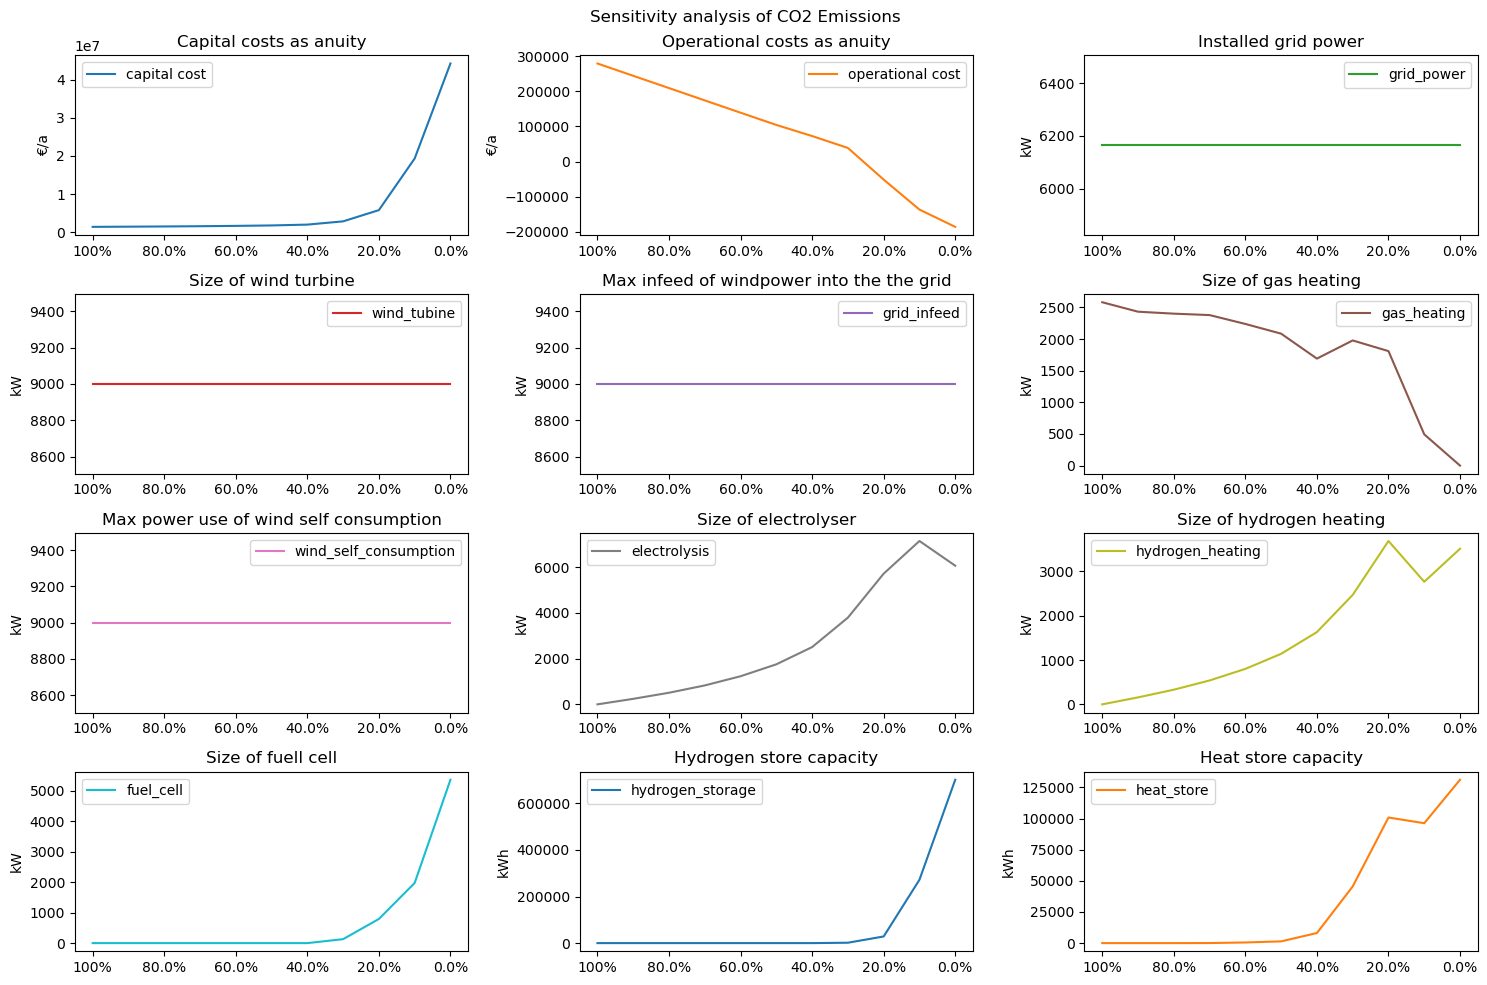

In [64]:
fig, axs = plt.subplots(nrows=4, ncols=3, figsize = (15,10))
df_results.T.plot(subplots=True, ax=axs)

axs[0,0].set_ylabel('€/a') 
axs[0,1].set_ylabel('€/a')
axs[0,2].set_ylabel('kW')
axs[1,0].set_ylabel('kW')
axs[1,1].set_ylabel('kW')
axs[1,2].set_ylabel('kW')
axs[2,0].set_ylabel('kW')
axs[2,1].set_ylabel('kW')
axs[2,2].set_ylabel('kW')
axs[3,0].set_ylabel('kW')
axs[3,1].set_ylabel('kWh')
axs[3,2].set_ylabel('kWh')


axs[0,0].set_title('Capital costs as anuity')
axs[0,1].set_title('Operational costs as anuity')
axs[0,2].set_title('Installed grid power')
axs[1,0].set_title('Size of wind turbine')
axs[1,1].set_title('Max infeed of windpower into the the grid')
axs[1,2].set_title('Size of gas heating')
axs[2,0].set_title('Max power use of wind self consumption')
axs[2,1].set_title('Size of electrolyser')
axs[2,2].set_title('Size of hydrogen heating')
axs[3,0].set_title('Size of fuell cell')
axs[3,1].set_title('Hydrogen store capacity')
axs[3,2].set_title('Heat store capacity')


fig.suptitle('Sensitivity analysis of CO2 Emissions')
fig.tight_layout()